# Final Notebook V2

# Scraping BestFightOdds.com

In [87]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
import time
import requests     
import shutil      
import datetime
from scipy.stats import norm
from random import randint
import  random
import os
os.chdir('C:/Users/Travis/OneDrive/Data Science/Personal_Projects/Sports/UFC_Prediction_V2')
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import winsound
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector as selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LinearRegression
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, f1_score, make_scorer, recall_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pprint
import pickle
import winsound
from cmath import nan
import plotly
import plotly.express as px
from plotly import graph_objects as go
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import pydot
from IPython.display import Image, display
from sklearn.tree import DecisionTreeClassifier, export_graphviz, _tree



# Sound Variables
sound_file = "data/audio/Jobs Done.wav"

def play_jobs_done():
    winsound.PlaySound(sound_file, winsound.SND_FILENAME)


bad_sound_file = 'data/audio/Danger Will Robinson.wav'

def play_danger():
    winsound.PlaySound(bad_sound_file, winsound.SND_FILENAME)


## Excel-fixed data:

Initially, I matched up events in excel, so we will load that file. From here on out, I have a function that will scrape the data for me.

In [88]:
# load excel-fixed data
fight_odds_urls = pd.read_csv('data/final/events/Final_Hand_Done_BFO_Urls_with UFC_Stats_Urls.csv')

print(fight_odds_urls.shape)
fight_odds_urls.head(3)

(534, 11)


event_title  \
0    UFC Fight Night: Thompson vs. Holland   
1  UFC Fight Night: Nzechukwu vs. Cutelaba   
2            UFC 281: Adesanya vs. Pereira   

                                           event_url  \
0  http://ufcstats.com/event-details/b23388ff8ac6...   
1  http://ufcstats.com/event-details/012fc7cd0779...   
2  http://ufcstats.com/event-details/b3b6e80b7d5f...   

                                      event_odds_url             Short_title  \
0  https://www.bestfightodds.com/events/ufc-fight...    Thompson vs. Holland   
1  https://www.bestfightodds.com/events/ufc-fight...  Nzechukwu vs. Cutelaba   
2  https://www.bestfightodds.com/events/ufc-281-2529    Adesanya vs. Pereira   

  Short_Title_2 (vs. to vs)      Name1     Name2 event_name event_date  \
0       Thompson vs Holland   thompson   holland        NaN        NaN   
1     Nzechukwu vs Cutelaba  nzechukwu  cutelaba        NaN        NaN   
2       Adesanya vs Pereira   adesanya   pereira        NaN        NaN   

  event_id bfo_url  
0      NaN     NaN  
1      NaN     NaN  
2      NaN     NaN

In [89]:
# get all event urls
event_urls = fight_odds_urls['event_url'].unique()
print(f' {len(event_urls)} events')

# get all event urls
event_urls = fight_odds_urls['event_url'].unique()
# split by /, keep last
event_urls = [url.split('/')[-1] for url in event_urls]

 522 events


In [90]:

def get_last_events_ufcstats():
    """
    Retrieves information about completed UFC events from the UFC Stats website.
    Returns a DataFrame with columns: event_name, event_date, event_url, event_id.
    """
    url = 'http://www.ufcstats.com/statistics/events/completed'
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Extract event links and names
    events = soup.find_all('a', class_='b-link b-link_style_black')
    event_links = [link.get('href') for link in events]
    event_names = [link.text.strip() for link in events]

    # Extract event dates
    event_dates = soup.find_all('span', class_='b-statistics__date')
    event_dates = [date.text.strip() for date in event_dates][1:]

    # Create DataFrame
    df = pd.DataFrame({'event_name': event_names, 'event_date': event_dates, 'event_url': event_links})
    df['event_date'] = pd.to_datetime(df['event_date'])
    df = df.sort_values(by='event_date', ascending=False).reset_index(drop=True)
    df['event_id'] = df['event_url'].apply(lambda x: x.split('/')[-1])
    
    return df

In [91]:
last_events = get_last_events_ufcstats()
last_events.head(3)

event_name event_date  \
0  UFC Fight Night: Holloway vs. Allen 2023-04-15   
1      UFC 287: Pereira vs. Adesanya 2 2023-04-08   
2  UFC Fight Night: Vera vs. Sandhagen 2023-03-25   

                                           event_url          event_id  
0  http://www.ufcstats.com/event-details/15b1b21c...  15b1b21cd743d652  
1  http://www.ufcstats.com/event-details/3dc30222...  3dc3022232b79c7a  
2  http://www.ufcstats.com/event-details/aec273fc...  aec273fcb765330d

In [92]:
last_events_urls = last_events['event_id'].unique()
# get events  in last_events that are not in fight_odds_urls
new_events = [event for event in last_events_urls if event not in event_urls]
new_events

[]

Identify Events to Download

In [93]:
missing_events = last_events[last_events['event_id'].isin(new_events)]
# strip event names
missing_events['event_name'] = missing_events['event_name'].apply(lambda x: x.strip())
missing_events

Empty DataFrame
Columns: [event_name, event_date, event_url, event_id]
Index: []

Find BestFightOdds url for event

In [94]:
driver = webdriver.Chrome()

In [95]:
def get_bfo_url(event_name):
    """
    Input is event name from missing_events
    Output is url from bestfightodds.com
    """
    filtered_df = missing_events[missing_events['event_name'] == event_name]
    driver.get('https://www.google.com/')
    # wait 1 sec
    time.sleep(1)

    # search 'site: bestfightodds.com'
    search = driver.find_element_by_name('q')
    search.send_keys('site:bestfightodds.com ' + '"events"' +' ' + filtered_df['event_name'].iloc[0])
    search.send_keys(Keys.RETURN)
    
    # get the first link
    first_link = driver.find_element_by_xpath('//*[@id="rso"]/div[1]/div/div/div/div/div[1]/a')
    first_link.click()
    
    # get the url
    url = driver.current_url
    return url

In [97]:
if len(missing_events) > 0:
    missing_events['event_name'][0]

In [99]:
if len(missing_events) > 0:
    get_bfo_url(missing_events['event_name'][0])

In [100]:
# for each event in missing_events, get the bfo url and add it to the dataframe with lambda apply

bfo_urls = []
for event in missing_events['event_name']:
    try:
        bfo_url = get_bfo_url(event)
        bfo_urls.append(bfo_url)
    except:
        bfo_urls.append('error')
        print(f'error with {event}')

missing_events['bfo_url'] = bfo_urls
missing_events

Empty DataFrame
Columns: [event_name, event_date, event_url, event_id, bfo_url]
Index: []

If there are any errors here, it may be necessary to fix manually, like I did for the two matches below:

In [101]:
# # Add https://www.bestfightodds.com/events/ufc-282-2621 to UFC 282: Blachowicz vs. Ankalaev
# missing_events['bfo_url'][11] = 'https://www.bestfightodds.com/events/ufc-282-2621'

# # add jones vs gane
# missing_events['bfo_url'][3] = 'https://www.bestfightodds.com/events/ufc-285-2738'


In [102]:
# rename bfo_url to event_odds_url
missing_events = missing_events.rename(columns={'bfo_url': 'event_odds_url'})
# rename event_name to event_title
missing_events = missing_events.rename(columns={'event_name': 'event_title'})
# drop event_id
missing_events = missing_events.drop(columns=['event_id'])

In [103]:
# update fight_odds_urls with missing_events
fight_odds_urls = pd.concat([fight_odds_urls, missing_events], axis=0)
fight_odds_urls = fight_odds_urls.reset_index(drop=True)
fight_odds_urls.head(3)

event_title  \
0    UFC Fight Night: Thompson vs. Holland   
1  UFC Fight Night: Nzechukwu vs. Cutelaba   
2            UFC 281: Adesanya vs. Pereira   

                                           event_url  \
0  http://ufcstats.com/event-details/b23388ff8ac6...   
1  http://ufcstats.com/event-details/012fc7cd0779...   
2  http://ufcstats.com/event-details/b3b6e80b7d5f...   

                                      event_odds_url             Short_title  \
0  https://www.bestfightodds.com/events/ufc-fight...    Thompson vs. Holland   
1  https://www.bestfightodds.com/events/ufc-fight...  Nzechukwu vs. Cutelaba   
2  https://www.bestfightodds.com/events/ufc-281-2529    Adesanya vs. Pereira   

  Short_Title_2 (vs. to vs)      Name1     Name2 event_name event_date  \
0       Thompson vs Holland   thompson   holland        NaN        NaN   
1     Nzechukwu vs Cutelaba  nzechukwu  cutelaba        NaN        NaN   
2       Adesanya vs Pereira   adesanya   pereira        NaN        NaN   

  event_id bfo_url  
0      NaN     NaN  
1      NaN     NaN  
2      NaN     NaN

In [104]:
# save to csv
fight_odds_urls.to_csv('data/final/events/Final_Hand_Done_BFO_Urls_with UFC_Stats_Urls.csv', index=False)

#### Scraping BFO via Requests & Headers

In [105]:
# you can scrape bestfightodds by pretending to be a browser
# you will get a 404 error if you don't do this

url = 'https://www.bestfightodds.com/events/ufc-282-2621'
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
r = requests.get(url, headers = header)
dfs = pd.read_html(r.text)
dfs[0]

Jan Brachowicz
0                    Magomed Ankalaev
1                      Over 1½ rounds
2                     Under 1½ rounds
3                      Over 2½ rounds
4                     Under 2½ rounds
...                               ...
1725  Under 7½ fights go the distance
1726   Over 8½ fights go the distance
1727  Under 8½ fights go the distance
1728   Over 9½ fights go the distance
1729  Under 9½ fights go the distance

[1730 rows x 1 columns]

## Scraping BFO Data

In [106]:
fight_odds_urls = pd.read_csv('data/final/events/Final_Hand_Done_BFO_Urls_with UFC_Stats_Urls.csv')

In [107]:
all_event_odds_urls = fight_odds_urls.event_odds_url.unique()
len(all_event_odds_urls)

503

In [108]:
len('https://www.bestfightodds.com/events/')

37

In [109]:
def get_odds(url):
        # you can scrape by pretending to be a browser
        header = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
        "X-Requested-With": "XMLHttpRequest"
        }
        r = requests.get(url, headers = header)
        dfs = pd.read_html(r.text)
        data = dfs[1]
        data.rename(columns={'Unnamed: 0': 'fighter'}, inplace=True)
        data['event_odds_url'] = url
        event_name = url.split('/')[4]
        data['event_id'] = event_name
        data.to_csv('data/final/events/odds_per_event/' + event_name + '.csv', index=False)
        return data



In [110]:
get_odds(all_event_odds_urls[0]).head(2)

fighter DraftKings BetMGM Caesars BetRivers FanDuel  PointsBet  \
0     Kevin Holland      -170▲  -185▼   -195▼     -200▼   -166▼        NaN   
1  Stephen Thompson      +145▼  +150▲   +165▲     +160▲   +140▲        NaN   

  Unibet Bet365 BetWay  5D    Ref  Props  Props.1  Props.2  \
0  -200▼  -175▲  -188▲ NaN  -200▼    NaN    118.0      NaN   
1  +160▲  +150▼  +150▼ NaN  +170▲    NaN    118.0      NaN   

                                      event_odds_url                  event_id  
0  https://www.bestfightodds.com/events/ufc-fight...  ufc-fight-night-214-2607  
1  https://www.bestfightodds.com/events/ufc-fight...  ufc-fight-night-214-2607

In [111]:
# drop nan
all_event_odds_urls = all_event_odds_urls[~pd.isnull(all_event_odds_urls)]
all_event_odds_urls

array(['https://www.bestfightodds.com/events/ufc-fight-night-214-2607',
       'https://www.bestfightodds.com/events/ufc-fight-night-215-2633',
       'https://www.bestfightodds.com/events/ufc-281-2529',
       'https://www.bestfightodds.com/events/ufc-fight-night-214ting-championship-2612',
       'https://www.bestfightodds.com/events/ufc-fight-night-213-2606',
       'https://www.bestfightodds.com/events/ufc-281-2586',
       'https://www.bestfightodds.com/events/ufc-fight-night-212-2579',
       'https://www.bestfightodds.com/events/ufc-vegas-57-2489',
       'https://www.bestfightodds.com/events/ufc-fight-night-211-2569',
       'https://www.bestfightodds.com/events/ufc-279-2541',
       'https://www.bestfightodds.com/events/ufc-fight-night-gane-vs-tuivasa-2518',
       'https://www.bestfightodds.com/events/ufc-278-usman-vs-edwards-2-2545',
       'https://www.bestfightodds.com/events/ufc-fight-night-vera-vs-cruz-2552',
       'https://www.bestfightodds.com/events/ufc-on-espn-santo

In [112]:
# Initialize a counter variable to keep track of the number of URLs processed
n = 0

# Initialize lists to store URLs that resulted in errors and those that were processed successfully
errors = []
complete = []

# Get a list of filenames from the 'data/final/events/odds_per_event/' directory
files = os.listdir('data/final/events/odds_per_event/')

# Extract the file identifiers (excluding the file extension) to store them in 'file_list'
file_list = [n[:-4] for n in files]

# Loop through each URL in the list of URLs pointing to event odds pages
for url in all_event_odds_urls:
    # Extract the unique identifier from the URL (excluding the file extension)
    url_file_name = url.split('/')[-1]
    url_file_name2 = url_file_name[:-4]
    
    # Check if the unique identifier is already in the list of processed files
    if url_file_name not in file_list:
        try:
            # Attempt to get odds data from the URL using the 'get_odds' function
            get_odds(url)
            
            # Print a message indicating the progress (number of URLs processed out of total)
            print(f'{n} / {len(all_event_odds_urls)}')
            
            # Increment the counter variable
            n += 1
        except:
            # Print an error message if an exception occurs while getting odds data
            print(f'ERROR! {n} / {len(all_event_odds_urls)}')
            
            # Append the problematic URL to the 'errors' list
            errors.append(url)
            
            # Increment the counter variable
            n += 1
    else:
        # If the unique identifier is already in 'file_list', print a message indicating that it exists
        print(f'{url_file_name} already exists')
        
        # Append the unique identifier to the 'complete' list
        complete.append(url_file_name)

# Print the total number of errors encountered during the execution
print(f' total errors: {len(errors)}')


ufc-fight-night-214-2607 already exists
ufc-fight-night-215-2633 already exists
ufc-281-2529 already exists
ufc-fight-night-214ting-championship-2612 already exists
ufc-fight-night-213-2606 already exists
ufc-281-2586 already exists
ufc-fight-night-212-2579 already exists
ufc-vegas-57-2489 already exists
ufc-fight-night-211-2569 already exists
ufc-279-2541 already exists
ufc-fight-night-gane-vs-tuivasa-2518 already exists
ufc-278-usman-vs-edwards-2-2545 already exists
ufc-fight-night-vera-vs-cruz-2552 already exists
ufc-on-espn-santos-vs-hill-2534 already exists
ufc-277-pena-vs-nunes-2-2517 already exists
ufc-fight-night-blaydes-vs-aspinall-2519 already exists
ufc-on-abc-ortega-vs-rodriguez-2524 already exists
ufc-on-espn-dos-anjos-vs-fiziev-2501 already exists
ufc-276-adesanya-vs-cannonier-2478 already exists
ufc-on-espn-tsarukyan-vs-gamrot-2574 already exists
ufc-fight-night-kattar-vs-emmett-2523 already exists
ufc-275-teixeira-vs-prochazka-2561 already exists
ufc-fight-night-211-244

### Append Together

In [113]:
# Get list of all files in 'data/final/events/odds_per_event/' directory
files = os.listdir('data/final/events/odds_per_event/')

# Create an empty list to store all the event odds data frames
all_event_odds = []

# Loop through each file in the directory
for file in files:
    # Read the csv file and store it as a pandas data frame
    df = pd.read_csv('data/final/events/odds_per_event/' + file)
    # Append the data frame to the list of all event odds data frames
    all_event_odds.append(df)

# Concatenate all the data frames in the list into a single data frame
all_event_odds = pd.concat(all_event_odds)

# Print the shape (dimensions) of the final data frame and display the first few rows
print(all_event_odds.shape)
all_event_odds.head()

(347809, 17)


fighter DraftKings BetMGM Caesars BetRivers FanDuel PointsBet  \
0       Brock Lesnar        NaN    NaN     NaN       NaN     NaN       NaN   
1          Frank Mir        NaN    NaN     NaN       NaN     NaN       NaN   
2  Georges St-Pierre        NaN    NaN     NaN       NaN     NaN       NaN   
3       Thiago Alves        NaN    NaN     NaN       NaN     NaN       NaN   
4      Dan Henderson        NaN    NaN     NaN       NaN     NaN       NaN   

  Unibet BetWay     5D  Ref  Props  Props.1  Props.2  \
0    NaN    NaN  -225▼  NaN    NaN      NaN      NaN   
1    NaN    NaN  +205▲  NaN    NaN      NaN      NaN   
2    NaN    NaN  -275▼  NaN    NaN      NaN      NaN   
3    NaN    NaN  +250▲  NaN    NaN      NaN      NaN   
4    NaN    NaN  -200▲  NaN    NaN      NaN      NaN   

                                     event_odds_url     event_id Bet365  
0  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN  
1  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN  
2  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN  
3  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN  
4  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN

Add Event Names & URLs to Event_Odds df

In [114]:
def get_event_title(event_odds_url):
    # first, filter the fight_odds_urls dataframe to only include rows with a matching event_odds_url
    data = fight_odds_urls[fight_odds_urls['event_odds_url'] == event_odds_url]
    # next, extract the event_title value from the filtered dataframe
    event_name = data.event_title.values[0]
    # finally, return the event_title value
    return event_name

def get_ufcstats_url(event_odds_url):
    # similar to the previous function, filter the fight_odds_urls dataframe and extract the event_url value
    data = fight_odds_urls[fight_odds_urls['event_odds_url'] == event_odds_url]
    event_url = data.event_url.values[0]
    # return the event_url value
    return event_url

In [115]:
all_event_odds['event_name'] = all_event_odds.apply(lambda row: get_event_title(row['event_odds_url']), axis=1)

In [116]:
all_event_odds['event_ufcstats_url'] = all_event_odds.apply(lambda row: get_ufcstats_url(row['event_odds_url']), axis=1)

In [117]:
all_event_odds.head(3)

fighter DraftKings BetMGM Caesars BetRivers FanDuel PointsBet  \
0       Brock Lesnar        NaN    NaN     NaN       NaN     NaN       NaN   
1          Frank Mir        NaN    NaN     NaN       NaN     NaN       NaN   
2  Georges St-Pierre        NaN    NaN     NaN       NaN     NaN       NaN   

  Unibet BetWay     5D  Ref  Props  Props.1  Props.2  \
0    NaN    NaN  -225▼  NaN    NaN      NaN      NaN   
1    NaN    NaN  +205▲  NaN    NaN      NaN      NaN   
2    NaN    NaN  -275▼  NaN    NaN      NaN      NaN   

                                     event_odds_url     event_id Bet365  \
0  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN   
1  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN   
2  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN   

  event_name                                 event_ufcstats_url  
0    UFC 100  http://ufcstats.com/event-details/0ee783aa00e4...  
1    UFC 100  http://ufcstats.com/event-details/0ee783aa00e4...  
2    UFC 100  http://ufcstats.com/event-details/0ee783aa00e4...

In [118]:
all_event_odds.to_csv('data/final/odds/All_Odds_by_Fighter_V1.csv', index=False)

In [119]:
all_event_odds['5D'] = all_event_odds['5D'].str[:-1]
all_event_odds['5D'] = all_event_odds['5D'].astype(float)
all_event_odds.head(3)

fighter DraftKings BetMGM Caesars BetRivers FanDuel PointsBet  \
0       Brock Lesnar        NaN    NaN     NaN       NaN     NaN       NaN   
1          Frank Mir        NaN    NaN     NaN       NaN     NaN       NaN   
2  Georges St-Pierre        NaN    NaN     NaN       NaN     NaN       NaN   

  Unibet BetWay     5D  Ref  Props  Props.1  Props.2  \
0    NaN    NaN -225.0  NaN    NaN      NaN      NaN   
1    NaN    NaN  205.0  NaN    NaN      NaN      NaN   
2    NaN    NaN -275.0  NaN    NaN      NaN      NaN   

                                     event_odds_url     event_id Bet365  \
0  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN   
1  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN   
2  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN   

  event_name                                 event_ufcstats_url  
0    UFC 100  http://ufcstats.com/event-details/0ee783aa00e4...  
1    UFC 100  http://ufcstats.com/event-details/0ee783aa00e4...  
2    UFC 100  http://ufcstats.com/event-details/0ee783aa00e4...

In [120]:
all_event_odds['Ref'] = all_event_odds['Ref'].str[:-1]
all_event_odds['Ref'] = all_event_odds['Ref'].astype(float)
all_event_odds.head(3)

fighter DraftKings BetMGM Caesars BetRivers FanDuel PointsBet  \
0       Brock Lesnar        NaN    NaN     NaN       NaN     NaN       NaN   
1          Frank Mir        NaN    NaN     NaN       NaN     NaN       NaN   
2  Georges St-Pierre        NaN    NaN     NaN       NaN     NaN       NaN   

  Unibet BetWay     5D  Ref  Props  Props.1  Props.2  \
0    NaN    NaN -225.0  NaN    NaN      NaN      NaN   
1    NaN    NaN  205.0  NaN    NaN      NaN      NaN   
2    NaN    NaN -275.0  NaN    NaN      NaN      NaN   

                                     event_odds_url     event_id Bet365  \
0  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN   
1  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN   
2  https://www.bestfightodds.com/events/ufc-100-137  ufc-100-137    NaN   

  event_name                                 event_ufcstats_url  
0    UFC 100  http://ufcstats.com/event-details/0ee783aa00e4...  
1    UFC 100  http://ufcstats.com/event-details/0ee783aa00e4...  
2    UFC 100  http://ufcstats.com/event-details/0ee783aa00e4...

In [121]:
# Choose columns to keep
cols = ['fighter', '5D', 'Ref', 'event_odds_url', 'event_ufcstats_url', 'event_id', 'event_name']
all_event_odds = all_event_odds[cols]
all_event_odds.head()

fighter     5D  Ref  \
0       Brock Lesnar -225.0  NaN   
1          Frank Mir  205.0  NaN   
2  Georges St-Pierre -275.0  NaN   
3       Thiago Alves  250.0  NaN   
4      Dan Henderson -200.0  NaN   

                                     event_odds_url  \
0  https://www.bestfightodds.com/events/ufc-100-137   
1  https://www.bestfightodds.com/events/ufc-100-137   
2  https://www.bestfightodds.com/events/ufc-100-137   
3  https://www.bestfightodds.com/events/ufc-100-137   
4  https://www.bestfightodds.com/events/ufc-100-137   

                                  event_ufcstats_url     event_id event_name  
0  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100  
1  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100  
2  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100  
3  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100  
4  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100

In [122]:
# get shape
all_event_odds.shape

(347809, 7)

In [123]:
all_event_odds.to_csv('data/final/odds/All_Odds_by_Fighter_V2.csv', index=False)


## Summary
- ALL ODDS by fighter are available at:
  - data/ufc_BestFightOdds/All_Event_Odds_by_Fighter.csv
- You can combine this with UfcStatsData easily using 'event_ufcstats_url' 

# Add All Events Df

Saved in final/events

In [124]:
all_event_odds = pd.read_csv('data/final/odds/All_Odds_by_Fighter_V2.csv')

In [125]:
# events are located in data/ufc_stats/events2

folder = 'data/ufc_stats/events2/'

# aggregate all events into one dataframe
all_events = []

for file in os.listdir(folder):
    df = pd.read_csv(folder + file)
    all_events.append(df)

all_events = pd.concat(all_events)

print(all_events.shape)
all_events.head()

(5775, 19)


Unnamed: 0  W/L   Weight class           Method  Round  Time  \
0           0  win    Heavyweight  KO/TKO  Punches      3  4:23   
1           1  win   Middleweight            U-DEC      3  5:00   
2           2  win   Middleweight            U-DEC      3  5:00   
3           3  win   Middleweight  KO/TKO  Punches      3  1:09   
4           4  win  Featherweight            U-DEC      3  5:00   

             Fighter1            Fighter2  F1_Kd  F2_Kd  F1_Str  F2_Str  \
0          Ciryl Gane         Tai Tuivasa      1      1     110      29   
1    Robert Whittaker      Marvin Vettori      0      0      74      33   
2  Nassourdine Imavov     Joaquin Buckley      0      0      51      46   
3       Roman Kopylov  Alessio Di Chirico      1      0      59      39   
4       William Gomis        Jarno Errens      0      0      32      20   

   F1_Td  F2_Td  F1_Sub  F2_Sub  fight_num          event_id  \
0      0      0       0       0          1  00a905a4a4a2b071   
1      1      0       0       0          2  00a905a4a4a2b071   
2      2      0       2       0          3  00a905a4a4a2b071   
3      0      0       0       0          4  00a905a4a4a2b071   
4      3      0       0       1          5  00a905a4a4a2b071   

                                          fight_link  
0  http://www.ufcstats.com/fight-details/810c9da0...  
1  http://www.ufcstats.com/fight-details/b8ca1acd...  
2  http://www.ufcstats.com/fight-details/20f316f9...  
3  http://www.ufcstats.com/fight-details/1a191251...  
4  http://www.ufcstats.com/fight-details/398db400...

In [126]:
all_events.to_csv('data/final/events/All_Events_V1.csv', index=False)

In [127]:
all_events = pd.read_csv('data/final/events/All_Events_V1.csv')

# Add Odd Changes to Odds

In [128]:
# create a function to extract odds data from a given URL
def get_odds(url):
    
    # add headers to avoid getting blocked while making requests
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
        "X-Requested-With": "XMLHttpRequest"
    }
    
    # make a GET request to the URL with the provided headers
    r = requests.get(url, headers=headers)
    
    # scrape the HTML tables present in the response content
    dfs = pd.read_html(r.text)
    
    # extract the relevant data from the second table
    data = dfs[1]
    
    # rename the first column as "fighter" for better readability
    data.rename(columns={'Unnamed: 0': 'fighter'}, inplace=True)
    
    # add the event odds URL as a new column in the dataframe
    data['event_odds_url'] = url
    
    # extract the event name from the URL and add it as a new column in the dataframe
    event_name = url.split('/')[4]
    data['event_id'] = event_name
    
    # uncomment the following line to save the extracted data as a CSV file
    # data.to_csv('data/ufc_BestFightOdds/odds_by_event/' + event_name + '.csv', index=False)
    
    # return the dataframe with the extracted odds data
    return data

In [129]:
def get_bfodds(event_url):
    # scrape the changes in odds by event url
    
    driver = webdriver.Chrome()
    driver.get(event_url)

    # click show all
    driver.find_element_by_class_name('event-swing-expand').click()
    #wait 2 seconds
    time.sleep(2)

    event_swing_container = driver.find_element_by_id('event-swing-container')
    event_swing_container.text


    # the first half of the text is the odds changes, the seconds half are the names. Lets match them up. 
    # first split the text by new line
    event_swing_container.text.split('\n')

    # get the names. You can identify them because they will be more than 5 characters long
    names = [x for x in event_swing_container.text.split('\n') if len(x) > 5]
    names

    # get the odds changes
    odds_changes = [x for x in event_swing_container.text.split('\n') if '%' in x]
    odds_changes

    # get the event name
    event_name = driver.find_element_by_class_name('table-header')
    # name is h1 in event_name
    name = event_name.find_element_by_tag_name('h1')
    event = name.text

    # get the url
    url = driver.current_url


    # create a dataframe
    df = pd.DataFrame({'names': names, 'odds_changes': odds_changes, 'event': event, 'event_url': url})
    
    #close the driver
    driver.close()

    return df

In [130]:
all_odds_eventlist = all_event_odds['event_odds_url'].unique().tolist()

In [131]:
# Initialize lists to keep track of completed, failed, and newly completed events
already_complete = []
failed = []
newly_complete = []

# Iterate through all events in the all_odds_eventlist
for url in all_odds_eventlist:
    # Extract the event name from the URL
    event_name = url.split('/')[-1]
    
    # Check if the event has already been completed
    if str(event_name) + '.csv' in os.listdir('data/final/odds/odds_changes/'):
        print('already done with ' + url.split('/')[-1])
        already_complete.append(event_name)
        continue
    else:
        try:
            # Get the odds data for the event
            df = get_bfodds(url)
            name = url.split('/')[-1]
            
            # Save the odds data to a CSV file
            df.to_csv('data/final/odds/odds_changes/' + name + '.csv', index=False)
            newly_complete.append(name)
            print('done with ' + name)
        except:
            # If there's an error, add the event to the failed list
            name = url.split('/')[-1]
            failed.append(name)
            print('failed on ' + name)
            continue

# Print the summary of completed, newly completed, and failed events
print("")
print('already done with ' + str(len(already_complete)) + ' events')
print('newly done with ' + str(len(newly_complete)) + ' events')
print('failed on ' + str(len(failed)) + ' events')

already done with ufc-100-137
already done with ufc-101-declaration-145
already done with ufc-102-couture-vs-nogueira-156
already done with ufc-103-franklin-vs-belfort-168
already done with ufc-105-couture-vs-vera-201
already done with ufc-106-ortiz-vs-griffin-2-209
already done with ufc-107-penn-vs-sanchez-189
already done with ufc-108-evans-vs-silva-219
already done with ufc-109-relentless-226
already done with ufc-110-nogueira-vs-velasquez-225
already done with ufc-111-st-pierre-vs-hardy-236
already done with ufc-112-invincible-245
already done with ufc-113-machida-vs-shogun-ii-247
already done with ufc-115-liddell-vs-franklin-255
already done with ufc-116-lesnar-vs-carwin-265
already done with ufc-118-edgar-vs-penn-2-278
already done with ufc-119-mir-vs-cro-cop-296
already done with ufc-120-bisping-vs-akiyama-294
already done with ufc-121-lesnar-vs-velasquez-308
already done with ufc-122-marquardt-vs-okami-323
already done with ufc-123-rampage-vs-machida-317
already done with ufc-1

In [132]:
# aggregate all odds changes into one dataframe
all_odds_changes = []

for file in os.listdir('data/final/odds/odds_changes/'):
    df = pd.read_csv('data/final/odds/odds_changes/' + file)
    # append
    all_odds_changes.append(df)

all_odds_changes = pd.concat(all_odds_changes)

print(all_odds_changes.shape)
all_odds_changes.to_csv('data/final/aggregates/All_Odds_Changes_V1.csv', index=False)
all_odds_changes

(11680, 4)


names odds_changes                                event  \
0         Deron Winn         -61%  GOLDEN BOY MMA: LIDDELL VS. ORTIZ 3   
1      Chuck Liddell         -30%  GOLDEN BOY MMA: LIDDELL VS. ORTIZ 3   
2      Gleison Tibau         -28%  GOLDEN BOY MMA: LIDDELL VS. ORTIZ 3   
3   Ricardo Palacios         -14%  GOLDEN BOY MMA: LIDDELL VS. ORTIZ 3   
4      Kenneth Bergh          +3%  GOLDEN BOY MMA: LIDDELL VS. ORTIZ 3   
..               ...          ...                                  ...   
19     Daniel Santos         +34%                         UFC VEGAS 57   
20     Brendan Allen         +35%                         UFC VEGAS 57   
21        Mike Davis         +55%                         UFC VEGAS 57   
22      Philipe Lins         +60%                         UFC VEGAS 57   
23       Don Shainis         +61%                         UFC VEGAS 57   

                                            event_url  
0   https://www.bestfightodds.com/events/golden-bo...  
1   https://www.bestfightodds.com/events/golden-bo...  
2   https://www.bestfightodds.com/events/golden-bo...  
3   https://www.bestfightodds.com/events/golden-bo...  
4   https://www.bestfightodds.com/events/golden-bo...  
..                                                ...  
19  https://www.bestfightodds.com/events/ufc-vegas...  
20  https://www.bestfightodds.com/events/ufc-vegas...  
21  https://www.bestfightodds.com/events/ufc-vegas...  
22  https://www.bestfightodds.com/events/ufc-vegas...  
23  https://www.bestfightodds.com/events/ufc-vegas...  

[11680 rows x 4 columns]

### Edit Event_odds 

Get rid of alternate lines

In [133]:
all_event_odds = pd.read_csv('data/final/odds/All_Odds_by_Fighter_V2.csv')
all_event_odds.head(3)

fighter     5D  Ref  \
0       Brock Lesnar -225.0  NaN   
1          Frank Mir  205.0  NaN   
2  Georges St-Pierre -275.0  NaN   

                                     event_odds_url  \
0  https://www.bestfightodds.com/events/ufc-100-137   
1  https://www.bestfightodds.com/events/ufc-100-137   
2  https://www.bestfightodds.com/events/ufc-100-137   

                                  event_ufcstats_url     event_id event_name  
0  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100  
1  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100  
2  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100

In [134]:
all_options = all_event_odds['fighter'].value_counts()
all_options = pd.DataFrame(all_options)
all_options.reset_index(inplace=True)
delete_options = all_options.head(120)
delete_options

index  fighter
0                       Any other result    96450
1                 Fight goes to decision     4768
2           Fight doesn't go to decision     4768
3                    Fight is not a draw     4762
4                        Fight is a draw     4762
..                                   ...      ...
115          Fight won't go 2:30 round 2      200
116       Over 1½ fights go the distance      185
117      Under 1½ fights go the distance      185
118  Exactly one fight goes the distance      185
119                       Over 3½ rounds      165

[120 rows x 2 columns]

In [135]:
delete_options_list = delete_options['index'].tolist()

In [136]:
# delete rows when fighter is in delete_options_list
all_event_odds = all_event_odds[~all_event_odds['fighter'].isin(delete_options_list)]
all_event_odds.head(2)

fighter     5D  Ref                                    event_odds_url  \
0  Brock Lesnar -225.0  NaN  https://www.bestfightodds.com/events/ufc-100-137   
1     Frank Mir  205.0  NaN  https://www.bestfightodds.com/events/ufc-100-137   

                                  event_ufcstats_url     event_id event_name  
0  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100  
1  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100

In [137]:
# delete any rows where fighter has more than 3 words
all_event_odds = all_event_odds[~all_event_odds['fighter'].str.contains('round')]
all_event_odds = all_event_odds[~all_event_odds['fighter'].str.contains('decision')]
all_event_odds = all_event_odds[~all_event_odds['fighter'].str.contains('submission')]
all_event_odds = all_event_odds[~all_event_odds['fighter'].str.contains('knockout')]
all_event_odds = all_event_odds[~all_event_odds['fighter'].str.contains('draw')]
all_event_odds = all_event_odds[~all_event_odds['fighter'].str.contains('scorecards')]
all_event_odds = all_event_odds[~all_event_odds['fighter'].str.contains('majority')]
all_event_odds = all_event_odds[~all_event_odds['fighter'].str.contains('Not')]
all_event_odds = all_event_odds[~all_event_odds['fighter'].str.contains('wins')]
all_event_odds = all_event_odds[~all_event_odds['fighter'].str.contains('losses')]
all_event_odds


fighter     5D    Ref  \
0             Brock Lesnar -225.0    NaN   
1                Frank Mir  205.0    NaN   
2        Georges St-Pierre -275.0    NaN   
3             Thiago Alves  250.0    NaN   
4            Dan Henderson -200.0    NaN   
...                    ...    ...    ...   
347402     Krzysztof Jotko    NaN -124.0   
347537    Chelsea Chandler    NaN  113.0   
347538  Julija Stoliarenko    NaN -133.0   
347673      Guido Cannetti    NaN  250.0   
347674         Randy Costa    NaN -300.0   

                                           event_odds_url  \
0        https://www.bestfightodds.com/events/ufc-100-137   
1        https://www.bestfightodds.com/events/ufc-100-137   
2        https://www.bestfightodds.com/events/ufc-100-137   
3        https://www.bestfightodds.com/events/ufc-100-137   
4        https://www.bestfightodds.com/events/ufc-100-137   
...                                                   ...   
347402  https://www.bestfightodds.com/events/ufc-vegas...   
347537  https://www.bestfightodds.com/events/ufc-vegas...   
347538  https://www.bestfightodds.com/events/ufc-vegas...   
347673  https://www.bestfightodds.com/events/ufc-vegas...   
347674  https://www.bestfightodds.com/events/ufc-vegas...   

                                       event_ufcstats_url           event_id  \
0       http://ufcstats.com/event-details/0ee783aa00e4...        ufc-100-137   
1       http://ufcstats.com/event-details/0ee783aa00e4...        ufc-100-137   
2       http://ufcstats.com/event-details/0ee783aa00e4...        ufc-100-137   
3       http://ufcstats.com/event-details/0ee783aa00e4...        ufc-100-137   
4       http://ufcstats.com/event-details/0ee783aa00e4...        ufc-100-137   
...                                                   ...                ...   
347402  http://ufcstats.com/event-details/4f670b7972fa...  ufc-vegas-57-2489   
347537  http://ufcstats.com/event-details/4f670b7972fa...  ufc-vegas-57-2489   
347538  http://ufcstats.com/event-details/4f670b7972fa...  ufc-vegas-57-2489   
347673  http://ufcstats.com/event-details/4f670b7972fa...  ufc-vegas-57-2489   
347674  http://ufcstats.com/event-details/4f670b7972fa...  ufc-vegas-57-2489   

                           event_name  
0                             UFC 100  
1                             UFC 100  
2                             UFC 100  
3                             UFC 100  
4                             UFC 100  
...                               ...  
347402  UFC Fight Night: Dern vs. Yan  
347537  UFC Fight Night: Dern vs. Yan  
347538  UFC Fight Night: Dern vs. Yan  
347673  UFC Fight Night: Dern vs. Yan  
347674  UFC Fight Night: Dern vs. Yan  

[24434 rows x 7 columns]

# Add Odds Change to Odds

In [138]:
def get_odds_change_from_db(event_odds_url, fighter):
    """
    Get the odds change from the all_odds_changes dataframe.
    """

    try:
        odds_change = all_odds_changes[(all_odds_changes['event_url'] == event_odds_url)
                                       & (all_odds_changes['names'] == fighter)]['odds_changes'].values[0]
        
        return odds_change
    
    except:
        return np.nan

In [139]:
# test
get_odds_change_from_db('https://www.bestfightodds.com/events/ufc-100-137', 'Brock Lesnar')

'-31%'

In [140]:
# Create odds_change column
all_event_odds["odds_change"] = all_event_odds.apply(
    lambda row: get_odds_change_from_db(row["event_odds_url"], row["fighter"]),
    axis=1
)

In [141]:
# get rid of %
all_event_odds['odds_change'] = all_event_odds['odds_change'].str.replace('%', '')
# turn into float
all_event_odds['odds_change'] = all_event_odds['odds_change'].astype(float)
all_event_odds.head(3)

fighter     5D  Ref  \
0       Brock Lesnar -225.0  NaN   
1          Frank Mir  205.0  NaN   
2  Georges St-Pierre -275.0  NaN   

                                     event_odds_url  \
0  https://www.bestfightodds.com/events/ufc-100-137   
1  https://www.bestfightodds.com/events/ufc-100-137   
2  https://www.bestfightodds.com/events/ufc-100-137   

                                  event_ufcstats_url     event_id event_name  \
0  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   
1  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   
2  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   

   odds_change  
0        -31.0  
1         59.0  
2          NaN

In [142]:
# save to csv
all_event_odds.to_csv('data/final/odds/All_Odds_by_Fighter_WithChange.csv', index=False)

In [143]:
print(f' This was last run: {datetime.datetime.now()}')

 This was last run: 2023-04-19 11:34:49.571807


## Scraping UFC Stats

### Initial Scraping Functions

In [144]:
# Define function with url parameter
def get_event_date_from_ufcstats(url):

    # Get page content from url
    page = requests.get(url)

    # Create BeautifulSoup object
    soup = BeautifulSoup(page.content, 'html.parser')

    # Find the date element in the HTML code and extract the text
    date = soup.find('li', class_='b-list__box-list-item').text

    # Remove any newline characters from the text
    date = date.replace('\n', '')

    # Find the index of the colon character in the date string
    ed = date.find(':')

    # Extract the date portion of the string and remove any leading/trailing whitespace
    date = date[ed+2:].strip()

    # Return the extracted date
    return date

In [145]:
def get_details_from_ufcstats(url):
    # Send a GET request to the specified URL and retrieve the page's content
    page = requests.get(url)

    # Use Beautiful Soup to parse the page content
    soup = BeautifulSoup(page.content, 'html.parser')

    # Find the div containing the fight details and extract its text content
    details = soup.find('div', class_='b-fight-details__content').text

    # Remove newline characters from the details text
    details = details.replace('\n', '')

    # Find the start of the details section and extract only the details text
    deet = details.find('Details:')
    details = details[deet+8:].strip()
    
    # Return the extracted fight details
    return details

In [146]:
get_details_from_ufcstats('http://www.ufcstats.com/fight-details/7e8fd03e070d0c25')

'Guillotine Choke From Bottom Guard'

In [147]:
def get_event_title_from_ufcstats(url):
    # Send GET request to the given URL and store the response in 'page' variable
    page = requests.get(url)

    # Create BeautifulSoup object by parsing the 'page' content using html.parser
    soup = BeautifulSoup(page.content, 'html.parser')

    # Find the <h2> tag element with class 'b-content__title' and store its text in 'title'
    title = soup.find('h2', class_='b-content__title').text

    # Remove any new line characters and white spaces from the title string
    title = title.replace('\n', '').strip()

    # Return the final title string
    return title

In [148]:
get_event_title_from_ufcstats('http://www.ufcstats.com/fight-details/7e8fd03e070d0c25')

'UFC 279: Diaz vs. Ferguson'

In [149]:
def get_event_url_from_ufcstats(url):
    # Scrapes the HTML content from the input URL
    page = requests.get(url)

    # Parses the HTML content using BeautifulSoup
    soup = BeautifulSoup(page.content, 'html.parser')

    # Finds the event title element and extracts the URL from it
    title_element = soup.find('h2', class_='b-content__title')
    title_anchor = title_element.find('a') # finds the <a> element within the title
    title_url = title_anchor['href'] # extracts the href attribute from the <a> element

    # Returns the URL of the event page
    return title_url

In [150]:
get_event_url_from_ufcstats('http://www.ufcstats.com/fight-details/7e8fd03e070d0c25')

'http://www.ufcstats.com/event-details/93bf96be327fcd98'

In [151]:
def get_fight_urls(urls):
    
    # create an empty dataframe to store the fight urls
    links = pd.DataFrame()
    # iterate over each url in the provided list
    for u in urls:
        try:
            # send a GET request to the current url
            reqs = requests.get(u)
            # extract the text from the html response
            soup = BeautifulSoup(reqs.text, 'html.parser')
            # extract the title of the event from the html
            title = soup.find('h2', class_='b-content__title').text.strip()
            # extract the date of the event from the html
            date = soup.find('li', class_='b-list__box-list-item').text.strip()
            d = date.find('Date:')
            # extract the date from the extracted string
            date = date[d+6:].strip()
            # find all links in the html
            for link in soup.find_all('a'):
                # check if the link contains 'fight-details'
                if 'fight-details' in link.get('href'):
                    # append the fight url to the dataframe along with the title and date of the event
                    links = links.append({
                        'Fight_url': link.get('href'),
                        'Event_title': title,
                        'Date': date
                    }, ignore_index=True)
        except:
            # return an error message if there was an issue with the request
            return 'No Fighties'
    # return the dataframe containing the fight urls
    return links


In [152]:
# test get_fight_urls
get_fight_urls(['http://www.ufcstats.com/event-details/93bf96be327fcd98'])

C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\752670239.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  links = links.append({
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\752670239.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  links = links.append({
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\752670239.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  links = links.append({
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\752670239.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  links = links.append({
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\752670239.py:24: FutureWarning: The frame.app

Fight_url  \
0   http://www.ufcstats.com/fight-details/7e8fd03e...   
1   http://www.ufcstats.com/fight-details/0111e6a6...   
2   http://www.ufcstats.com/fight-details/d3e23d7d...   
3   http://www.ufcstats.com/fight-details/989b8d36...   
4   http://www.ufcstats.com/fight-details/d869eaea...   
5   http://www.ufcstats.com/fight-details/0e6d6240...   
6   http://www.ufcstats.com/fight-details/301f230c...   
7   http://www.ufcstats.com/fight-details/77acb967...   
8   http://www.ufcstats.com/fight-details/bf334cb4...   
9   http://www.ufcstats.com/fight-details/db3e26d0...   
10  http://www.ufcstats.com/fight-details/6010f681...   
11  http://www.ufcstats.com/fight-details/a5cf273f...   
12  http://www.ufcstats.com/fight-details/86d57e8e...   

                   Event_title                Date  
0   UFC 279: Diaz vs. Ferguson  September 10, 2022  
1   UFC 279: Diaz vs. Ferguson  September 10, 2022  
2   UFC 279: Diaz vs. Ferguson  September 10, 2022  
3   UFC 279: Diaz vs. Ferguson  September 10, 2022  
4   UFC 279: Diaz vs. Ferguson  September 10, 2022  
5   UFC 279: Diaz vs. Ferguson  September 10, 2022  
6   UFC 279: Diaz vs. Ferguson  September 10, 2022  
7   UFC 279: Diaz vs. Ferguson  September 10, 2022  
8   UFC 279: Diaz vs. Ferguson  September 10, 2022  
9   UFC 279: Diaz vs. Ferguson  September 10, 2022  
10  UFC 279: Diaz vs. Ferguson  September 10, 2022  
11  UFC 279: Diaz vs. Ferguson  September 10, 2022  
12  UFC 279: Diaz vs. Ferguson  September 10, 2022

In [153]:
def get_winner_from_ufcstats(url):
    try:
        # Send a GET request to the URL
        page = requests.get(url)
        # Parse the page content using BeautifulSoup
        soup = BeautifulSoup(page.content, 'html.parser')
        # Find the two <div> elements with class 'b-fight-details__person'
        both = soup.find_all('div', class_='b-fight-details__person')
        # Get the text of the first element and remove whitespace
        first = both[0].text.replace('   ', '').replace('\n', '').strip()
        # Get the text of the second element and remove whitespace
        second = both[1].text.replace('   ', '').replace('\n', '').strip()
        # Check which fighter is the winner based on the 'W' indicator
        if(first.startswith('W')):
            winner = first[3:]
        else:
            winner = second[3:]
        # Return the name of the winner
        return winner

    except:
        # Return NaN if there's an exception
        return nan

In [154]:
# test
get_winner_from_ufcstats('http://www.ufcstats.com/fight-details/7e8fd03e070d0c25')

'Nate Diaz'

In [155]:
def get_event_date_from_ufcstats(url):
    try:
        page = requests.get(url)
        # create a BeautifulSoup object using the HTML content of the response
        soup = BeautifulSoup(page.content, 'html.parser')
        # extract the event date from the HTML source using the relevant class 
        date = soup.find('li', class_='b-list__box-list-item').text
        # remove any newline characters from the date string
        date = date.replace('\n', '')
        # find the index of the colon character in the date string
        ed = date.find(':')
        # extract the event date from the date string and remove any leading/trailing whitespace
        date = date[ed+2:].strip()
        # return the event date as a string
        return date
    except:
        return nan

In [156]:
def get_event_details(event_id):
    # This function scrapes event details from ufc stats 
    # and saves them to a csv file

    #try:
        df = pd.read_html('http://www.ufcstats.com/event-details/' + event_id)
        df = df[0]
        # split by space and get third element
        df['Fighter1'] = df['Fighter'].str.split('  ').str[0]
        df['Fighter2'] = df['Fighter'].str.split('  ').str[1]
        # fix Kd
        df['F1_Kd'] = df['Kd'].str.split('  ').str[0]
        df['F2_Kd'] = df['Kd'].str.split('  ').str[1]
        # fix Str
        df['F1_Str'] = df['Str'].str.split('  ').str[0]
        df['F2_Str'] = df['Str'].str.split('  ').str[1]
        # fix Td
        df['F1_Td'] = df['Td'].str.split('  ').str[0]
        df['F2_Td'] = df['Td'].str.split('  ').str[1]
        # fix Sub
        df['F1_Sub'] = df['Sub'].str.split('  ').str[0]
        df['F2_Sub'] = df['Sub'].str.split('  ').str[1]

        badcols = ['Fighter', 'Kd', 'Str', 'Td', 'Sub']

        # save index+1 to new column called "fight_num"
        df['fight_num'] = df.index + 1
        df['event_id'] = event_id

        # get fight links
        page = requests.get('http://www.ufcstats.com/event-details/' + event_id)
        soup = BeautifulSoup(page.content, 'html.parser')
        fight_linkies = soup.find_all('a')
        fight_links = [n['href'] for n in fight_linkies]
        fight_links = [n for n in fight_links if 'fight-details' in n]
        # delete duplicate links
        fight_links2 = pd.DataFrame(fight_links)
        fight_links2 = fight_links2.drop_duplicates()
        fight_links = fight_links2[0].tolist()

        # append fight links to df
        df['fight_link'] = fight_links

        df = df.drop(badcols, axis=1)
        df.to_csv('data/ufc_stats/events2/'+ event_id +'.csv')
        return df

In [157]:
# test 
test_1 = get_event_details('a23e63184c65f5b8').head(3)
test_1

W/L         Weight class        Method  Round  Time         Fighter1  \
0  win         Bantamweight  KO/TKO  Kick      4  2:17      Marlon Vera   
1  win        Featherweight         M-DEC      3  5:00    Nate Landwehr   
2  win  Women's Strawweight         U-DEC      3  5:00  Yazmin Jauregui   

         Fighter2 F1_Kd F2_Kd F1_Str F2_Str F1_Td F2_Td F1_Sub F2_Sub  \
0   Dominick Cruz     3     0     61     92     0     2      0      0   
1     David Onama     0     1     91     71     3     1      2      0   
2  Iasmin Lucindo     0     0     86     66     0     0      0      0   

   fight_num          event_id  \
0          1  a23e63184c65f5b8   
1          2  a23e63184c65f5b8   
2          3  a23e63184c65f5b8   

                                          fight_link  
0  http://www.ufcstats.com/fight-details/11cc331f...  
1  http://www.ufcstats.com/fight-details/efd7efba...  
2  http://www.ufcstats.com/fight-details/833d67f4...

In [158]:
def get_fight_totals(fight_details_url):
    # function returns the fight totals for a given fightid
    da_url = fight_details_url
    fightid = da_url[da_url.find('fight-details/')+14:]
    df = pd.read_html(da_url)
    # Part 1: Total Fight Stats
    totals = df[0]
    # replace '---' with 0
    for col in totals.columns:
        totals[col] = totals[col].astype(str).replace({'---': 0})
        totals[col] = totals[col].astype(str).replace({'--': 0})


    totals['Fighter_A'] = totals['Fighter'].str.split(' ').str[0] + ' ' + totals['Fighter'].str.split(' ').str[1]
    totals['Fighter_B'] = totals['Fighter'].str.split(' ').str[2] + ' ' + totals['Fighter'].str.split(' ').str[3]
    totals['A_Kd'] = totals['KD'].str.split('  ').str[0]
    totals['B_Kd'] = totals['KD'].str.split('  ').str[1]
    totals['A_Sig_strike'] = totals['Sig. str.'].str.split('  ').str[0]
    totals['B_Sig_strike'] = totals['Sig. str.'].str.split('  ').str[1]
    # split sig strikes into landed and attempted
    totals['A_Sig_strike_land'] = totals['A_Sig_strike'].str.split(' of ').str[0]
    totals['A_Sig_strike_att'] = totals['A_Sig_strike'].str.split(' of ').str[1]
    totals['B_Sig_strike_land'] = totals['B_Sig_strike'].str.split(' of ').str[0]
    totals['B_Sig_strike_att'] = totals['B_Sig_strike'].str.split(' of ').str[1]
    # change to numeric
    totals['A_Sig_strike_land'].replace({'---', 0}, inplace=True)
    totals['A_Sig_strike_att'].replace({'---', 0}, inplace=True)
    totals['B_Sig_strike_land'].replace({'---', 0}, inplace=True)
    totals['B_Sig_strike_att'].replace({'---', 0}, inplace=True)

    totals['A_Sig_strike_land'] = pd.to_numeric(totals['A_Sig_strike_land'])
    totals['A_Sig_strike_att'] = pd.to_numeric(totals['A_Sig_strike_att'])
    totals['B_Sig_strike_land'] = pd.to_numeric(totals['B_Sig_strike_land'])
    totals['B_Sig_strike_att'] = pd.to_numeric(totals['B_Sig_strike_att'])
    # change infs and nans to 0
    totals['A_Sig_strike_land'] = totals['A_Sig_strike_land'].replace([np.inf, -np.inf, np.nan], 0)
    totals['A_Sig_strike_att'] = totals['A_Sig_strike_att'].replace([np.inf, -np.inf, np.nan], 0)
    totals['B_Sig_strike_land'] = totals['B_Sig_strike_land'].replace([np.inf, -np.inf, np.nan], 0)
    totals['B_Sig_strike_att'] = totals['B_Sig_strike_att'].replace([np.inf, -np.inf, np.nan], 0)

    totals['A_Sig_strike_percent'] = totals['Sig. str. %'].str.split('  ').str[0]
    totals['B_Sig_strike_percent'] = totals['Sig. str. %'].str.split('  ').str[1]
    # get rid of % sign
    totals['A_Sig_strike_percent'] = totals['A_Sig_strike_percent'].str.replace('%', '')
    totals['B_Sig_strike_percent'] = totals['B_Sig_strike_percent'].str.replace('%', '')

    totals['A_Sig_strike_percent'] = totals['A_Sig_strike_percent'].astype(str).replace({'---': 0})
    totals['B_Sig_strike_percent'] = totals['B_Sig_strike_percent'].astype(str).replace({'---': 0})
    # change to numeric
    totals['A_Sig_strike_percent'] = pd.to_numeric(totals['A_Sig_strike_percent'])/100
    totals['B_Sig_strike_percent'] = pd.to_numeric(totals['B_Sig_strike_percent'])/100
    # total strikes
    totals['A_Total_Strikes'] = totals['Total str.'].str.split('  ').str[0]
    totals['B_Total_Strikes'] = totals['Total str.'].str.split('  ').str[1]
    # split total strikes into landed and attempted
    totals['A_Total_Strikes_land'] = totals['A_Total_Strikes'].str.split(' of ').str[0]
    totals['A_Total_Strikes_att'] = totals['A_Total_Strikes'].str.split(' of ').str[1]
    totals['B_Total_Strikes_land'] = totals['B_Total_Strikes'].str.split(' of ').str[0]
    totals['B_Total_Strikes_att'] = totals['B_Total_Strikes'].str.split(' of ').str[1]

    totals['A_Total_Strikes_land'].replace({'---',0}, inplace=True)
    totals['A_Total_Strikes_att'].replace({'---',0}, inplace=True)
    totals['B_Total_Strikes_land'].replace({'---',0}, inplace=True)
    totals['B_Total_Strikes_att'].replace({'---',0}, inplace=True)
    # change to numeric
    totals['A_Total_Strikes_land'] = pd.to_numeric(totals['A_Total_Strikes_land'])
    totals['A_Total_Strikes_att'] = pd.to_numeric(totals['A_Total_Strikes_att'])
    totals['B_Total_Strikes_land'] = pd.to_numeric(totals['B_Total_Strikes_land'])
    totals['B_Total_Strikes_att'] = pd.to_numeric(totals['B_Total_Strikes_att'])

    totals['A_Total_Strikes_land'].astype(str).replace({'---',0}, inplace=True)
    totals['A_Total_Strikes_att'].astype(str).replace({'---',0}, inplace=True)
    totals['B_Total_Strikes_land'].astype(str).replace({'---',0}, inplace=True)
    totals['B_Total_Strikes_att'].astype(str).replace({'---',0}, inplace=True) 
    # change infs and nans to 0
    totals['A_Total_Strikes_land'] = totals['A_Total_Strikes_land'].replace([np.inf, -np.inf, np.nan], 0)
    totals['A_Total_Strikes_att'] = totals['A_Total_Strikes_att'].replace([np.inf, -np.inf, np.nan], 0)
    totals['B_Total_Strikes_land'] = totals['B_Total_Strikes_land'].replace([np.inf, -np.inf, np.nan], 0)
    totals['B_Total_Strikes_att'] = totals['B_Total_Strikes_att'].replace([np.inf, -np.inf, np.nan], 0)


    # calculate total strike percentage
    totals['A_Total_Strikes_percent'] = totals['A_Total_Strikes_land'] / totals['A_Total_Strikes_att']
    totals['B_Total_Strikes_percent'] = totals['B_Total_Strikes_land'] / totals['B_Total_Strikes_att']
    # takedown stats
    totals['A_Takedowns'] = totals['Td'].str.split('  ').str[0]
    totals['B_Takedowns'] = totals['Td'].str.split('  ').str[1]
    # split takedowns into landed and attempted
    totals['A_Takedowns_land'] = totals['A_Takedowns'].str.split(' of ').str[0]
    totals['A_Takedowns_att'] = totals['A_Takedowns'].str.split(' of ').str[1]
    totals['B_Takedowns_land'] = totals['B_Takedowns'].str.split(' of ').str[0]
    totals['B_Takedowns_att'] = totals['B_Takedowns'].str.split(' of ').str[1]
    # change to numeric
    totals['A_Takedowns_land'] = pd.to_numeric(totals['A_Takedowns_land'])
    totals['A_Takedowns_att'] = pd.to_numeric(totals['A_Takedowns_att'])
    totals['B_Takedowns_land'] = pd.to_numeric(totals['B_Takedowns_land'])
    totals['B_Takedowns_att'] = pd.to_numeric(totals['B_Takedowns_att'])
    # fix %
    totals['Td %'].replace({'---': 0}, inplace=True)
    # get rid of ---
    totals['A_Takedowns_land'].replace({'---': 0}, inplace=True)
    totals['A_Takedowns_att'].replace({'---': 0}, inplace=True)
    totals['B_Takedowns_land'].replace({'---': 0}, inplace=True)
    totals['B_Takedowns_att'].replace({'---': 0}, inplace=True)
    # change infs and nans to 0
    totals['A_Takedowns_land'] = totals['A_Takedowns_land'].replace([np.inf, -np.inf, np.nan], 0)
    totals['A_Takedowns_att'] = totals['A_Takedowns_att'].replace([np.inf, -np.inf, np.nan], 0)
    totals['B_Takedowns_land'] = totals['B_Takedowns_land'].replace([np.inf, -np.inf, np.nan], 0)
    totals['B_Takedowns_att'] = totals['B_Takedowns_att'].replace([np.inf, -np.inf, np.nan], 0)

    totals['A_Takedown_percent'] = totals['A_Takedowns_land'] / totals['A_Takedowns_att']
    totals['B_Takedown_percent'] = totals['B_Takedowns_land'] / totals['B_Takedowns_att']
    # submission attempts
    totals['A_Sub_Attempts'] = totals['Sub. att'].str.split('  ').str[0]
    totals['B_Sub_Attempts'] = totals['Sub. att'].str.split('  ').str[1]
    # split submission attempts into landed and attempted
    totals['A_Sub_Attempts_land'] = totals['A_Sub_Attempts'].str.split(' of ').str[0]
    totals['A_Sub_Attempts_att'] = totals['A_Sub_Attempts'].str.split(' of ').str[1]
    totals['B_Sub_Attempts_land'] = totals['B_Sub_Attempts'].str.split(' of ').str[0]
    totals['B_Sub_Attempts_att'] = totals['B_Sub_Attempts'].str.split(' of ').str[1]
    # change to numeric
    totals['A_Sub_Attempts_land'] = pd.to_numeric(totals['A_Sub_Attempts_land'])
    totals['A_Sub_Attempts_att'] = pd.to_numeric(totals['A_Sub_Attempts_att'])
    totals['B_Sub_Attempts_land'] = pd.to_numeric(totals['B_Sub_Attempts_land'])
    totals['B_Sub_Attempts_att'] = pd.to_numeric(totals['B_Sub_Attempts_att'])

    # change infs and nans to 0
    totals['A_Sub_Attempts_land'] = totals['A_Sub_Attempts_land'].replace([np.inf, -np.inf, np.nan], 0)
    totals['A_Sub_Attempts_att'] = totals['A_Sub_Attempts_att'].replace([np.inf, -np.inf, np.nan], 0)
    totals['B_Sub_Attempts_land'] = totals['B_Sub_Attempts_land'].replace([np.inf, -np.inf, np.nan], 0)
    totals['B_Sub_Attempts_att'] = totals['B_Sub_Attempts_att'].replace([np.inf, -np.inf, np.nan], 0)

    # create submission percent
    totals['A_Sub_Success_Percent'] = totals['A_Sub_Attempts_land'] / totals['A_Sub_Attempts_att']
    totals['B_Sub_Success_Percent'] = totals['B_Sub_Attempts_land'] / totals['B_Sub_Attempts_att']

    # Rev
    totals['A_Rev'] = totals['Rev.'].str.split('  ').str[0]
    totals['B_Rev'] = totals['Rev.'].str.split('  ').str[1]
    # change to numeric
    totals['A_Rev'] = pd.to_numeric(totals['A_Rev'])
    totals['B_Rev'] = pd.to_numeric(totals['B_Rev'])
    # control time
    totals['A_Ctrl_time'] = totals['Ctrl'].str.split('  ').str[0]
    totals['B_Ctrl_time'] = totals['Ctrl'].str.split('  ').str[1]
    

    # split control time into minutes and seconds, and then convert to seconds
    totals['A_Ctrl_time_min'] = totals['A_Ctrl_time'].str.split(':').str[0]
    totals['A_Ctrl_time_sec'] = totals['A_Ctrl_time'].str.split(':').str[1]
    totals['B_Ctrl_time_min'] = totals['B_Ctrl_time'].str.split(':').str[0]
    totals['B_Ctrl_time_sec'] = totals['B_Ctrl_time'].str.split(':').str[1]

    totals['A_Ctrl_time_min'] = totals['A_Ctrl_time_min'].replace({'--': 0})
    totals['A_Ctrl_time_sec'] = totals['A_Ctrl_time_sec'].replace({'--': 0})
    totals['B_Ctrl_time_min'] = totals['B_Ctrl_time_min'].replace({'--': 0})
    totals['B_Ctrl_time_sec'] = totals['B_Ctrl_time_sec'].replace({'--': 0})

    # convert to seconds
    totals['A_Ctrl_time_tot'] = pd.to_numeric(totals['A_Ctrl_time_min']) * 60 + pd.to_numeric(totals['A_Ctrl_time_sec'])
    totals['B_Ctrl_time_tot'] = pd.to_numeric(totals['B_Ctrl_time_min']) * 60 + pd.to_numeric(totals['B_Ctrl_time_sec'])


    # add date with beatufil soup
    totals['details'] = get_details_from_ufcstats(da_url)
    totals['event_title'] = get_event_title_from_ufcstats(da_url)
    event_url = get_event_url_from_ufcstats(da_url)
    totals['event_url'] = event_url
    totals['date'] = get_event_date_from_ufcstats(event_url)

    try:
        totals['Winner']= get_winner_from_ufcstats(da_url)
    except:
        totals['Winner']= nan

    # Identify columns to drop
    bad_cols = ['Fighter', 'KD', 'Sig. str. %', 'Sig. str.', 'Total str.', 'Td', 'Td %', 'Sub. att', 
                'Rev.', 'Ctrl', 'A_Sig_strike', 'B_Sig_strike', 'A_Takedowns', 'B_Takedowns',
                'A_Sub_Attempts', 'B_Sub_Attempts', 'A_Ctrl_time', 'B_Ctrl_time']
    totals.drop(columns=bad_cols, inplace=True)

    # Save
    totals.to_csv('data/ufc_stats/fight_totals3/' + fightid + '_totals.csv')
    
    return totals
    


In [159]:
# More Concise Version:
# def get_fight_totals(fight_details_url):

#     # function returns the fight totals for a given fightid
#     fightid = fight_details_url[fight_details_url.find('fight-details/')+14:]
#     df = pd.read_html(fight_details_url)

#     # Part 1: Total Fight Stats
#     totals = df[0]
#     # replace '---' and '--' with 0
#     totals = totals.replace(['---', '--'], 0)

#     # Creating new columns with fighters A and B information
#     for col in ['Fighter', 'KD', 'Sig. str.', 'Total str.', 'Td', 'Sub. att', 'Rev.', 'Ctrl']:
#         col_split = totals[col].str.split('  ').apply(pd.Series)
#         totals[f'Fighter_A_{col}'], totals[f'Fighter_B_{col}'] = col_split[0], col_split[1]

#     totals['Fighter_A'], totals['Fighter_B'] = totals['Fighter_A_Fighter'].str.split(' ').str[:2].str.join(' '), totals['Fighter_B_Fighter'].str.split(' ').str[:2].str.join(' ')

#     # Drop original columns
#     bad_cols = ['Fighter', 'KD', 'Sig. str.', 'Total str.', 'Td', 'Sub. att', 'Rev.', 'Ctrl']
#     totals.drop(columns=bad_cols, inplace=True)

#     # Create helper function to split columns with ' of ' and calculate percentage
#     def split_and_calculate_percentage(data, column):
#         data[f'{column}_land'], data[f'{column}_att'] = data[column].str.split(' of ').str
#         data[f'{column}_land'], data[f'{column}_att'] = pd.to_numeric(data[f'{column}_land']), pd.to_numeric(data[f'{column}_att'])
#         data[f'{column}_percent'] = data[f'{column}_land'] / data[f'{column}_att']
#         data[f'{column}_percent'] = data[f'{column}_percent'].replace([np.inf, -np.inf, np.nan], 0)

#     # Calculate percentage for Sig. str., Total str., Td and Sub. att
#     for col in ['Fighter_A_Sig. str.', 'Fighter_B_Sig. str.', 'Fighter_A_Total str.', 'Fighter_B_Total str.', 'Fighter_A_Td', 'Fighter_B_Td', 'Fighter_A_Sub. att', 'Fighter_B_Sub. att']:
#         split_and_calculate_percentage(totals, col)

#     # Calculate Control Time in seconds
#     for fighter in ['Fighter_A', 'Fighter_B']:
#         totals[f'{fighter}_Ctrl_min'], totals[f'{fighter}_Ctrl_sec'] = totals[f'{fighter}_Ctrl'].str.split(':').str
#         totals[f'{fighter}_Ctrl_tot'] = pd.to_numeric(totals[f'{fighter}_Ctrl_min']) * 60 + pd.to_numeric(totals[f'{fighter}_Ctrl_sec'])

#     # Save fight details to CSV
#     fight_info_cols = ['details', 'event_title', 'event_url', 'date']
#     for col in fight_info_cols:
#         totals[col] = totals['Fighter_A_Fighter'].apply(lambda _: '')

#     totals['details'] = get_details_from_ufcstats(fight_details_url)
#     totals['event_title'] = get_event_title_from_ufcstats(fight_details_url)
#     totals['event_url'] = get_event_url_from_ufcstats(fight_details_url)
#     totals['date'] = get_event_date_from_ufcstats(totals['event_url'])

#     try:
#         totals['Winner'] = get_winner_from_ufcstats(fight_details_url)
#     except Exception:
#         totals['Winner'] = np.nan

#     totals.to_csv('data/ufc_stats/fight_totals3/' + fightid + '_totals.csv')

#     return totals

In [160]:
# test
thomp_holland= get_fight_totals('http://www.ufcstats.com/fight-details/a419e6df765aa755')

In [161]:
def get_significant_strikes(url):
    df = pd.read_html(url)
    # Part 2: Significant Strikes
    ss = df[2]
     
    ss['Fighter_A'] = ss['Fighter'].str.split(' ').str[0] + ' ' + ss['Fighter'].str.split(' ').str[1]
    ss['Fighter_B'] = ss['Fighter'].str.split(' ').str[2] + ' ' + ss['Fighter'].str.split(' ').str[3]
    ss['A_Head_Strikes'] = ss['Head'].str.split('  ').str[0]
    ss['B_Head_Strikes'] = ss['Head'].str.split('  ').str[1]
    # split head strikes into landed and attempted
    ss['A_Head_Strikes_land'] = ss['A_Head_Strikes'].str.split(' of ').str[0]
    ss['A_Head_Strikes_att'] = ss['A_Head_Strikes'].str.split(' of ').str[1]
    ss['B_Head_Strikes_land'] = ss['B_Head_Strikes'].str.split(' of ').str[0]
    ss['B_Head_Strikes_att'] = ss['B_Head_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Head_Strikes_land'] = pd.to_numeric(ss['A_Head_Strikes_land'])
    ss['A_Head_Strikes_att'] = pd.to_numeric(ss['A_Head_Strikes_att'])
    ss['B_Head_Strikes_land'] = pd.to_numeric(ss['B_Head_Strikes_land'])
    ss['B_Head_Strikes_att'] = pd.to_numeric(ss['B_Head_Strikes_att'])

    # replace any nans or infs with 0
    ss['A_Head_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['A_Head_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Head_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Head_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    

    # Head Strikes Percentage
    ss['A_Head_Strikes_percent'] = ss['A_Head_Strikes_land'] / ss['A_Head_Strikes_att']
    ss['B_Head_Strikes_percent'] = ss['B_Head_Strikes_land'] / ss['B_Head_Strikes_att']
    # Body Strikes
    ss['A_Body_Strikes'] = ss['Body'].str.split('  ').str[0]
    ss['B_Body_Strikes'] = ss['Body'].str.split('  ').str[1]
    # split body strikes into landed and attempted
    ss['A_Body_Strikes_land'] = ss['A_Body_Strikes'].str.split(' of ').str[0]
    ss['A_Body_Strikes_att'] = ss['A_Body_Strikes'].str.split(' of ').str[1]
    ss['B_Body_Strikes_land'] = ss['B_Body_Strikes'].str.split(' of ').str[0]
    ss['B_Body_Strikes_att'] = ss['B_Body_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Body_Strikes_land'] = pd.to_numeric(ss['A_Body_Strikes_land'])
    ss['A_Body_Strikes_att'] = pd.to_numeric(ss['A_Body_Strikes_att'])
    ss['B_Body_Strikes_land'] = pd.to_numeric(ss['B_Body_Strikes_land'])
    ss['B_Body_Strikes_att'] = pd.to_numeric(ss['B_Body_Strikes_att'])
    # Change any nans or infs to 0
    ss['A_Body_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['A_Body_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Body_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Body_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)

    # Body Strikes Percentage
    ss['A_Body_Strikes_percent'] = ss['A_Body_Strikes_land'] / ss['A_Body_Strikes_att']
    ss['B_Body_Strikes_percent'] = ss['B_Body_Strikes_land'] / ss['B_Body_Strikes_att']
    # Leg Strikes
    ss['A_Leg_Strikes'] = ss['Leg'].str.split('  ').str[0]
    ss['B_Leg_Strikes'] = ss['Leg'].str.split('  ').str[1]
    # split leg strikes into landed and attempted
    ss['A_Leg_Strikes_land'] = ss['A_Leg_Strikes'].str.split(' of ').str[0]
    ss['A_Leg_Strikes_att'] = ss['A_Leg_Strikes'].str.split(' of ').str[1]
    ss['B_Leg_Strikes_land'] = ss['B_Leg_Strikes'].str.split(' of ').str[0]
    ss['B_Leg_Strikes_att'] = ss['B_Leg_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Leg_Strikes_land'] = pd.to_numeric(ss['A_Leg_Strikes_land'])
    ss['A_Leg_Strikes_att'] = pd.to_numeric(ss['A_Leg_Strikes_att'])
    ss['B_Leg_Strikes_land'] = pd.to_numeric(ss['B_Leg_Strikes_land'])
    ss['B_Leg_Strikes_att'] = pd.to_numeric(ss['B_Leg_Strikes_att'])
    # change any nans or infs to 0
    ss['A_Leg_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['A_Leg_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Leg_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Leg_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)

    # Leg Strikes Percentage
    ss['A_Leg_Strikes_percent'] = ss['A_Leg_Strikes_land'] / ss['A_Leg_Strikes_att']
    ss['B_Leg_Strikes_percent'] = ss['B_Leg_Strikes_land'] / ss['B_Leg_Strikes_att']
    # Distance Strikes
    ss['A_Distance_Strikes'] = ss['Distance'].str.split('  ').str[0]
    ss['B_Distance_Strikes'] = ss['Distance'].str.split('  ').str[1]
    # split distance strikes into landed and attempted
    ss['A_Distance_Strikes_land'] = ss['A_Distance_Strikes'].str.split(' of ').str[0]
    ss['A_Distance_Strikes_att'] = ss['A_Distance_Strikes'].str.split(' of ').str[1]
    ss['B_Distance_Strikes_land'] = ss['B_Distance_Strikes'].str.split(' of ').str[0]
    ss['B_Distance_Strikes_att'] = ss['B_Distance_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Distance_Strikes_land'] = pd.to_numeric(ss['A_Distance_Strikes_land'])
    ss['A_Distance_Strikes_att'] = pd.to_numeric(ss['A_Distance_Strikes_att'])
    ss['B_Distance_Strikes_land'] = pd.to_numeric(ss['B_Distance_Strikes_land'])
    ss['B_Distance_Strikes_att'] = pd.to_numeric(ss['B_Distance_Strikes_att'])

    # change any nans or infs to 0
    ss['A_Distance_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['A_Distance_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Distance_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Distance_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)


    # distance strikes percentage
    ss['A_Distance_Strikes_percent'] = ss['A_Distance_Strikes_land'] / ss['A_Distance_Strikes_att']
    ss['B_Distance_Strikes_percent'] = ss['B_Distance_Strikes_land'] / ss['B_Distance_Strikes_att']

    # Clinch Strikes
    ss['A_Clintch_Strikes'] = ss['Clinch'].str.split('  ').str[0]
    ss['B_Clintch_Strikes'] = ss['Clinch'].str.split('  ').str[1]
    # split clinch strikes into landed and attempted
    ss['A_Clinch_Strikes_land'] = ss['A_Clintch_Strikes'].str.split(' of ').str[0]
    ss['A_Clinch_Strikes_att'] = ss['A_Clintch_Strikes'].str.split(' of ').str[1]
    ss['B_Clinch_Strikes_land'] = ss['B_Clintch_Strikes'].str.split(' of ').str[0]
    ss['B_Clinch_Strikes_att'] = ss['B_Clintch_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Clinch_Strikes_land'] = pd.to_numeric(ss['A_Clinch_Strikes_land'])
    ss['A_Clinch_Strikes_att'] = pd.to_numeric(ss['A_Clinch_Strikes_att'])
    ss['B_Clinch_Strikes_land'] = pd.to_numeric(ss['B_Clinch_Strikes_land'])
    ss['B_Clinch_Strikes_att'] = pd.to_numeric(ss['B_Clinch_Strikes_att'])
    # change any nans or infs to 0
    ss['A_Clinch_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['A_Clinch_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Clinch_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Clinch_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)

    # clinch strikes percentage
    ss['A_Clinch_Strikes_percent'] = ss['A_Clinch_Strikes_land'] / ss['A_Clinch_Strikes_att']
    ss['B_Clinch_Strikes_percent'] = ss['B_Clinch_Strikes_land'] / ss['B_Clinch_Strikes_att']

    # Ground Strikes
    ss['A_Ground_Strikes'] = ss['Ground'].str.split('  ').str[0]
    ss['B_Ground_Strikes'] = ss['Ground'].str.split('  ').str[1]
    # split ground strikes into landed and attempted
    ss['A_Ground_Strikes_land'] = ss['A_Ground_Strikes'].str.split(' of ').str[0]
    ss['A_Ground_Strikes_att'] = ss['A_Ground_Strikes'].str.split(' of ').str[1]
    ss['B_Ground_Strikes_land'] = ss['B_Ground_Strikes'].str.split(' of ').str[0]
    ss['B_Ground_Strikes_att'] = ss['B_Ground_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Ground_Strikes_land'] = pd.to_numeric(ss['A_Ground_Strikes_land'])
    ss['A_Ground_Strikes_att'] = pd.to_numeric(ss['A_Ground_Strikes_att'])
    ss['B_Ground_Strikes_land'] = pd.to_numeric(ss['B_Ground_Strikes_land'])
    ss['B_Ground_Strikes_att'] = pd.to_numeric(ss['B_Ground_Strikes_att'])
    # change any nans or infs to 0
    ss['A_Ground_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['A_Ground_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Ground_Strikes_land'].replace({np.nan: 0, np.inf: 0}, inplace=True)
    ss['B_Ground_Strikes_att'].replace({np.nan: 0, np.inf: 0}, inplace=True)

    # ground strikes percentage
    ss['A_Ground_Strikes_percent'] = ss['A_Ground_Strikes_land'] / ss['A_Ground_Strikes_att']
    ss['B_Ground_Strikes_percent'] = ss['B_Ground_Strikes_land'] / ss['B_Ground_Strikes_att']
    # add stuff with beautiful soup
    ss['details'] = get_details_from_ufcstats(url)
    ss['event_title'] = get_event_title_from_ufcstats(url)
    event_url = get_event_url_from_ufcstats(url)
    ss['event_url'] = event_url

    fightid = url[url.find('fight-details/')+14:]

    # drop columns
    bad_cols = ['Fighter', 'Sig. str', 'Sig. str. %', 'Head', 'Body', 'Leg', 'Distance', 'Clinch', 'Ground',
                'A_Head_Strikes', 'B_Head_Strikes', 'A_Body_Strikes', 'B_Body_Strikes', 'A_Leg_Strikes', 'B_Leg_Strikes',
                'A_Distance_Strikes', 'B_Distance_Strikes', 'A_Clintch_Strikes', 'B_Clintch_Strikes', 'A_Ground_Strikes', 
                'B_Ground_Strikes']
    ss.drop(columns=bad_cols, inplace=True)

    # Save
    ss.to_csv('data/ufc_stats/sig_strikes3/' + fightid + '_sigstrikes.csv')

    return ss

In [162]:
# get all events from oddsbyfighter
all_event_odds = pd.read_csv('data/final/odds/All_Odds_by_Fighter_WithChange.csv')

# get all events from all_event_odds

all_event_odds_urls = all_event_odds['event_ufcstats_url'].unique()
print(len(all_event_odds_urls))
all_event_odds_urls

501


array(['http://ufcstats.com/event-details/0ee783aa00e468f0',
       'http://ufcstats.com/event-details/48d1f690b763934c',
       'http://ufcstats.com/event-details/c6a33ff198aaaeeb',
       'http://ufcstats.com/event-details/896c322f56b8be5a',
       'http://ufcstats.com/event-details/fa8b9e6b0c2269f8',
       'http://ufcstats.com/event-details/84a067c46306a737',
       'http://ufcstats.com/event-details/821cd80aab70d5f9',
       'http://ufcstats.com/event-details/a6d8bfe9e0c8153b',
       'http://ufcstats.com/event-details/15edcf67ccf5be84',
       'http://ufcstats.com/event-details/49efbdc6c9f650c4',
       'http://ufcstats.com/event-details/c80095f6092271a7',
       'http://ufcstats.com/event-details/24b033b3daf1c9df',
       'http://ufcstats.com/event-details/d0c29452d3272603',
       'http://ufcstats.com/event-details/cfb65863d5099327',
       'http://ufcstats.com/event-details/140745cbbcb023ac',
       'http://ufcstats.com/event-details/054defd5420a551f',
       'http://ufcstats.

In [163]:
all_event_urls = all_event_odds_urls.tolist()

In [164]:
# get all the fight links from an event page, dl to events folder

#TODO: Do we need to do this for all events, or just NEW events?

# events_with_fight_links = pd.DataFrame()
# m = 1
# errors = []

# for event_url in all_event_urls:
#     try:
#         event_id = event_url.split('/')[-1]
#         get_event_details(event_id)
#         print(f'{m} of {len(all_event_urls)}')
#         m += 1
#     except:
#         errors.append(event_url)
#         print(f'ERROR: {m} of {len(all_event_urls)}')
#         m += 1

# print(len(errors))
# errors


In [165]:
events_folder = os.listdir('data/ufc_stats/events2/')
# append all the events together
all_events = pd.DataFrame()

for event in events_folder:
    event_df = pd.read_csv('data/ufc_stats/events2/' + event)
    all_events = all_events.append(event_df)

all_events.drop_duplicates(inplace=True)
all_events.reset_index(drop=True, inplace=True)
all_events

C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\275674935.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_events = all_events.append(event_df)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\275674935.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_events = all_events.append(event_df)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\275674935.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_events = all_events.append(event_df)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\275674935.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_events = all_events.append(event_df)
C:\Users\Travis\AppData\Loca

Unnamed: 0  W/L         Weight class                 Method  Round  \
0              0  win          Heavyweight        KO/TKO  Punches      3   
1              1  win         Middleweight                  U-DEC      3   
2              2  win         Middleweight                  U-DEC      3   
3              3  win         Middleweight        KO/TKO  Punches      3   
4              4  win        Featherweight                  U-DEC      3   
...          ...  ...                  ...                    ...    ...   
5770           7  win        Featherweight  SUB  Guillotine Choke      3   
5771           8  win        Featherweight                  U-DEC      3   
5772           9  win  Women's Strawweight                  U-DEC      3   
5773          10  win            Flyweight                  S-DEC      3   
5774          11  win          Lightweight          KO/TKO  Punch      1   

      Time            Fighter1            Fighter2  F1_Kd  F2_Kd  F1_Str  \
0     4:23          Ciryl Gane         Tai Tuivasa      1      1     110   
1     5:00    Robert Whittaker      Marvin Vettori      0      0      74   
2     5:00  Nassourdine Imavov     Joaquin Buckley      0      0      51   
3     1:09       Roman Kopylov  Alessio Di Chirico      1      0      59   
4     5:00       William Gomis        Jarno Errens      0      0      32   
...    ...                 ...                 ...    ...    ...     ...   
5770  2:59        Brian Ortega      Renato Moicano      0      0      65   
5771  5:00       Calvin Kattar          Andre Fili      0      0      75   
5772  5:00     Aleksandra Albu       Kailin Curran      0      0      82   
5773  5:00       Jarred Brooks        Eric Shelton      0      0      27   
5774  3:04          Drew Dober      Joshua Burkman      1      0      15   

      F2_Str  F1_Td  F2_Td  F1_Sub  F2_Sub  fight_num          event_id  \
0         29      0      0       0       0          1  00a905a4a4a2b071   
1         33      1      0       0       0          2  00a905a4a4a2b071   
2         46      2      0       2       0          3  00a905a4a4a2b071   
3         39      0      0       0       0          4  00a905a4a4a2b071   
4         20      3      0       0       1          5  00a905a4a4a2b071   
...      ...    ...    ...     ...     ...        ...               ...   
5770     109      0      2       1       0          8  ff9578cdbfabd323   
5771      73      2      0       0       0          9  ff9578cdbfabd323   
5772      86      5      1       0       0         10  ff9578cdbfabd323   
5773      31      5      1       1       1         11  ff9578cdbfabd323   
5774      11      0      0       0       0         12  ff9578cdbfabd323   

                                             fight_link  
0     http://www.ufcstats.com/fight-details/810c9da0...  
1     http://www.ufcstats.com/fight-details/b8ca1acd...  
2     http://www.ufcstats.com/fight-details/20f316f9...  
3     http://www.ufcstats.com/fight-details/1a191251...  
4     http://www.ufcstats.com/fight-details/398db400...  
...                                                 ...  
5770  http://www.ufcstats.com/fight-details/4924d7a9...  
5771  http://www.ufcstats.com/fight-details/3d95b4f9...  
5772  http://www.ufcstats.com/fight-details/e80a8338...  
5773  http://www.ufcstats.com/fight-details/4f480695...  
5774  http://www.ufcstats.com/fight-details/3636e085...  

[5775 rows x 19 columns]

In [166]:
# add fight_id to all_events
all_events['fight_id'] = all_events['fight_link'].str.split('/').str[-1]

In [167]:
all_events

Unnamed: 0  W/L         Weight class                 Method  Round  \
0              0  win          Heavyweight        KO/TKO  Punches      3   
1              1  win         Middleweight                  U-DEC      3   
2              2  win         Middleweight                  U-DEC      3   
3              3  win         Middleweight        KO/TKO  Punches      3   
4              4  win        Featherweight                  U-DEC      3   
...          ...  ...                  ...                    ...    ...   
5770           7  win        Featherweight  SUB  Guillotine Choke      3   
5771           8  win        Featherweight                  U-DEC      3   
5772           9  win  Women's Strawweight                  U-DEC      3   
5773          10  win            Flyweight                  S-DEC      3   
5774          11  win          Lightweight          KO/TKO  Punch      1   

      Time            Fighter1            Fighter2  F1_Kd  F2_Kd  F1_Str  \
0     4:23          Ciryl Gane         Tai Tuivasa      1      1     110   
1     5:00    Robert Whittaker      Marvin Vettori      0      0      74   
2     5:00  Nassourdine Imavov     Joaquin Buckley      0      0      51   
3     1:09       Roman Kopylov  Alessio Di Chirico      1      0      59   
4     5:00       William Gomis        Jarno Errens      0      0      32   
...    ...                 ...                 ...    ...    ...     ...   
5770  2:59        Brian Ortega      Renato Moicano      0      0      65   
5771  5:00       Calvin Kattar          Andre Fili      0      0      75   
5772  5:00     Aleksandra Albu       Kailin Curran      0      0      82   
5773  5:00       Jarred Brooks        Eric Shelton      0      0      27   
5774  3:04          Drew Dober      Joshua Burkman      1      0      15   

      F2_Str  F1_Td  F2_Td  F1_Sub  F2_Sub  fight_num          event_id  \
0         29      0      0       0       0          1  00a905a4a4a2b071   
1         33      1      0       0       0          2  00a905a4a4a2b071   
2         46      2      0       2       0          3  00a905a4a4a2b071   
3         39      0      0       0       0          4  00a905a4a4a2b071   
4         20      3      0       0       1          5  00a905a4a4a2b071   
...      ...    ...    ...     ...     ...        ...               ...   
5770     109      0      2       1       0          8  ff9578cdbfabd323   
5771      73      2      0       0       0          9  ff9578cdbfabd323   
5772      86      5      1       0       0         10  ff9578cdbfabd323   
5773      31      5      1       1       1         11  ff9578cdbfabd323   
5774      11      0      0       0       0         12  ff9578cdbfabd323   

                                             fight_link          fight_id  
0     http://www.ufcstats.com/fight-details/810c9da0...  810c9da07970c4a6  
1     http://www.ufcstats.com/fight-details/b8ca1acd...  b8ca1acdf3dc2f58  
2     http://www.ufcstats.com/fight-details/20f316f9...  20f316f96c9e4458  
3     http://www.ufcstats.com/fight-details/1a191251...  1a191251620a84ca  
4     http://www.ufcstats.com/fight-details/398db400...  398db40015b3c81c  
...                                                 ...               ...  
5770  http://www.ufcstats.com/fight-details/4924d7a9...  4924d7a980f4cde2  
5771  http://www.ufcstats.com/fight-details/3d95b4f9...  3d95b4f94ccffa96  
5772  http://www.ufcstats.com/fight-details/e80a8338...  e80a8338d86e730b  
5773  http://www.ufcstats.com/fight-details/4f480695...  4f4806952ba2a72c  
5774  http://www.ufcstats.com/fight-details/3636e085...  3636e085c098dbda  

[5775 rows x 20 columns]

In [168]:
# find all fights downloaded
downloaded_fights = os.listdir('data/ufc_stats/fight_totals3/')
downloaded_fights = [fight.replace('_totals.csv', '') for fight in downloaded_fights]
downloaded_fights

['0005e00b07cee542',
 '001441f70c293931',
 '0019ec81fd706ade',
 '0027e179b743c86c',
 '002921976d27b7da',
 '0031c043c9f14eb8',
 '003c84fc7c3fa028',
 '004885f7983f4658',
 '00494c77d2a88f8c',
 '004b9368337d3cd6',
 '0051d7fbb7893d27',
 '00566b4d89565373',
 '0067048aaa2aa2da',
 '00684df5ed23e6ca',
 '0071c5d16e6e07f6',
 '00720c46f864fe03',
 '00731068c3195f7f',
 '00742aea8da72a35',
 '008d0158831dcbd4',
 '008d1123cc90f003',
 '0094d2ed98819f7a',
 '0096879f5708526b',
 '009feda296ae589c',
 '00a94d5fc7ce55cf',
 '00b1e95f6aea7027',
 '00b7497b02b3b2bb',
 '00b801e7e1679f2f',
 '00bbcd4a6d647fdf',
 '00be3852000f8fe9',
 '00c20fa576380ac8',
 '00cf159d5e637238',
 '00dcad4611fc63fe',
 '00ecb8ea731e64d6',
 '00f4b6184f6315d0',
 '00fbeda449926c13',
 '0111e6a64b5184c6',
 '011d818ec9bb3de6',
 '01468f766dd7385c',
 '014a3acf91ada8af',
 '014f1da2083ca174',
 '014f7dc96c90c199',
 '01619207a811ef01',
 '0165bd3c26f0c076',
 '0170db5fad04e4d0',
 '017c090e9e8d2957',
 '017e0b7e864b0aa3',
 '01924e35b149b28f',
 '01983cba427

In [169]:
# find all fights that are in all_downloaded_fights but not in fight_totals3
fights_to_dl = [fight for fight in all_events['fight_id'] if fight not in downloaded_fights]
print(len(fights_to_dl))
fights_to_dl

0


[]

In [170]:
# turn fights_to_dl into a list of urls
fights_to_dl_urls = []

for fight in fights_to_dl:
    fight_url = 'http://www.ufcstats.com/fight-details/' + fight
    fights_to_dl_urls.append(fight_url)

fights_to_dl_urls

[]

In [171]:
# download all the missing fights with both fight_totals and sig_strikes
m = 1
errors = []

for fight in fights_to_dl_urls:
    try:
        get_fight_totals(fight)
        get_significant_strikes(fight)
        print(f'{m} of {len(fights_to_dl_urls)}')
        m += 1
    except:
        errors.append(fight)
        print(f'ERROR: {m} of {len(fights_to_dl_urls)}')
        m += 1


In [172]:
# Aggregate all the fight data from all the events
all_event_data = pd.DataFrame()
m = 1
errors = []

event_files = os.listdir('data/ufc_stats/events2/')

for event_file in event_files:
    data = pd.read_csv('data/ufc_stats/events2/' + event_file)
    all_event_data = all_event_data.append(data, ignore_index=True)

all_event_data

C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\1487106960.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_event_data = all_event_data.append(data, ignore_index=True)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\1487106960.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_event_data = all_event_data.append(data, ignore_index=True)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\1487106960.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_event_data = all_event_data.append(data, ignore_index=True)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\1487106960.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat ins

Unnamed: 0  W/L         Weight class                 Method  Round  \
0              0  win          Heavyweight        KO/TKO  Punches      3   
1              1  win         Middleweight                  U-DEC      3   
2              2  win         Middleweight                  U-DEC      3   
3              3  win         Middleweight        KO/TKO  Punches      3   
4              4  win        Featherweight                  U-DEC      3   
...          ...  ...                  ...                    ...    ...   
5770           7  win        Featherweight  SUB  Guillotine Choke      3   
5771           8  win        Featherweight                  U-DEC      3   
5772           9  win  Women's Strawweight                  U-DEC      3   
5773          10  win            Flyweight                  S-DEC      3   
5774          11  win          Lightweight          KO/TKO  Punch      1   

      Time            Fighter1            Fighter2  F1_Kd  F2_Kd  F1_Str  \
0     4:23          Ciryl Gane         Tai Tuivasa      1      1     110   
1     5:00    Robert Whittaker      Marvin Vettori      0      0      74   
2     5:00  Nassourdine Imavov     Joaquin Buckley      0      0      51   
3     1:09       Roman Kopylov  Alessio Di Chirico      1      0      59   
4     5:00       William Gomis        Jarno Errens      0      0      32   
...    ...                 ...                 ...    ...    ...     ...   
5770  2:59        Brian Ortega      Renato Moicano      0      0      65   
5771  5:00       Calvin Kattar          Andre Fili      0      0      75   
5772  5:00     Aleksandra Albu       Kailin Curran      0      0      82   
5773  5:00       Jarred Brooks        Eric Shelton      0      0      27   
5774  3:04          Drew Dober      Joshua Burkman      1      0      15   

      F2_Str  F1_Td  F2_Td  F1_Sub  F2_Sub  fight_num          event_id  \
0         29      0      0       0       0          1  00a905a4a4a2b071   
1         33      1      0       0       0          2  00a905a4a4a2b071   
2         46      2      0       2       0          3  00a905a4a4a2b071   
3         39      0      0       0       0          4  00a905a4a4a2b071   
4         20      3      0       0       1          5  00a905a4a4a2b071   
...      ...    ...    ...     ...     ...        ...               ...   
5770     109      0      2       1       0          8  ff9578cdbfabd323   
5771      73      2      0       0       0          9  ff9578cdbfabd323   
5772      86      5      1       0       0         10  ff9578cdbfabd323   
5773      31      5      1       1       1         11  ff9578cdbfabd323   
5774      11      0      0       0       0         12  ff9578cdbfabd323   

                                             fight_link  
0     http://www.ufcstats.com/fight-details/810c9da0...  
1     http://www.ufcstats.com/fight-details/b8ca1acd...  
2     http://www.ufcstats.com/fight-details/20f316f9...  
3     http://www.ufcstats.com/fight-details/1a191251...  
4     http://www.ufcstats.com/fight-details/398db400...  
...                                                 ...  
5770  http://www.ufcstats.com/fight-details/4924d7a9...  
5771  http://www.ufcstats.com/fight-details/3d95b4f9...  
5772  http://www.ufcstats.com/fight-details/e80a8338...  
5773  http://www.ufcstats.com/fight-details/4f480695...  
5774  http://www.ufcstats.com/fight-details/3636e085...  

[5775 rows x 19 columns]

In [173]:
all_event_data.to_csv('data/final/events/All_Events_Fights_and_FightUrls.csv')

From here, all event data and odds data should be available.

## 3. Merging Scraped Files

In [174]:
# Make master fight_totals dataframe
# load fight_totals files and sig_strike files, both from ufcstats.com
fight_totals_files = os.listdir('data/ufc_stats/fight_totals3')
sig_strike_files = os.listdir('data/ufc_stats/sig_strikes3')


In [175]:
# Make master fight_totals dataframe
fight_totals = pd.DataFrame()

for file in fight_totals_files: 
    file2 = file.replace('.csv','')
    df = pd.read_csv('data/ufc_stats/fight_totals3/'+file)
    # add fight id column
    df['fight_id'] = file2[:-7]
    fight_totals = fight_totals.append(df)
fight_totals = fight_totals.reset_index(drop=True)

fight_totals.head()

C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\1537548935.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fight_totals = fight_totals.append(df)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\1537548935.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fight_totals = fight_totals.append(df)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\1537548935.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fight_totals = fight_totals.append(df)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\1537548935.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fight_totals = fight_totals.append(df)
C:\Users\Travis\AppData\Local\Te

Unnamed: 0         Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0        Holly Holm   Irene Aldana     0     0                154   
1           0    Paddy Pimblett  Kazula Vargas     0     0                  3   
2           0        Greg Hardy     Ben Sosoli     0     0                 54   
3           0     Jared Rosholt  Josh Copeland     0     0                 22   
4           0  Alistair Overeem  Stefan Struve     0     0                 17   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1                 6                  7                 9   
2               105                 26                97   
3                45                  9                36   
4                25                  2                 5   

   A_Sig_strike_percent  ...  B_Ctrl_time_min B_Ctrl_time_sec A_Ctrl_time_tot  \
0                  0.51  ...                0               3             316   
1                  0.50  ...                2              43              53   
2                  0.51  ...                0               0               0   
3                  0.48  ...                0               0             319   
4                  0.68  ...                0               0             160   

   B_Ctrl_time_tot                                            details  \
0                3  Mike Bell                                     ...   
1              163                                   Rear Naked Choke   
2                0  Illegal Inhaler Use by Hardy                La...   
3                0                  Punches to Head From Side Control   
4                0                            Punch to Head On Ground   

                            event_title  \
0      UFC Fight Night: Holm vs. Aldana   
1  UFC Fight Night: Volkov vs. Aspinall   
2    UFC Fight Night: Reyes vs. Weidman   
3          UFC 185: Pettis vs Dos Anjos   
4      UFC on FOX: Dos Santos vs Miocic   

                                           event_url               date  \
0  http://www.ufcstats.com/event-details/805ad180...   October 03, 2020   
1  http://www.ufcstats.com/event-details/1d007568...     March 19, 2022   
2  http://www.ufcstats.com/event-details/3ae10ac4...   October 18, 2019   
3  http://www.ufcstats.com/event-details/f54200f1...     March 14, 2015   
4  http://www.ufcstats.com/event-details/d4a12dfa...  December 13, 2014   

                                  Winner          fight_id  
0   Holly Holm "The Preacher's Daughter"  0005e00b07cee542  
1             Paddy Pimblett "The Baddy"  001441f70c293931  
2             Ben Sosoli "Combat Wombat"  0019ec81fd706ade  
3                          Jared Rosholt  0027e179b743c86c  
4  Alistair Overeem "The Demolition Man"  002921976d27b7da  

[5 rows x 45 columns]

In [176]:
sig_strike_agg = pd.DataFrame()
for file in sig_strike_files:
    file2 = file.replace('.csv','')
    df = pd.read_csv('data/ufc_stats/sig_strikes3/'+file)
    df['fight_id'] = file2[:-11]
    sig_strike_agg = sig_strike_agg.append(df)
sig_strike_agg = sig_strike_agg.reset_index(drop=True)

sig_strike_agg.head(3)

C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\2244898664.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sig_strike_agg = sig_strike_agg.append(df)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\2244898664.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sig_strike_agg = sig_strike_agg.append(df)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\2244898664.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sig_strike_agg = sig_strike_agg.append(df)
C:\Users\Travis\AppData\Local\Temp\ipykernel_25484\2244898664.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sig_strike_agg = sig_strike_agg.append(df)
C:\Users\Travis\

Unnamed: 0       Fighter_A      Fighter_B  A_Head_Strikes_land  \
0           0      Holly Holm   Irene Aldana                   81   
1           0  Paddy Pimblett  Kazula Vargas                    1   
2           0      Greg Hardy     Ben Sosoli                   22   

   A_Head_Strikes_att  B_Head_Strikes_land  B_Head_Strikes_att  \
0                 214                   38                 128   
1                   4                    5                   7   
2                  72                   15                  78   

   A_Head_Strikes_percent  B_Head_Strikes_percent  A_Body_Strikes_land  ...  \
0                0.378505                0.296875                   56  ...   
1                0.250000                0.714286                    0  ...   
2                0.305556                0.192308                    5  ...   

   A_Ground_Strikes_land  A_Ground_Strikes_att  B_Ground_Strikes_land  \
0                     13                    28                      0   
1                      1                     1                      3   
2                      0                     0                      0   

   B_Ground_Strikes_att  A_Ground_Strikes_percent  B_Ground_Strikes_percent  \
0                     0                  0.464286                       NaN   
1                     3                  1.000000                       1.0   
2                     0                       NaN                       NaN   

                                             details  \
0  Mike Bell                                     ...   
1                                   Rear Naked Choke   
2  Illegal Inhaler Use by Hardy                La...   

                            event_title  \
0      UFC Fight Night: Holm vs. Aldana   
1  UFC Fight Night: Volkov vs. Aspinall   
2    UFC Fight Night: Reyes vs. Weidman   

                                           event_url          fight_id  
0  http://www.ufcstats.com/event-details/805ad180...  0005e00b07cee542  
1  http://www.ufcstats.com/event-details/1d007568...  001441f70c293931  
2  http://www.ufcstats.com/event-details/3ae10ac4...  0019ec81fd706ade  

[3 rows x 43 columns]

In [177]:
fight_totals.to_csv('data/final/aggregates/All_Fight_Totals.csv', index=False)
sig_strike_agg.to_csv('data/final/aggregates/All_Sig_Strikes.csv', index=False)

In [178]:
# get the columns that are in both dataframes
common_cols = list(set(fight_totals.columns).intersection(sig_strike_agg.columns))
common_cols

['fight_id',
 'Fighter_A',
 'event_url',
 'Fighter_B',
 'Unnamed: 0',
 'details',
 'event_title']

In [179]:
# drop unnamed
fight_totals = fight_totals.drop(columns=['Unnamed: 0'])
sig_strike_agg = sig_strike_agg.drop(columns=['Unnamed: 0'])

In [180]:
# drop details from sig_strike_agg
sig_strike_agg = sig_strike_agg.drop(columns=['details'])

In [181]:
common_cols = list(set(fight_totals.columns).intersection(sig_strike_agg.columns))
common_cols

['event_url', 'Fighter_A', 'Fighter_B', 'event_title', 'fight_id']

In [182]:
# merge the two dataframes, using the common columns as the key
fight_DF = pd.merge(fight_totals, sig_strike_agg, on=common_cols, how= 'inner')
fight_DF

Fighter_A        Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0              Holly Holm     Irene Aldana     0     0                154   
1          Paddy Pimblett    Kazula Vargas     0     0                  3   
2              Greg Hardy       Ben Sosoli     0     0                 54   
3           Jared Rosholt    Josh Copeland     0     0                 22   
4        Alistair Overeem    Stefan Struve     0     0                 17   
...                   ...              ...   ...   ...                ...   
5769         Jacare Souza  Francis Carmont     0     0                 16   
5770        Darren Elkins    Lucas Martins     0     0                 47   
5771      Sean Strickland  Krzysztof Jotko     0     0                 84   
5772        Tony Ferguson    Gleison Tibau     0     0                 11   
5773  Shamil Abdurakhimov  Jailton Almeida     0     0                  1   

      A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0                  301                 69               185   
1                    6                  7                 9   
2                  105                 26                97   
3                   45                  9                36   
4                   25                  2                 5   
...                ...                ...               ...   
5769                47                 19                71   
5770               154                 26                82   
5771               182                 37               196   
5772                38                  2                20   
5773                 1                 45                57   

      A_Sig_strike_percent  B_Sig_strike_percent  ... B_Clinch_Strikes_land  \
0                     0.51                  0.37  ...                     4   
1                     0.50                  0.77  ...                     2   
2                     0.51                  0.26  ...                     0   
3                     0.48                  0.25  ...                     3   
4                     0.68                  0.40  ...                     0   
...                    ...                   ...  ...                   ...   
5769                  0.34                  0.26  ...                     0   
5770                  0.30                  0.31  ...                     7   
5771                  0.46                  0.18  ...                     0   
5772                  0.28                  0.10  ...                     0   
5773                  1.00                  0.78  ...                     0   

     B_Clinch_Strikes_att  A_Clinch_Strikes_percent  B_Clinch_Strikes_percent  \
0                       4                  1.000000                  1.000000   
1                       2                  0.000000                  1.000000   
2                       1                  1.000000                  0.000000   
3                       8                  0.750000                  0.375000   
4                       1                  1.000000                  0.000000   
...                   ...                       ...                       ...   
5769                    1                  1.000000                  0.000000   
5770                   11                  0.480769                  0.636364   
5771                    0                       NaN                       NaN   
5772                    0                       NaN                       NaN   
5773                    0                       NaN                       NaN   

      A_Ground_Strikes_land  A_Ground_Strikes_att  B_Ground_Strikes_land  \
0                        13                    28                      0   
1                         1                     1                      3   
2                         0                     0                      0   
3                        10                    17                      0   
4                        14     

In [183]:
# check for nulls
fight_DF.isnull().sum()

Fighter_A                      0
Fighter_B                     20
A_Kd                           0
B_Kd                           0
A_Sig_strike_land              0
                            ... 
A_Ground_Strikes_att           0
B_Ground_Strikes_land          0
B_Ground_Strikes_att           0
A_Ground_Strikes_percent    2040
B_Ground_Strikes_percent    2496
Length: 80, dtype: int64

In [184]:
# drop when Fighter_B is null
fight_DF = fight_DF.dropna(subset=['Fighter_B'])

In [185]:
missing = fight_DF.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing

A_Total_Strikes_percent         11
B_Total_Strikes_percent         15
details                         15
A_Distance_Strikes_percent      34
B_Distance_Strikes_percent      38
A_Head_Strikes_percent          39
B_Head_Strikes_percent          54
A_Body_Strikes_percent         493
B_Body_Strikes_percent         577
A_Leg_Strikes_percent          986
B_Leg_Strikes_percent          987
A_Clinch_Strikes_percent      1291
B_Clinch_Strikes_percent      1304
A_Takedown_percent            1831
A_Ground_Strikes_percent      2033
B_Takedown_percent            2110
B_Ground_Strikes_percent      2490
A_Sub_Success_Percent         4241
B_Sub_Success_Percent         4580
dtype: int64

In [186]:
# drop when Winner is missing
fight_DF = fight_DF.dropna(subset=['Winner'])

In [187]:
# change all the nulls to 0
fight_DF = fight_DF.fillna(0)

In [188]:
# change all the inf to 0
fight_DF = fight_DF.replace([np.inf, -np.inf], 0)

Save Fight_DF, the eventual dataset we train/test on.

In [189]:
fight_DF.to_csv('data/final/aggregates/Fight_DF.csv', index=False)

## 4. Scraping Fighter Biography Infro from UFC.Com

Can do via URL:

Example: https://www.ufc.com/athlete/kevin-holland

- All: https://www.ufc.com/athletes/all/active

In [190]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
import time
import requests     # to get images
import shutil       # to save files locally
import datetime
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
import xgboost
from xgboost import XGBClassifier
from random import randint
import  random
import os
os.chdir('C:/Users/Travis/OneDrive/Data Science/Personal_Projects/Sports/UFC_Prediction_V2')

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from cmath import nan


#### List all Fighters

In [191]:
df = pd.read_csv('data/final/aggregates/All_Fight_Totals.csv')

In [192]:
# list of all fighter_A and fighter_B names
fighter_names = list(df['Fighter_A'].unique()) + list(df['Fighter_B'].unique())

# remove duplicates
fighter_names = list(set(fighter_names))

len(fighter_names)

2139

In [193]:
fighter_name_df = pd.DataFrame(fighter_names, columns = ['Fighter_Name'])
fighter_name_df

Fighter_Name
0        Hacran Dias
1        Rob Kimmons
2         Greg Hardy
3       Duane Ludwig
4       Nick Maximov
...              ...
2134        Joe Soto
2135       Dong Hyun
2136     Anjos Kevin
2137   Keith Jardine
2138  Mackenzie Dern

[2139 rows x 1 columns]

In [194]:
fighter_name_df['ufc_url'] = 'https://www.ufc.com/athlete/' + fighter_name_df['Fighter_Name'].str.lower().str.replace(' ', '-')
fighter_name_df.head()

Fighter_Name                                   ufc_url
0   Hacran Dias   https://www.ufc.com/athlete/hacran-dias
1   Rob Kimmons   https://www.ufc.com/athlete/rob-kimmons
2    Greg Hardy    https://www.ufc.com/athlete/greg-hardy
3  Duane Ludwig  https://www.ufc.com/athlete/duane-ludwig
4  Nick Maximov  https://www.ufc.com/athlete/nick-maximov

#### Function to scrape fighter bio information from UFC.com

In [195]:
# NEW Function to scrape fighter bio from UFC.com

# test first

url= 'https://www.ufc.com/athlete/robert-whittaker'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
bio = soup.find('div', class_='c-bio__info-details').text

fighter = soup.find('h1', class_='hero-profile__name').text

# get every c-bio__label and c-bio__text within bio
labels = soup.find_all('div', class_='c-bio__label')
texts = soup.find_all('div', class_='c-bio__text')

# create empty lists to store labels and texts
label_list = []
text_list = []

# loop through labels and texts and append to lists
for label in labels:
    label_list.append(label.text)

for text in texts:
    text_list.append(text.text)

# create dataframe from lists, with label as column names
fighter_bio_df = pd.DataFrame([label_list, text_list])
fighter_bio_df.columns = fighter_bio_df.iloc[0]

# drop 1st row
fighter_bio_df = fighter_bio_df.drop(fighter_bio_df.index[0])



# add fighter name column
fighter_bio_df['fighter'] = fighter

# replace any '\n' with ''
fighter_bio_df = fighter_bio_df.replace('\n', '', regex=True)

fighter_bio_df.to_csv('data/final/fighters/' + fighter + '.csv')
fighter_bio_df



0  Status      Place of Birth                    Trains at  \
1  Active  Otahuhu, Australia  PMA, Padstow NSW, Australia   

0       Fighting style Age Height  Weight  Octagon Debut  Reach Leg reach  \
1  Brazilian Jiu-Jitsu  32  72.00  186.00  Dec. 16, 2012  73.50     43.00   

0           fighter  
1  Robert Whittaker

In [196]:
def get_ufc_bios(url):
    try:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        bio = soup.find('div', class_='c-bio__info-details').text

        fighter = soup.find('h1', class_='hero-profile__name').text

        # get every c-bio__label and c-bio__text within bio
        labels = soup.find_all('div', class_='c-bio__label')
        texts = soup.find_all('div', class_='c-bio__text')

        # create empty lists to store labels and texts
        label_list = []
        text_list = []

        # loop through labels and texts and append to lists
        for label in labels:
            label_list.append(label.text)

        for text in texts:
            text_list.append(text.text)

        # create dataframe from lists, with label as column names
        fighter_bio_df = pd.DataFrame([label_list, text_list])
        fighter_bio_df.columns = fighter_bio_df.iloc[0]

        # drop 1st row
        fighter_bio_df = fighter_bio_df.drop(fighter_bio_df.index[0])



        # add fighter name column
        fighter_bio_df['fighter'] = fighter

        # replace any '\n' with ''
        fighter_bio_df = fighter_bio_df.replace('\n', '', regex=True)

        fighter_bio_df.to_csv('data/final/fighters/' + fighter + '.csv')
        return fighter_bio_df

    except:
        # If there is an error, save it in the bios with errors folder

        print('Error with ' + str(url))
        data = {'fighter': [url]}
        df = pd.DataFrame(data)
        url2 = url.replace('https://www.ufc.com/athlete/', '')
        url3 = url2.replace('-', ' ')
        df.to_csv('data/final/fighters/bios_with_errors/' + url2 + '.csv')


In [197]:
# test
get_ufc_bios('https://www.ufc.com/athlete/Max-Holloway')

0  Status          Place of Birth                  Trains at Fighting style  \
1  Active  Waianae, United States  Hawaii Elite MMA - Hawaii      Muay Thai   

0 Age Height  Weight  Octagon Debut  Reach Leg reach       fighter  
1  31  71.00  161.00  Feb. 04, 2012  69.00     42.00  Max Holloway

In [198]:
def download_missing_bios():
    working_bios_folder = os.listdir('data/final/fighters/')
    working_bios = [x[:-4] for x in working_bios_folder]

    bios_with_errors_folder = os.listdir('data/final/fighters/bios_with_errors/')
    bios_with_errors = [x[:-4] for x in bios_with_errors_folder]

    all_downloaded_bios = working_bios + bios_with_errors
    un_downloaded_bios = fighter_name_df[~fighter_name_df['Fighter_Name'].isin(all_downloaded_bios)]

    # delete any NAN in undownload bios
    un_downloaded_bios = un_downloaded_bios.dropna()

    # download all undownloaded bios
    i = 0
    fighters = len(un_downloaded_bios['ufc_url'])

    # Downloading data for ALL fighters

    for url in un_downloaded_bios['ufc_url']:
        get_ufc_bios(url)
        print('Done with ' + url + ' ' + str(i) + ' of ' + str(fighters))
        i += 1


In [199]:
download_missing_bios()

Error with https://www.ufc.com/athlete/maddalena-pete
Done with https://www.ufc.com/athlete/maddalena-pete 0 of 398
Done with https://www.ufc.com/athlete/alejandro-perez 1 of 398
Error with https://www.ufc.com/athlete/jin-soo
Done with https://www.ufc.com/athlete/jin-soo 2 of 398
Error with https://www.ufc.com/athlete/germaine-de
Done with https://www.ufc.com/athlete/germaine-de 3 of 398
Error with https://www.ufc.com/athlete/anjos-nate
Done with https://www.ufc.com/athlete/anjos-nate 4 of 398
Error with https://www.ufc.com/athlete/nogueira-brendan
Done with https://www.ufc.com/athlete/nogueira-brendan 5 of 398
Done with https://www.ufc.com/athlete/ali-alqaisi 6 of 398
Error with https://www.ufc.com/athlete/lim-takenori
Done with https://www.ufc.com/athlete/lim-takenori 7 of 398
Done with https://www.ufc.com/athlete/francisco-prado 8 of 398
Error with https://www.ufc.com/athlete/huna-ryan
Done with https://www.ufc.com/athlete/huna-ryan 9 of 398
Error with https://www.ufc.com/athlete/ju

In [200]:
len(os.listdir('data/final/fighters/'))

In [201]:
len(os.listdir('data/final/fighters/bios_with_errors/'))

694

# MasterDF for fighter bios

In [202]:
fighter_bio_files=  os.listdir('data/final/fighters/')
fighter_bio_files = [x for x in fighter_bio_files if 'csv' in x]

# append all fighter bios into one dataframe
fighter_bio_df = pd.DataFrame()
for file in fighter_bio_files:
    df = pd.read_csv('data/final/fighters/' + file)
    fighter_bio_df = fighter_bio_df.append(df)

fighter_bio_df = fighter_bio_df.reset_index(drop=True)
fighter_bio_df.head()

Unnamed: 0        Status                Place of Birth Fighting style  \
0           1  Not Fighting        Parrish, United States            MMA   
1           1  Not Fighting  Newport Beach, United States            NaN   
2           1           NaN           Tillsonburg, Canada            MMA   
3           1        Active        Houston, United States      Muay Thai   
4           1  Not Fighting      Tell City, United States            NaN   

    Age  Height  Weight  Octagon Debut  Reach  Leg reach         fighter  \
0  32.0    72.0   155.0  Jul. 30, 2019   78.0       42.0      Aalon Cruz   
1  47.0    75.0   231.0  Nov. 17, 2000    NaN        NaN     Aaron Brink   
2  29.0    74.0   185.5  Dec. 11, 2022   73.5       41.0   Aaron Jeffery   
3  32.0    69.0   135.0  May. 24, 2014   71.0       40.0  Aaron Phillips   
4  40.0    68.0   156.0  May. 10, 2002    NaN        NaN     Aaron Riley   

       Trains at  
0            NaN  
1            NaN  
2            NaN  
3  Headkicks MMA  
4            NaN

In [203]:
fighter_bio_df.head(3)

Unnamed: 0        Status                Place of Birth Fighting style  \
0           1  Not Fighting        Parrish, United States            MMA   
1           1  Not Fighting  Newport Beach, United States            NaN   
2           1           NaN           Tillsonburg, Canada            MMA   

    Age  Height  Weight  Octagon Debut  Reach  Leg reach        fighter  \
0  32.0    72.0   155.0  Jul. 30, 2019   78.0       42.0     Aalon Cruz   
1  47.0    75.0   231.0  Nov. 17, 2000    NaN        NaN    Aaron Brink   
2  29.0    74.0   185.5  Dec. 11, 2022   73.5       41.0  Aaron Jeffery   

  Trains at  
0       NaN  
1       NaN  
2       NaN

In [204]:
fighter_bio_df.to_csv('data/final/aggregates/All_Fighter_Bios.csv')

## 5. Feature Additions

In [205]:
# Load fights df
fights_df = pd.read_csv('data/final/aggregates/Fight_DF.csv')
print(fights_df.shape)
fights_df.head()

(5754, 80)


Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0        Holly Holm   Irene Aldana     0     0                154   
1    Paddy Pimblett  Kazula Vargas     0     0                  3   
2        Greg Hardy     Ben Sosoli     0     0                 54   
3     Jared Rosholt  Josh Copeland     0     0                 22   
4  Alistair Overeem  Stefan Struve     0     0                 17   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1                 6                  7                 9   
2               105                 26                97   
3                45                  9                36   
4                25                  2                 5   

   A_Sig_strike_percent  B_Sig_strike_percent  ... B_Clinch_Strikes_land  \
0                  0.51                  0.37  ...                     4   
1                  0.50                  0.77  ...                     2   
2                  0.51                  0.26  ...                     0   
3                  0.48                  0.25  ...                     3   
4                  0.68                  0.40  ...                     0   

  B_Clinch_Strikes_att  A_Clinch_Strikes_percent  B_Clinch_Strikes_percent  \
0                    4                      1.00                     1.000   
1                    2                      0.00                     1.000   
2                    1                      1.00                     0.000   
3                    8                      0.75                     0.375   
4                    1                      1.00                     0.000   

   A_Ground_Strikes_land  A_Ground_Strikes_att  B_Ground_Strikes_land  \
0                     13                    28                      0   
1                      1                     1                      3   
2                      0                     0                      0   
3                     10                    17                      0   
4                     14                    20                      0   

   B_Ground_Strikes_att  A_Ground_Strikes_percent  B_Ground_Strikes_percent  
0                     0                  0.464286                       0.0  
1                     3                  1.000000                       1.0  
2                     0                  0.000000                       0.0  
3                     0                  0.588235                       0.0  
4                     0                  0.700000                       0.0  

[5 rows x 80 columns]

In [206]:
# checkout A_Sub_Attempts_att
fights_df['A_Sub_Attempts_att'].value_counts()

0.0    5754
Name: A_Sub_Attempts_att, dtype: int64

In [207]:
fights_df.columns.to_list()

['Fighter_A',
 'Fighter_B',
 'A_Kd',
 'B_Kd',
 'A_Sig_strike_land',
 'A_Sig_strike_att',
 'B_Sig_strike_land',
 'B_Sig_strike_att',
 'A_Sig_strike_percent',
 'B_Sig_strike_percent',
 'A_Total_Strikes',
 'B_Total_Strikes',
 'A_Total_Strikes_land',
 'A_Total_Strikes_att',
 'B_Total_Strikes_land',
 'B_Total_Strikes_att',
 'A_Total_Strikes_percent',
 'B_Total_Strikes_percent',
 'A_Takedowns_land',
 'A_Takedowns_att',
 'B_Takedowns_land',
 'B_Takedowns_att',
 'A_Takedown_percent',
 'B_Takedown_percent',
 'A_Sub_Attempts_land',
 'A_Sub_Attempts_att',
 'B_Sub_Attempts_land',
 'B_Sub_Attempts_att',
 'A_Sub_Success_Percent',
 'B_Sub_Success_Percent',
 'A_Rev',
 'B_Rev',
 'A_Ctrl_time_min',
 'A_Ctrl_time_sec',
 'B_Ctrl_time_min',
 'B_Ctrl_time_sec',
 'A_Ctrl_time_tot',
 'B_Ctrl_time_tot',
 'details',
 'event_title',
 'event_url',
 'date',
 'Winner',
 'fight_id',
 'A_Head_Strikes_land',
 'A_Head_Strikes_att',
 'B_Head_Strikes_land',
 'B_Head_Strikes_att',
 'A_Head_Strikes_percent',
 'B_Head_Strik

### Add Fighter Odds

Makes sense to do it before doubling the dataframe

In [208]:
# Load Fighter Odds
odds_by_fighter = pd.read_csv('data/final/odds/All_Odds_by_Fighter_WithChange.csv')

print(f' df shape: {odds_by_fighter.shape}')
odds_by_fighter.head()

 df shape: (24434, 8)


fighter     5D  Ref  \
0       Brock Lesnar -225.0  NaN   
1          Frank Mir  205.0  NaN   
2  Georges St-Pierre -275.0  NaN   
3       Thiago Alves  250.0  NaN   
4      Dan Henderson -200.0  NaN   

                                     event_odds_url  \
0  https://www.bestfightodds.com/events/ufc-100-137   
1  https://www.bestfightodds.com/events/ufc-100-137   
2  https://www.bestfightodds.com/events/ufc-100-137   
3  https://www.bestfightodds.com/events/ufc-100-137   
4  https://www.bestfightodds.com/events/ufc-100-137   

                                  event_ufcstats_url     event_id event_name  \
0  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   
1  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   
2  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   
3  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   
4  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   

   odds_change  
0        -31.0  
1         59.0  
2          NaN  
3         -6.0  
4          4.0

In [209]:
# Split the 'event_ufcstats_url' column by '/' and get the last element from the resulting list, 
# then set it as a new column named 'event_code'
odds_by_fighter['event_code'] = odds_by_fighter['event_ufcstats_url'].str.split('/').str[-1] 

# Remove leading and trailing whitespace from the 'fighter' column
odds_by_fighter['fighter'] = odds_by_fighter['fighter'].str.strip()

# Show the first three rows of the resulting DataFrame
odds_by_fighter.head(3)

fighter     5D  Ref  \
0       Brock Lesnar -225.0  NaN   
1          Frank Mir  205.0  NaN   
2  Georges St-Pierre -275.0  NaN   

                                     event_odds_url  \
0  https://www.bestfightodds.com/events/ufc-100-137   
1  https://www.bestfightodds.com/events/ufc-100-137   
2  https://www.bestfightodds.com/events/ufc-100-137   

                                  event_ufcstats_url     event_id event_name  \
0  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   
1  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   
2  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   

   odds_change        event_code  
0        -31.0  0ee783aa00e468f0  
1         59.0  0ee783aa00e468f0  
2          NaN  0ee783aa00e468f0

In [210]:
event_data = pd.read_csv('data/final/events/All_Events_Fights_and_FightUrls.csv')

In [211]:
# Remove whitespace from left and right of the values in the column 'Fighter1'
event_data['Fighter1'] = event_data['Fighter1'].str.strip()

# Remove whitespace from left and right of the values in the column 'Fighter2'
event_data['Fighter2'] = event_data['Fighter2'].str.strip()

# Print the first 3 rows of the DataFrame to verify changes made
event_data.head(3)

Unnamed: 0.1  Unnamed: 0  W/L  Weight class           Method  Round  Time  \
0             0           0  win   Heavyweight  KO/TKO  Punches      3  4:23   
1             1           1  win  Middleweight            U-DEC      3  5:00   
2             2           2  win  Middleweight            U-DEC      3  5:00   

             Fighter1         Fighter2  F1_Kd  F2_Kd  F1_Str  F2_Str  F1_Td  \
0          Ciryl Gane      Tai Tuivasa      1      1     110      29      0   
1    Robert Whittaker   Marvin Vettori      0      0      74      33      1   
2  Nassourdine Imavov  Joaquin Buckley      0      0      51      46      2   

   F2_Td  F1_Sub  F2_Sub  fight_num          event_id  \
0      0       0       0          1  00a905a4a4a2b071   
1      0       0       0          2  00a905a4a4a2b071   
2      0       2       0          3  00a905a4a4a2b071   

                                          fight_link  
0  http://www.ufcstats.com/fight-details/810c9da0...  
1  http://www.ufcstats.com/fight-details/b8ca1acd...  
2  http://www.ufcstats.com/fight-details/20f316f9...

In [212]:
# Make sure the formatting is the same

event_data['event_id'] = event_data['event_id'].astype(str)
odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)

In [213]:
# pick random row from odds_by_fighter
rand_row = odds_by_fighter.sample(1)
rand_row

fighter     5D  Ref  \
739  Steve Cantwell -155.0  NaN   

                                        event_odds_url  \
739  https://www.bestfightodds.com/events/ufc-136-e...   

                                    event_ufcstats_url  \
739  http://ufcstats.com/event-details/7d5b12de1625...   

                           event_id                   event_name  odds_change  \
739  ufc-136-edgar-vs-maynard-3-423  UFC 136: Edgar vs Maynard 3         20.0   

           event_code  
739  7d5b12de1625984e

In [214]:
# Filter the event_data DataFrame where the 'event_id' column matches the value of the first element in the 'rand_row' DataFrame's 'event_code' column
test_data = event_data[event_data['event_id'] == rand_row['event_code'].values[0]]

# Print the resulting DataFrame
print(test_data)

      Unnamed: 0.1  Unnamed: 0  W/L   Weight class                 Method  \
2867          2867           0  win    Lightweight        KO/TKO  Punches   
2868          2868           1  win  Featherweight                  U-DEC   
2869          2869           2  win   Middleweight      SUB  Arm Triangle   
2870          2870           3  win  Featherweight                  U-DEC   
2871          2871           4  win    Lightweight  SUB  Rear Naked Choke   
2872          2872           5  win   Middleweight                  U-DEC   
2873          2873           6  win    Lightweight                  S-DEC   
2874          2874           7  win    Heavyweight                  U-DEC   
2875          2875           8  win  Featherweight                  U-DEC   
2876          2876           9  win   Middleweight                  U-DEC   
2877          2877          10  win   Middleweight                  U-DEC   

      Round  Time        Fighter1         Fighter2  F1_Kd  F2_Kd  F1_Str  \

In [215]:
def grab_fight_url(fighter, event_code):
        try:
                data = event_data[event_data['event_id'] == event_code]
                data1 = data[data['Fighter1'] == fighter]
                data2 = data[data['Fighter2'] == fighter]
                data3 = pd.concat([data1, data2])

                return data3['fight_link'].values[0]
        except:
                return np.nan

In [216]:
# test
grab_fight_url('Robert Whittaker', '00a905a4a4a2b071')

'http://www.ufcstats.com/fight-details/b8ca1acdf3dc2f58'

In [217]:
# add fight urls to odds by fighter
odds_by_fighter['fight_url'] = odds_by_fighter.apply(lambda row: grab_fight_url(row['fighter'], row['event_code']), axis=1)

In [218]:
odds_by_fighter.head(2)

fighter     5D  Ref                                    event_odds_url  \
0  Brock Lesnar -225.0  NaN  https://www.bestfightodds.com/events/ufc-100-137   
1     Frank Mir  205.0  NaN  https://www.bestfightodds.com/events/ufc-100-137   

                                  event_ufcstats_url     event_id event_name  \
0  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   
1  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   

   odds_change        event_code  \
0        -31.0  0ee783aa00e468f0   
1         59.0  0ee783aa00e468f0   

                                           fight_url  
0  http://www.ufcstats.com/fight-details/8df2751d...  
1  http://www.ufcstats.com/fight-details/8df2751d...

In [219]:
# add columns 'odds' to odds by fighter, where odds is equal to the 5D column unless it is nan, then it is equal to the Ref column
odds_by_fighter['odds'] = odds_by_fighter.apply(lambda row: row['5D'] if np.isnan(row['5D']) == False else row['Ref'], axis=1)

In [220]:
odds_by_fighter.head(2)

fighter     5D  Ref                                    event_odds_url  \
0  Brock Lesnar -225.0  NaN  https://www.bestfightodds.com/events/ufc-100-137   
1     Frank Mir  205.0  NaN  https://www.bestfightodds.com/events/ufc-100-137   

                                  event_ufcstats_url     event_id event_name  \
0  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   
1  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   

   odds_change        event_code  \
0        -31.0  0ee783aa00e468f0   
1         59.0  0ee783aa00e468f0   

                                           fight_url   odds  
0  http://www.ufcstats.com/fight-details/8df2751d... -225.0  
1  http://www.ufcstats.com/fight-details/8df2751d...  205.0

In [221]:
# save odds by fighter with fight urls
odds_by_fighter.to_csv('data/final/odds/All_Odds_by_Fighter_With_Fight_Urls.csv', index=False)

### Double the Fights_DF

To ensure that we are measuring both fighters equally, I double the dataframe to create a version of each fight where the A fighter and B Fighter are switched, along with all of their data.

In [222]:
# Create the double fights df (switching A and B)
fights_df2 = fights_df.copy()

# switch all _A and A_ to _C and C_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_A', 'Fighter_C')
fights_df2.columns = fights_df2.columns.str.replace('A_', 'C_')

# switch all _B and B_ to _A and A_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_B', 'Fighter_A')
fights_df2.columns = fights_df2.columns.str.replace('B_', 'A_')

# switch all _C and C_ to _B and B_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_C', 'Fighter_B')
fights_df2.columns = fights_df2.columns.str.replace('C_', 'B_')

fights_df2.head()

Fighter_B      Fighter_A  B_Kd  A_Kd  B_Sig_strike_land  \
0        Holly Holm   Irene Aldana     0     0                154   
1    Paddy Pimblett  Kazula Vargas     0     0                  3   
2        Greg Hardy     Ben Sosoli     0     0                 54   
3     Jared Rosholt  Josh Copeland     0     0                 22   
4  Alistair Overeem  Stefan Struve     0     0                 17   

   B_Sig_strike_att  A_Sig_strike_land  A_Sig_strike_att  \
0               301                 69               185   
1                 6                  7                 9   
2               105                 26                97   
3                45                  9                36   
4                25                  2                 5   

   B_Sig_strike_percent  A_Sig_strike_percent  ... A_Clinch_Strikes_land  \
0                  0.51                  0.37  ...                     4   
1                  0.50                  0.77  ...                     2   
2                  0.51                  0.26  ...                     0   
3                  0.48                  0.25  ...                     3   
4                  0.68                  0.40  ...                     0   

  A_Clinch_Strikes_att  B_Clinch_Strikes_percent  A_Clinch_Strikes_percent  \
0                    4                      1.00                     1.000   
1                    2                      0.00                     1.000   
2                    1                      1.00                     0.000   
3                    8                      0.75                     0.375   
4                    1                      1.00                     0.000   

   B_Ground_Strikes_land  B_Ground_Strikes_att  A_Ground_Strikes_land  \
0                     13                    28                      0   
1                      1                     1                      3   
2                      0                     0                      0   
3                     10                    17                      0   
4                     14                    20                      0   

   A_Ground_Strikes_att  B_Ground_Strikes_percent  A_Ground_Strikes_percent  
0                     0                  0.464286                       0.0  
1                     3                  1.000000                       1.0  
2                     0                  0.000000                       0.0  
3                     0                  0.588235                       0.0  
4                     0                  0.700000                       0.0  

[5 rows x 80 columns]

In [223]:
# add the new columns to the original df
double_fights_df = pd.concat([fights_df, fights_df2], axis=0)
double_fights_df.head(3)

Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0      Holly Holm   Irene Aldana     0     0                154   
1  Paddy Pimblett  Kazula Vargas     0     0                  3   
2      Greg Hardy     Ben Sosoli     0     0                 54   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1                 6                  7                 9   
2               105                 26                97   

   A_Sig_strike_percent  B_Sig_strike_percent  ... B_Clinch_Strikes_land  \
0                  0.51                  0.37  ...                     4   
1                  0.50                  0.77  ...                     2   
2                  0.51                  0.26  ...                     0   

  B_Clinch_Strikes_att  A_Clinch_Strikes_percent  B_Clinch_Strikes_percent  \
0                    4                       1.0                       1.0   
1                    2                       0.0                       1.0   
2                    1                       1.0                       0.0   

   A_Ground_Strikes_land  A_Ground_Strikes_att  B_Ground_Strikes_land  \
0                     13                    28                      0   
1                      1                     1                      3   
2                      0                     0                      0   

   B_Ground_Strikes_att  A_Ground_Strikes_percent  B_Ground_Strikes_percent  
0                     0                  0.464286                       0.0  
1                     3                  1.000000                       1.0  
2                     0                  0.000000                       0.0  

[3 rows x 80 columns]

In [224]:
double_fights_df.to_csv('data/final/aggregates/Fight_DF_V2.csv', index=False)

In [225]:
double_fights_df.head(3)

Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0      Holly Holm   Irene Aldana     0     0                154   
1  Paddy Pimblett  Kazula Vargas     0     0                  3   
2      Greg Hardy     Ben Sosoli     0     0                 54   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1                 6                  7                 9   
2               105                 26                97   

   A_Sig_strike_percent  B_Sig_strike_percent  ... B_Clinch_Strikes_land  \
0                  0.51                  0.37  ...                     4   
1                  0.50                  0.77  ...                     2   
2                  0.51                  0.26  ...                     0   

  B_Clinch_Strikes_att  A_Clinch_Strikes_percent  B_Clinch_Strikes_percent  \
0                    4                       1.0                       1.0   
1                    2                       0.0                       1.0   
2                    1                       1.0                       0.0   

   A_Ground_Strikes_land  A_Ground_Strikes_att  B_Ground_Strikes_land  \
0                     13                    28                      0   
1                      1                     1                      3   
2                      0                     0                      0   

   B_Ground_Strikes_att  A_Ground_Strikes_percent  B_Ground_Strikes_percent  
0                     0                  0.464286                       0.0  
1                     3                  1.000000                       1.0  
2                     0                  0.000000                       0.0  

[3 rows x 80 columns]

## Add Odds by Fighter to FightsDf

### Load Point for OddsByFighter

In [226]:
# load
odds_by_fighter = pd.read_csv('data/final/odds/All_Odds_by_Fighter_With_Fight_Urls.csv')

#### Note: We want to use ufcstats Urls as our connector

We could also just use the event code if that isnt working for some reason

In [227]:
odds_by_fighter.head(2)

fighter     5D  Ref                                    event_odds_url  \
0  Brock Lesnar -225.0  NaN  https://www.bestfightodds.com/events/ufc-100-137   
1     Frank Mir  205.0  NaN  https://www.bestfightodds.com/events/ufc-100-137   

                                  event_ufcstats_url     event_id event_name  \
0  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   
1  http://ufcstats.com/event-details/0ee783aa00e4...  ufc-100-137    UFC 100   

   odds_change        event_code  \
0        -31.0  0ee783aa00e468f0   
1         59.0  0ee783aa00e468f0   

                                           fight_url   odds  
0  http://www.ufcstats.com/fight-details/8df2751d... -225.0  
1  http://www.ufcstats.com/fight-details/8df2751d...  205.0

In [228]:
# make sure formatting is the same (string)
odds_by_fighter['event_ufcstats_url'] = odds_by_fighter['event_ufcstats_url'].astype(str)
odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)
double_fights_df['event_url'] = double_fights_df['event_url'].astype(str)

# make sure name formatting is same
odds_by_fighter['fighter'] = odds_by_fighter['fighter'].str.strip()
double_fights_df['Fighter_A'] = double_fights_df['Fighter_A'].str.strip()
double_fights_df['Fighter_B'] = double_fights_df['Fighter_B'].str.strip()

In [229]:
# Add column "Event Code", which is event code for ufcstats
double_fights_df['event_code'] = double_fights_df['event_url'].str.split('/').str[-1]
double_fights_df['event_code'] = double_fights_df['event_code'].astype(str)

In [230]:
# check the differences between double_fights_df['event_code'] and odds_by_fighter['event_code']
dfights = double_fights_df['event_code'].unique()
odds = odds_by_fighter['event_code'].unique()

# check differences in list
diff = [x for x in dfights if x not in odds]

In [231]:
diff2 = [x for x in odds if x not in dfights]
diff2

['15b1b21cd743d652']

### Note: The double fights DF has lots of OUTSIDE of UFC fights, whereas the odds does not. As we want to focus on the UFC events, this is okay. 

In [232]:
# Check Dtypes of odds_by_fighter
odds_by_fighter.dtypes

fighter                object
5D                    float64
Ref                   float64
event_odds_url         object
event_ufcstats_url     object
event_id               object
event_name             object
odds_change           float64
event_code             object
fight_url              object
odds                  float64
dtype: object

In [233]:
odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)
odds_by_fighter['event_ufcstats_url'] = odds_by_fighter['event_ufcstats_url'].astype(str)

In [234]:
# This function takes in an event code and fighter name as parameters
def get_odds_from_obf(event_code, fighter):
    try:
        # Selects data from odds_by_fighter that has the event_code equal to the provided event_code
        data = odds_by_fighter[odds_by_fighter['event_code'] == event_code]
        # Filters the above data further by only returning data with the fighter name equal to the provided fighter name
        data = data[data['fighter'] == fighter]
        # Returns the odds value for the fighter in the provided event.
        return data['odds'].values[0]
    except:
        # If any error occurs during the processing above, return NaN
        return np.nan

In [235]:
# test
get_odds_from_obf('805ad1801eb26abb', 'Holly Holm')

-125.0

In [236]:
double_fights_df['Fighter_A_Odds'] = double_fights_df.apply(lambda row: get_odds_from_obf(row['event_code'], row['Fighter_A']), axis=1)
double_fights_df['Fighter_B_Odds'] = double_fights_df.apply(lambda row: get_odds_from_obf(row['event_code'], row['Fighter_B']), axis=1)

In [237]:
# check missing
double_fights_df[double_fights_df['Fighter_A_Odds'].isna()]

Fighter_A              Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
9     Rameau Thierry     Sokoudjou Kazuhiro     1     0                 26   
49     Gunnar Nelson        Bryan Barberena     0     0                 10   
50    Iuri Alcantara         Iliarde Santos     0     0                 19   
54    Iuri Alcantara            Wilson Reis     1     0                 42   
57        Dooho Choi            Kyle Nelson     0     0                 50   
...              ...                    ...   ...   ...                ...   
5725        la Torre                Mike de     0     0                  3   
5726     Joanne Wood     Valerie Letourneau     2     0                115   
5727   Abel Trujillo           Jamie Varner     1     0                 18   
5734        James Te   Alexander Gustafsson     0     0                  6   
5742   Silvana Gomez  Karolina Kowalkiewicz     0     0                 77   

      A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
9                   46                  6                23   
49                  11                  7                12   
50                  37                  3                10   
54                  76                 23                61   
57                  78                 20                58   
...                ...                ...               ...   
5725                 6                  6                11   
5726               208                 80               143   
5727                79                 36                96   
5734                 6                  4                 9   
5742               263                 74               202   

      A_Sig_strike_percent  B_Sig_strike_percent  ...  \
9                     0.56                  0.26  ...   
49                    0.90                  0.58  ...   
50                    0.51                  0.30  ...   
54                    0.55                  0.37  ...   
57                    0.64                  0.34  ...   
...                    ...                   ...  ...   
5725                  0.50                  0.54  ...   
5726                  0.55                  0.55  ...   
5727                  0.22                  0.37  ...   
5734                  1.00                  0.44  ...   
5742                  0.29                  0.36  ...   

     B_Clinch_Strikes_percent A_Ground_Strikes_land  A_Ground_Strikes_att  \
9                    0.000000                     2                     2   
49                   0.000000                     7                     7   
50                   1.000000                     6                     7   
54                   0.750000                    24                    37   
57                   0.750000                    21                    22   
...                       ...                   ...                   ...   
5725                 0.500000                     0                     0   
5726                 0.863636                     9                    17   
5727                 0.527778                     0                     0   
5734                 0.000000                     6                     6   
5742                 0.750000                     0                     0   

      B_Ground_Strikes_land  B_Ground_Strikes_att  A_Ground_Strikes_percent  \
9                         0                     0                  1.000000   
49                        1                     1                  1.000000   
50                        0                     0                  0.857143   
54                       11                    19                  0.648649   
57                        0                     0                  0.954545   
...                     ...                   ...                       ...   
5725                      0                     0                  0.000000   
5726                      3                     3                  0.529412

In [238]:
# check not missing
double_fights_df[double_fights_df['Fighter_A_Odds'].notna()]

Fighter_A            Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           Holly Holm         Irene Aldana     0     0                154   
1       Paddy Pimblett        Kazula Vargas     0     0                  3   
2           Greg Hardy           Ben Sosoli     0     0                 54   
3        Jared Rosholt        Josh Copeland     0     0                 22   
4     Alistair Overeem        Stefan Struve     0     0                 17   
...                ...                  ...   ...   ...                ...   
5749   Francis Carmont         Jacare Souza     0     0                 19   
5750     Lucas Martins        Darren Elkins     0     0                 26   
5751   Krzysztof Jotko      Sean Strickland     0     0                 37   
5752     Gleison Tibau        Tony Ferguson     0     0                  2   
5753   Jailton Almeida  Shamil Abdurakhimov     0     0                 45   

      A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0                  301                 69               185   
1                    6                  7                 9   
2                  105                 26                97   
3                   45                  9                36   
4                   25                  2                 5   
...                ...                ...               ...   
5749                71                 16                47   
5750                82                 47               154   
5751               196                 84               182   
5752                20                 11                38   
5753                57                  1                 1   

      A_Sig_strike_percent  B_Sig_strike_percent  ...  \
0                     0.51                  0.37  ...   
1                     0.50                  0.77  ...   
2                     0.51                  0.26  ...   
3                     0.48                  0.25  ...   
4                     0.68                  0.40  ...   
...                    ...                   ...  ...   
5749                  0.26                  0.34  ...   
5750                  0.31                  0.30  ...   
5751                  0.18                  0.46  ...   
5752                  0.10                  0.28  ...   
5753                  0.78                  1.00  ...   

     B_Clinch_Strikes_percent A_Ground_Strikes_land  A_Ground_Strikes_att  \
0                    1.000000                    13                    28   
1                    1.000000                     1                     1   
2                    0.000000                     0                     0   
3                    0.375000                    10                    17   
4                    0.000000                    14                    20   
...                       ...                   ...                   ...   
5749                 1.000000                     0                     0   
5750                 0.480769                     0                     0   
5751                 0.000000                     0                     0   
5752                 0.000000                     0                     0   
5753                 0.000000                    44                    52   

      B_Ground_Strikes_land  B_Ground_Strikes_att  A_Ground_Strikes_percent  \
0                         0                     0                  0.464286   
1                         3                     3                  1.000000   
2                         0                     0                  0.000000   
3                         0                     0                  0.588235   
4                         0                     0                  0.700000   
...                     ...                   ...                       ...   
5749                      6                     9                  0.000000   
5750                      1                     2                  0.000000  

## Add Odds Change to FightsDf

In [239]:
def get_odds_change_from_obf(event_code, fighter):
        try:
                # First, we filter the odds_by_fighter DataFrame by event code
                data = odds_by_fighter[odds_by_fighter['event_code'] == event_code]
                # Then, we filter by the designated fighter
                data = data[data['fighter'] == fighter]

                # We return the odds change value for that fighter and event code
                return data['odds_change'].values[0]
        except:
                return np.nan

In [240]:
# add odds change
double_fights_df['Fighter_A_Odds_Change'] = double_fights_df.apply(lambda row: get_odds_change_from_obf(row['event_code'], row['Fighter_A']), axis=1)
double_fights_df['Fighter_B_Odds_Change'] = double_fights_df.apply(lambda row: get_odds_change_from_obf(row['event_code'], row['Fighter_B']), axis=1)


In [241]:
double_fights_df.head(2)

Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0      Holly Holm   Irene Aldana     0     0                154   
1  Paddy Pimblett  Kazula Vargas     0     0                  3   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1                 6                  7                 9   

   A_Sig_strike_percent  B_Sig_strike_percent  ... A_Ground_Strikes_att  \
0                  0.51                  0.37  ...                   28   
1                  0.50                  0.77  ...                    1   

  B_Ground_Strikes_land  B_Ground_Strikes_att  A_Ground_Strikes_percent  \
0                     0                     0                  0.464286   
1                     3                     3                  1.000000   

   B_Ground_Strikes_percent        event_code  Fighter_A_Odds  Fighter_B_Odds  \
0                       0.0  805ad1801eb26abb          -125.0           105.0   
1                       1.0  1d00756835ca67c9          -600.0             NaN   

   Fighter_A_Odds_Change  Fighter_B_Odds_Change  
0                   39.0                   49.0  
1                  -66.0                    NaN  

[2 rows x 85 columns]

<Axes: xlabel='Count', ylabel='variable'>

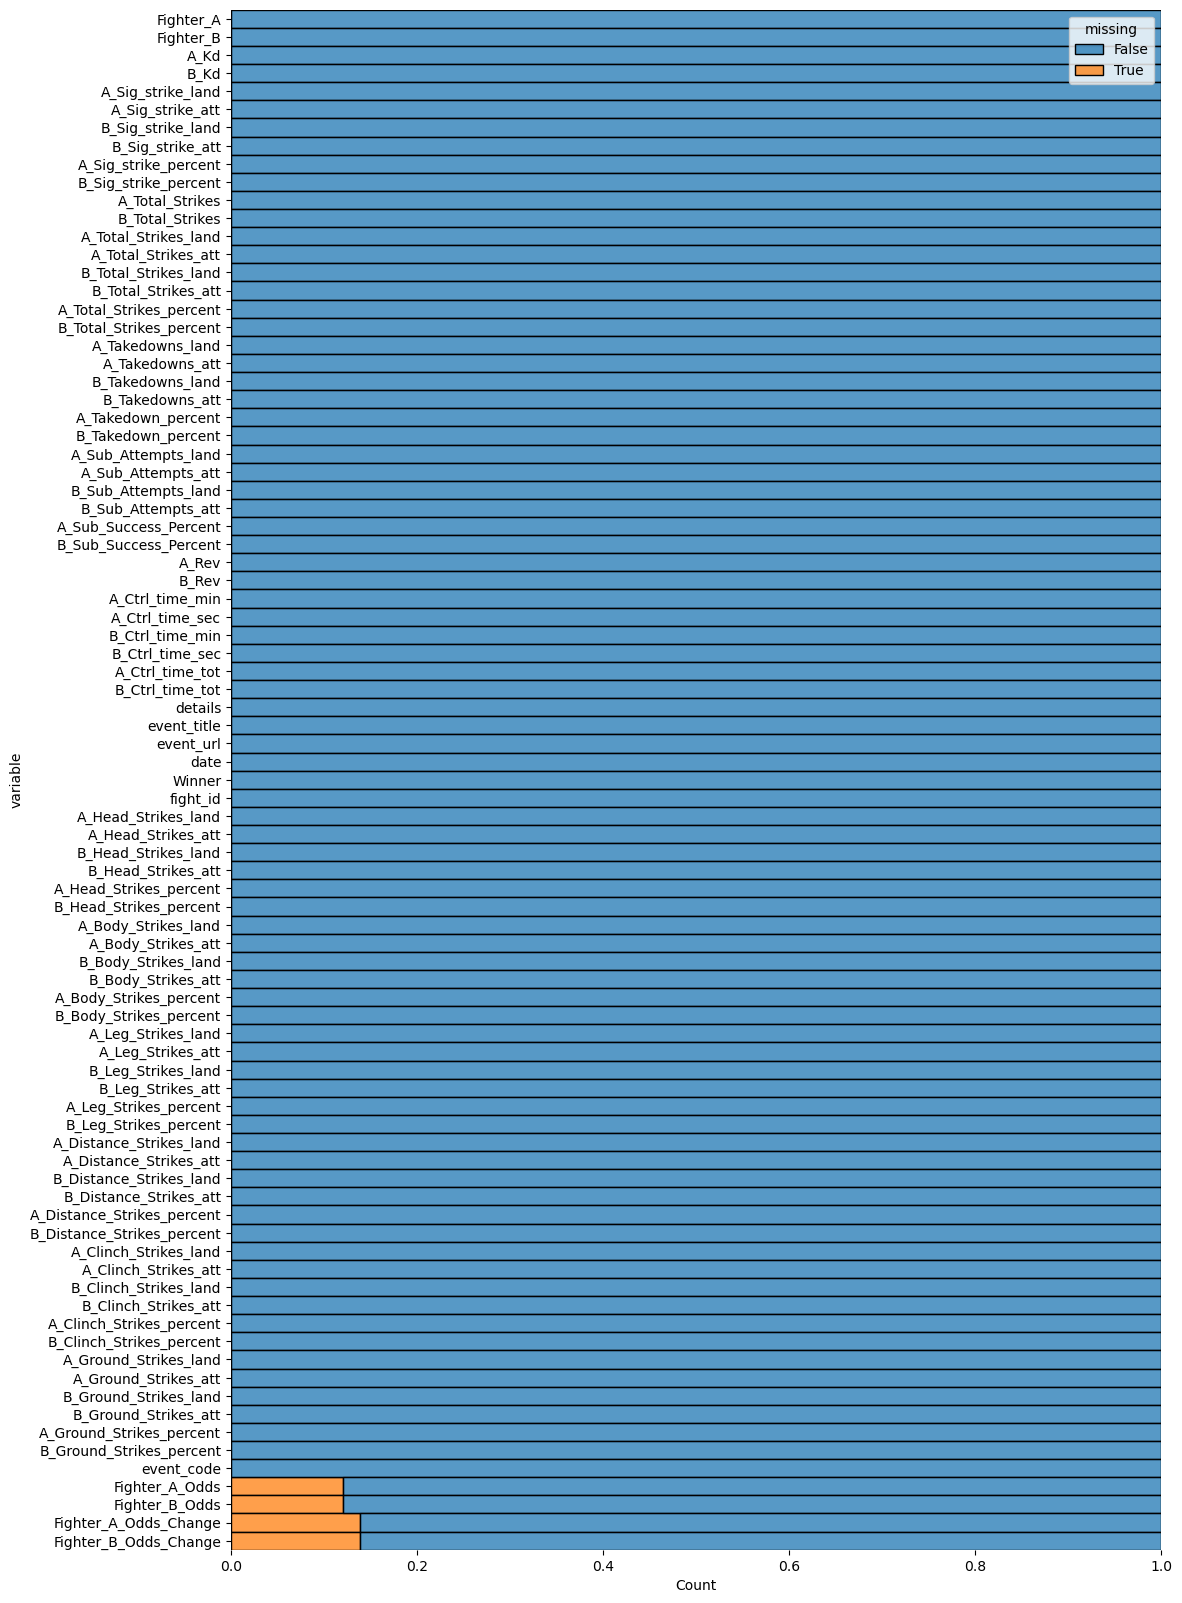

In [242]:
f, ax = plt.subplots(figsize = (12,20))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = double_fights_df.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

### As we know from earlier, we do not have many of these odds because these events were outside of the UFC. Thus, we can drop them. 

In [243]:
double_fights_df = double_fights_df.dropna()
double_fights_df.shape

(8952, 85)

In [244]:
double_fights_df.to_csv('data/final/aggregates/Double_Fights_DF_V1.csv', index=False)

In [245]:
double_fights_df= pd.read_csv('data/final/aggregates/Double_Fights_DF_V1.csv')

In [246]:
double_fights_df.head(3)

Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0     Holly Holm   Irene Aldana     0     0                154   
1     Greg Hardy     Ben Sosoli     0     0                 54   
2  Jared Rosholt  Josh Copeland     0     0                 22   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   
2                45                  9                36   

   A_Sig_strike_percent  B_Sig_strike_percent  ... A_Ground_Strikes_att  \
0                  0.51                  0.37  ...                   28   
1                  0.51                  0.26  ...                    0   
2                  0.48                  0.25  ...                   17   

  B_Ground_Strikes_land  B_Ground_Strikes_att  A_Ground_Strikes_percent  \
0                     0                     0                  0.464286   
1                     0                     0                  0.000000   
2                     0                     0                  0.588235   

   B_Ground_Strikes_percent        event_code  Fighter_A_Odds  Fighter_B_Odds  \
0                       0.0  805ad1801eb26abb          -125.0           105.0   
1                       0.0  3ae10ac4df3df05c          -400.0           325.0   
2                       0.0  f54200f1dfb9b5d4          -310.0           280.0   

   Fighter_A_Odds_Change  Fighter_B_Odds_Change  
0                   39.0                   49.0  
1                  -16.0                  -19.0  
2                   23.0                   -5.0  

[3 rows x 85 columns]

In [247]:
# find all objects in df
double_fights_df.select_dtypes(include=['object']).columns

Index(['Fighter_A', 'Fighter_B', 'A_Total_Strikes', 'B_Total_Strikes',
       'details', 'event_title', 'event_url', 'date', 'Winner', 'fight_id',
       'event_code'],
      dtype='object')

In [248]:
# drop A_Total_Strikes and B_Total_Strikes, they were not meant to be here. 
double_fights_df = double_fights_df.drop(['A_Total_Strikes', 'B_Total_Strikes'], axis=1)


## Add Feature: In-Fight Statistic Differentials

This is 

First make sure that there are no Nans or Infs in the data

In [249]:
#check for nans and infs
double_fights_df.isna().sum()

Fighter_A                0
Fighter_B                0
A_Kd                     0
B_Kd                     0
A_Sig_strike_land        0
                        ..
event_code               0
Fighter_A_Odds           0
Fighter_B_Odds           0
Fighter_A_Odds_Change    0
Fighter_B_Odds_Change    0
Length: 83, dtype: int64

In [250]:
# turn infs to nans
double_fights_df = double_fights_df.replace([np.inf, -np.inf], np.nan)

In [251]:
# calculate differences between in-match stats

for col in double_fights_df.columns:
    if col.startswith('A_'):
        new_col = col.replace('A_', 'Dif_')
        double_fights_df[new_col] = double_fights_df[col] - double_fights_df[col.replace('A_', 'B_')]
    else:
        continue

double_fights_df

Fighter_A            Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           Holly Holm         Irene Aldana     0     0                154   
1           Greg Hardy           Ben Sosoli     0     0                 54   
2        Jared Rosholt        Josh Copeland     0     0                 22   
3     Alistair Overeem        Stefan Struve     0     0                 17   
4        Nordine Taleb        Kyle Prepolec     0     0                 90   
...                ...                  ...   ...   ...                ...   
8947      Marcus Davis           Mike Swick     0     0                 31   
8948     Lucas Martins        Darren Elkins     0     0                 26   
8949   Krzysztof Jotko      Sean Strickland     0     0                 37   
8950     Gleison Tibau        Tony Ferguson     0     0                  2   
8951   Jailton Almeida  Shamil Abdurakhimov     0     0                 45   

      A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0                  301                 69               185   
1                  105                 26                97   
2                   45                  9                36   
3                   25                  2                 5   
4                  201                 52               153   
...                ...                ...               ...   
8947                55                 32                86   
8948                82                 47               154   
8949               196                 84               182   
8950                20                 11                38   
8951                57                  1                 1   

      A_Sig_strike_percent  B_Sig_strike_percent  ...  \
0                     0.51                  0.37  ...   
1                     0.51                  0.26  ...   
2                     0.48                  0.25  ...   
3                     0.68                  0.40  ...   
4                     0.44                  0.33  ...   
...                    ...                   ...  ...   
8947                  0.56                  0.37  ...   
8948                  0.31                  0.30  ...   
8949                  0.18                  0.46  ...   
8950                  0.10                  0.28  ...   
8951                  0.78                  1.00  ...   

      Dif_Leg_Strikes_percent  Dif_Distance_Strikes_land  \
0                    0.191033                         75   
1                   -0.035714                         26   
2                    0.000000                          3   
3                    0.000000                         -2   
4                    0.537838                         38   
...                       ...                        ...   
8947                -0.200000                          7   
8948                -0.200000                         -2   
8949                 0.300000                        -47   
8950                -0.750000                         -6   
8951                 0.500000                          0   

      Dif_Distance_Strikes_att  Dif_Distance_Strikes_percent  \
0                           91                      0.155590   
1                            7                      0.234021   
2                           -4                      0.160714   
3                           -2                     -0.500000   
4                           48                      0.109488   
...                        ...                           ...   
8947                        12                      0.108225   
8948                       -29                      0.057606   
8949                        14                     -0.272763   
8950                       -10                     -0.166667   
8951                         4                     -0.800000   

      Dif_Clinch_Strikes_land  Dif_Clinch_Strikes_att  \
0                          -3                      -3   
1                           2 

In [252]:
# check for infs
double_fights_df.isna().sum()
# only display columns with nans
double_fights_df.isna().sum()[double_fights_df.isna().sum() > 0]

Series([], dtype: int64)

In [253]:
# add difference in odds
double_fights_df['Dif_Odds'] = double_fights_df['Fighter_A_Odds'] - double_fights_df['Fighter_B_Odds']

#### Add Distribution Stat Features

now fights = double_fights_df, for ease

In [254]:
fights = double_fights_df

In [255]:
def get_fighter_running_dist_stats(fighter, date, col_to_get, stat_to_calc):

    # retrieve data for all fights involving the given fighter
    data = fights[(fights['Fighter_A'] == fighter) | (fights['Fighter_B'] == fighter)]

    # convert date strings to datetime objects
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])

    # filter data to only include fights before the given date
    data = data[data['date'] < datey]

    # create an empty dataframe to store fighter data
    fighter_data = pd.DataFrame()

    # retrieve data for fights where the given fighter is Fighter A
    fighterA_df = fights[fights['Fighter_A'] == fighter]
    # retrieve data for fights where the given fighter is Fighter B
    fighterB_df = fights[fights['Fighter_B'] == fighter]

    # select relevant columns from Fighter A data and rename columns for consistency
    fighterA_df = fighterA_df[['date', 'Fighter_A', 'A_' + col_to_get]]
    fighterA_df.rename(columns={'A_' + col_to_get: col_to_get, 'Fighter_A': 'fighter'}, inplace=True)

    # select relevant columns from Fighter B data and rename columns for consistency
    fighterB_df = fighterB_df[['date', 'Fighter_B', 'B_' + col_to_get]]
    fighterB_df.rename(columns={'B_' + col_to_get: col_to_get, 'Fighter_B': 'fighter'}, inplace=True)

    # append Fighter A and Fighter B data to the fighter_data dataframe
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # get the chosen statistic based on the input parameter
    if stat_to_calc == 'mean':
        x = fighter_data[col_to_get].mean()
    elif stat_to_calc == 'std':
        x = fighter_data[col_to_get].std()
    elif stat_to_calc == 'median':
        x = fighter_data[col_to_get].median()  

    # return the chosen statistic
    return x

#### Get Non-specific column names for Feature Creation

In [256]:
# This code creates three lists of column names from a dataframe called 'fights'
# The first list contains column names with 'Dif_' in them
# The second list contains column names that start with 'A_'
# The third list combines the second and first list

dif_cols = [n for n in fights.columns if 'Dif_' in n]
A_cols = [n for n in fights.columns if n.startswith('A_')]
all_metric_cols = A_cols + dif_cols

# This code creates a new dataframe containing the second list of column names without the 'A_' prefix
# It then creates a list of unique column name suffixes

A_cols2 = pd.DataFrame(A_cols)
A_cols2['nonspecific'] = A_cols2[0].str[2:]
the_cols = list(A_cols2['nonspecific'].unique())

In [257]:
the_cols

['Kd',
 'Sig_strike_land',
 'Sig_strike_att',
 'Sig_strike_percent',
 'Total_Strikes_land',
 'Total_Strikes_att',
 'Total_Strikes_percent',
 'Takedowns_land',
 'Takedowns_att',
 'Takedown_percent',
 'Sub_Attempts_land',
 'Sub_Attempts_att',
 'Sub_Success_Percent',
 'Rev',
 'Ctrl_time_min',
 'Ctrl_time_sec',
 'Ctrl_time_tot',
 'Head_Strikes_land',
 'Head_Strikes_att',
 'Head_Strikes_percent',
 'Body_Strikes_land',
 'Body_Strikes_att',
 'Body_Strikes_percent',
 'Leg_Strikes_land',
 'Leg_Strikes_att',
 'Leg_Strikes_percent',
 'Distance_Strikes_land',
 'Distance_Strikes_att',
 'Distance_Strikes_percent',
 'Clinch_Strikes_land',
 'Clinch_Strikes_att',
 'Clinch_Strikes_percent',
 'Ground_Strikes_land',
 'Ground_Strikes_att',
 'Ground_Strikes_percent']

In [258]:
# test get_fighter_running_dist_stats
get_fighter_running_dist_stats('Khabib Nurmagomedov', '2020-01-18', 'Sig_strike_land', 'mean')

55.75

These are split because they were causing problems when running all at once

In [259]:
# Mean First

for col in the_cols:
        fights['A_Rolling_' + col + '_' + 'mean'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, 'mean'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_1.csv', index=False)

In [260]:
for col in the_cols:
    fights['B_Rolling_' + col + '_' + 'mean'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, 'mean'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_2.csv', index=False)

In [261]:
# Now Median
for col in the_cols:
        fights['A_Rolling_' + col + '_' + 'median'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, 'median'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_3.csv', index=False)

In [262]:
# fighter 2 Median
for col in the_cols:
    fights['B_Rolling_' + col + '_' + 'median'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, 'median'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_4.csv', index=False)

In [263]:
# Now Std
for col in the_cols:
    fights['A_Rolling_' + col + '_' + 'std'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, 'std'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_5.csv', index=False)


In [264]:
# fighter 2 Std
for col in the_cols:
    fights['B_Rolling_' + col + '_' + 'std'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, 'std'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_6.csv', index=False)

New Version:

In [265]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2.csv', index=False)

In [266]:
# Load point for fights df
#fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V2.csv')

### Feature: Top-Down Averages (typical UFC Style)

In [267]:
def get_top_down_averages(fighter, date, col_to_get, dataframe):

    # for each column in all_metric_cols, calculate the top-down averages, as opposed to bottom-up
    data = dataframe[(dataframe['Fighter_A'] == fighter) | (dataframe['Fighter_B'] == fighter)]

    # only get fights before the date
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['date'] < datey]

    # fighter could be either fighter A or fighter B
    fighter_data = pd.DataFrame()


    # fighterA df
    fighterA_df = dataframe[dataframe['Fighter_A'] == fighter]
    fighterB_df = dataframe[dataframe['Fighter_B'] == fighter]
    
    # keep only the fighters columns date, FighterA, and the col_to_get, 
    # do same for B, change col names from B to A, and concat
    fighterA_df = fighterA_df[['date', 'Fighter_A', 'A_' + col_to_get]]
    fighterA_df.rename(columns={'A_' + col_to_get: col_to_get, 'Fighter_A': 'fighter'}, inplace=True)
    fighterB_df = fighterB_df[['date', 'Fighter_B', 'B_' + col_to_get]]
    fighterB_df.rename(columns={'B_' + col_to_get: col_to_get, 'Fighter_B': 'fighter'}, inplace=True)
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # append the dataframes on fighter
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # get the average
    tot = fighter_data[col_to_get].sum()
    num = fighter_data[col_to_get].count()
    x = tot / num
    return x

In [268]:
# delete rolling cols from the_cols
the_cols = [n for n in the_cols if 'Rolling' not in n]
the_cols

['Kd',
 'Sig_strike_land',
 'Sig_strike_att',
 'Sig_strike_percent',
 'Total_Strikes_land',
 'Total_Strikes_att',
 'Total_Strikes_percent',
 'Takedowns_land',
 'Takedowns_att',
 'Takedown_percent',
 'Sub_Attempts_land',
 'Sub_Attempts_att',
 'Sub_Success_Percent',
 'Rev',
 'Ctrl_time_min',
 'Ctrl_time_sec',
 'Ctrl_time_tot',
 'Head_Strikes_land',
 'Head_Strikes_att',
 'Head_Strikes_percent',
 'Body_Strikes_land',
 'Body_Strikes_att',
 'Body_Strikes_percent',
 'Leg_Strikes_land',
 'Leg_Strikes_att',
 'Leg_Strikes_percent',
 'Distance_Strikes_land',
 'Distance_Strikes_att',
 'Distance_Strikes_percent',
 'Clinch_Strikes_land',
 'Clinch_Strikes_att',
 'Clinch_Strikes_percent',
 'Ground_Strikes_land',
 'Ground_Strikes_att',
 'Ground_Strikes_percent']

In [269]:


for col in the_cols:
    fights['A_topdown_Avg_' + col ] = fights.apply(lambda row: get_top_down_averages(row['Fighter_A'], row['date'], col, fights), axis=1)

In [270]:
for col in the_cols:
    fights['B_topdown_Avg_' + col ] = fights.apply(lambda row: get_top_down_averages(row['Fighter_B'], row['date'], col, fights), axis=1)

In [271]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V3.csv')

PICK UP HERE 4.16

In [272]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V3.csv')

### Add Opponent Stats

In [273]:
def get_opponent_averages(datafrm, date, col_to_get, fighter):
    col_to_get = 'B_' + col_to_get
    data = datafrm[(datafrm['Fighter_A'] == fighter) | (datafrm['Fighter_B'] == fighter)]
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['date'] < datey]

    fighter_data = pd.DataFrame()

    fighterA_df = datafrm[datafrm['Fighter_A'] == fighter]
    fighterB_df = datafrm[datafrm['Fighter_B'] == fighter]

    # switch A_ and B_ to B_ and A_ in fighterB_df
    fighterB_df.columns = [n.replace('A_', 'C_') if n.startswith('A_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('B_', 'D_') if n.startswith('B_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('C_', 'B_') if n.startswith('C_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('D_', 'A_') if n.startswith('D_') else n for n in fighterB_df.columns]

    # copy fighter_A and fighter_B columns to new dataframe, then switch fighter_A and fighter_B columns

    fighterB_df.rename(columns={'Fighter_A': 'Fighter_A2', 'Fighter_B': 'Fighter_B2'}, inplace=True)
    fighterB_df.rename(columns={'Fighter_B2': 'Fighter_A', 'Fighter_A2': 'Fighter_B'}, inplace=True)

    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # get sum of col to get
    col_sum = fighter_data[col_to_get].sum()
    # get number of fights
    num_fights = len(fighter_data)
    # get average
    avg = col_sum / num_fights

    return avg


In [274]:
# test
get_opponent_averages(fights, '2017-01-01', 'Sig_strike_land', 'Conor McGregor')

37.42857142857143

In [275]:
cols = [n for n in fights.columns if n.startswith('B_')]
cols = [n for n in cols if 'topdown_' not in n]
cols = [n for n in cols if 'Rolling_' not in n]
cols = [n for n in cols if 'Dif_' not in n]

In [276]:
# delete the first 2 characters of each in col
cols2 = pd.DataFrame(cols)
cols2['nonspecific'] = cols2[0].str[2:]
cols2

# get unique values
the_cols = list(cols2['nonspecific'].unique())
the_cols

['Kd',
 'Sig_strike_land',
 'Sig_strike_att',
 'Sig_strike_percent',
 'Total_Strikes_land',
 'Total_Strikes_att',
 'Total_Strikes_percent',
 'Takedowns_land',
 'Takedowns_att',
 'Takedown_percent',
 'Sub_Attempts_land',
 'Sub_Attempts_att',
 'Sub_Success_Percent',
 'Rev',
 'Ctrl_time_min',
 'Ctrl_time_sec',
 'Ctrl_time_tot',
 'Head_Strikes_land',
 'Head_Strikes_att',
 'Head_Strikes_percent',
 'Body_Strikes_land',
 'Body_Strikes_att',
 'Body_Strikes_percent',
 'Leg_Strikes_land',
 'Leg_Strikes_att',
 'Leg_Strikes_percent',
 'Distance_Strikes_land',
 'Distance_Strikes_att',
 'Distance_Strikes_percent',
 'Clinch_Strikes_land',
 'Clinch_Strikes_att',
 'Clinch_Strikes_percent',
 'Ground_Strikes_land',
 'Ground_Strikes_att',
 'Ground_Strikes_percent']

Get Opponent Averages (2-hours runtime)

In [277]:
n=0
# save as we go to intermediate_data, so we don't have to start over if we get an error

# # check to see which columns have already been done
# done_cols = [n for n in os.listdir('data/intermediate_data/') if n.startswith('Opponent_Averages_')]
# done_cols = [n.replace('Opponent_Averages_', '') for n in done_cols]
# done_cols = [n.replace('_.csv', '') for n in done_cols]
# # remove the done columns from the_cols
# the_cols = [n for n in the_cols if n not in done_cols]
# print('Cols Remaining:' + str(len(the_cols)))

# loop through the remaining columns
for col in the_cols:
    try:
        fights['A_Opp_Avg_' + col] = fights.apply(lambda row: get_opponent_averages(fights, row['date'], col, row['Fighter_A']), axis=1)
        fights['B_Opp_Avg_' + col] = fights.apply(lambda row: get_opponent_averages(fights, row['date'], col, row['Fighter_B']), axis=1)
        # save to csv
        fights.to_csv('data/intermediate_data/Opponent_Averages_{}_.csv'.format(col))

        n = n+1
        print(f' {col}, #{n} / {len(cols)} done.')
    except:
        print(f'Error on {col}')
        play_danger()

play_jobs_done()

 Kd, #1 / 35 done.
 Sig_strike_land, #2 / 35 done.
 Sig_strike_att, #3 / 35 done.
 Sig_strike_percent, #4 / 35 done.
 Total_Strikes_land, #5 / 35 done.
 Total_Strikes_att, #6 / 35 done.
 Total_Strikes_percent, #7 / 35 done.
 Takedowns_land, #8 / 35 done.
 Takedowns_att, #9 / 35 done.
 Takedown_percent, #10 / 35 done.
 Sub_Attempts_land, #11 / 35 done.
 Sub_Attempts_att, #12 / 35 done.
 Sub_Success_Percent, #13 / 35 done.
 Rev, #14 / 35 done.
 Ctrl_time_min, #15 / 35 done.
 Ctrl_time_sec, #16 / 35 done.
 Ctrl_time_tot, #17 / 35 done.
 Head_Strikes_land, #18 / 35 done.
 Head_Strikes_att, #19 / 35 done.
 Head_Strikes_percent, #20 / 35 done.
 Body_Strikes_land, #21 / 35 done.
 Body_Strikes_att, #22 / 35 done.
 Body_Strikes_percent, #23 / 35 done.
 Leg_Strikes_land, #24 / 35 done.
 Leg_Strikes_att, #25 / 35 done.
 Leg_Strikes_percent, #26 / 35 done.
 Distance_Strikes_land, #27 / 35 done.
 Distance_Strikes_att, #28 / 35 done.
 Distance_Strikes_percent, #29 / 35 done.
 Clinch_Strikes_land, #3

In [278]:
# load all data in data/intermediate_data, adding columns to fights
for file in os.listdir('data/intermediate_data/'):
    if file.startswith('Opponent_Averages_'):
        print(file)
        df = pd.read_csv('data/intermediate_data/' + file)
        fights_cols = list(fights.columns)
        df_cols = list(df.columns)
        cols_to_add = [n for n in df_cols if n not in fights_cols]
        for col in cols_to_add:
            fights[col] = df[col]
        
fights

Opponent_Averages_Body_Strikes_att_.csv
Opponent_Averages_Body_Strikes_land_.csv
Opponent_Averages_Body_Strikes_percent_.csv
Opponent_Averages_Clinch_Strikes_att_.csv
Opponent_Averages_Clinch_Strikes_land_.csv
Opponent_Averages_Clinch_Strikes_percent_.csv
Opponent_Averages_Ctrl_time_min_.csv
Opponent_Averages_Ctrl_time_sec_.csv
Opponent_Averages_Ctrl_time_tot_.csv
Opponent_Averages_Distance_Strikes_att_.csv
Opponent_Averages_Distance_Strikes_land_.csv
Opponent_Averages_Distance_Strikes_percent_.csv
Opponent_Averages_Ground_Strikes_att_.csv
Opponent_Averages_Ground_Strikes_land_.csv
Opponent_Averages_Ground_Strikes_percent_.csv
Opponent_Averages_Head_Strikes_att_.csv
Opponent_Averages_Head_Strikes_land_.csv
Opponent_Averages_Head_Strikes_percent_.csv
Opponent_Averages_Kd_.csv
Opponent_Averages_Leg_Strikes_att_.csv
Opponent_Averages_Leg_Strikes_land_.csv
Opponent_Averages_Leg_Strikes_percent_.csv
Opponent_Averages_Rev_.csv
Opponent_Averages_Sig_strike_att_.csv
Opponent_Averages_Sig_strik

Unnamed: 0         Fighter_A            Fighter_B  A_Kd  B_Kd  \
0              0        Holly Holm         Irene Aldana     0     0   
1              1        Greg Hardy           Ben Sosoli     0     0   
2              2     Jared Rosholt        Josh Copeland     0     0   
3              3  Alistair Overeem        Stefan Struve     0     0   
4              4     Nordine Taleb        Kyle Prepolec     0     0   
...          ...               ...                  ...   ...   ...   
8947        8947      Marcus Davis           Mike Swick     0     0   
8948        8948     Lucas Martins        Darren Elkins     0     0   
8949        8949   Krzysztof Jotko      Sean Strickland     0     0   
8950        8950     Gleison Tibau        Tony Ferguson     0     0   
8951        8951   Jailton Almeida  Shamil Abdurakhimov     0     0   

      A_Sig_strike_land  A_Sig_strike_att  B_Sig_strike_land  \
0                   154               301                 69   
1                    54               105                 26   
2                    22                45                  9   
3                    17                25                  2   
4                    90               201                 52   
...                 ...               ...                ...   
8947                 31                55                 32   
8948                 26                82                 47   
8949                 37               196                 84   
8950                  2                20                 11   
8951                 45                57                  1   

      B_Sig_strike_att  A_Sig_strike_percent  ...  \
0                  185                  0.51  ...   
1                   97                  0.51  ...   
2                   36                  0.48  ...   
3                    5                  0.68  ...   
4                  153                  0.44  ...   
...                ...                   ...  ...   
8947                86                  0.56  ...   
8948               154                  0.31  ...   
8949               182                  0.18  ...   
8950                38                  0.10  ...   
8951                 1                  0.78  ...   

      B_Opp_Avg_Clinch_Strikes_att  A_Opp_Avg_Clinch_Strikes_percent  \
0                         5.375000                          0.730844   
1                         2.000000                          0.055556   
2                         8.500000                          0.509722   
3                         4.000000                          0.592727   
4                         0.000000                          0.313235   
...                            ...                               ...   
8947                     14.428571                          0.499597   
8948                      7.375000                          0.254731   
8949                      4.333333                          0.437620   
8950                      2.307692                          0.465222   
8951                      9.200000                          0.000000   

      B_Opp_Avg_Clinch_Strikes_percent  A_Opp_Avg_Ground_Strikes_land  \
0                             0.544167                       1.615385   
1                             1.000000                       4.222222   
2                             0.836538                       3.166667   
3                             0.346134                       4.812500   
4                             0.000000                       0.875000   
...                                ...                            ...   
8947                          0.585928                       4.333333   
8948                          0.517431                       7.000000   
8949                          0.462222                       2.000000   
8950                          0.192965                       2.315789   
8951                          0.354835                       0.000000   

     

In [279]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V4.csv')

In [280]:
#fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V4.csv')

In [281]:
# check for nans and show them
fights.isna().sum()

Unnamed: 0                          0
Fighter_A                           0
Fighter_B                           0
A_Kd                                0
B_Kd                                0
                                   ..
A_Opp_Avg_Ground_Strikes_att        0
B_Opp_Avg_Ground_Strikes_att        0
A_Opp_Avg_Ground_Strikes_percent    0
B_Opp_Avg_Ground_Strikes_percent    0
Unnamed: 0.1                        0
Length: 471, dtype: int64

In [282]:
# check for infs and show them
fights[fights == np.inf].sum()

Unnamed: 0                          0.0
Fighter_A                             0
Fighter_B                             0
A_Kd                                0.0
B_Kd                                0.0
                                   ... 
A_Opp_Avg_Ground_Strikes_att        0.0
B_Opp_Avg_Ground_Strikes_att        0.0
A_Opp_Avg_Ground_Strikes_percent    0.0
B_Opp_Avg_Ground_Strikes_percent    0.0
Unnamed: 0.1                        0.0
Length: 471, dtype: object

In [283]:
# show all columns with infs
[fights[col].isna().sum() for col in fights.columns if fights[col].isna().sum() > 0]

[]

### Feature: Rolling Career Stat Differentials

#### 1) Mean (Average)

In [284]:
# get columns with Rolling and Mean
rolling_mean_cols= [n for n in fights.columns if 'Rolling' in n and 'mean' in n]
rolling_mean_cols = pd.DataFrame(rolling_mean_cols)
rolling_mean_cols['nonspecific'] = rolling_mean_cols[0].str[2:]
rmc = rolling_mean_cols['nonspecific'].unique()

In [285]:
for col in rmc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

Unnamed: 0         Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0        Holly Holm   Irene Aldana     0     0                154   
1           1        Greg Hardy     Ben Sosoli     0     0                 54   
2           2     Jared Rosholt  Josh Copeland     0     0                 22   
3           3  Alistair Overeem  Stefan Struve     0     0                 17   
4           4     Nordine Taleb  Kyle Prepolec     0     0                 90   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   
2                45                  9                36   
3                25                  2                 5   
4               201                 52               153   

   A_Sig_strike_percent  ...  Dif_Rolling_Leg_Strikes_percent_mean  \
0                  0.51  ...                             -0.055200   
1                  0.51  ...                             -0.331807   
2                  0.48  ...                              0.091757   
3                  0.68  ...                              0.092005   
4                  0.44  ...                              0.263572   

   Dif_Rolling_Distance_Strikes_land_mean  \
0                              -25.317308   
1                               -3.555556   
2                                1.500000   
3                               -4.937500   
4                              -17.375000   

   Dif_Rolling_Distance_Strikes_att_mean  \
0                             -78.067308   
1                             -45.222222   
2                              -2.166667   
3                             -24.625000   
4                             -71.000000   

   Dif_Rolling_Distance_Strikes_percent_mean  \
0                                   0.095946   
1                                   0.201744   
2                                   0.070912   
3                                   0.087630   
4                                   0.164081   

   Dif_Rolling_Clinch_Strikes_land_mean  Dif_Rolling_Clinch_Strikes_att_mean  \
0                              1.038462                             0.625000   
1                              1.555556                             0.888889   
2                              1.000000                            -0.833333   
3                              6.500000                             7.437500   
4                              0.625000                             0.875000   

   Dif_Rolling_Clinch_Strikes_percent_mean  \
0                                 0.070639   
1                                 0.391534   
2                                -0.091625   
3                                 0.352308   
4                                -0.358631   

   Dif_Rolling_Ground_Strikes_land_mean  Dif_Rolling_Ground_Strikes_att_mean  \
0                              0.923077                             2.692308   
1                              8.000000                            10.000000   
2                             11.333333                            14.500000   
3                              9.312500                            10.625000   
4                              4.375000                             6.250000   

   Dif_Rolling_Ground_Strikes_percent_mean  
0                                -0.033512  
1                                 0.360429  
2                                 0.633919  
3                                 0.231619  
4                                 0.465385  

[5 rows x 506 columns]

#### 2) Median (Average)

In [286]:
rolling_median_cols= [n for n in fights.columns if 'Rolling' in n and 'median' in n]
rolling_median_cols = pd.DataFrame(rolling_median_cols)
rolling_median_cols['nonspecific'] = rolling_median_cols[0].str[2:]
rmc = rolling_median_cols['nonspecific'].unique()

In [287]:
for col in rmc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

Unnamed: 0         Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0        Holly Holm   Irene Aldana     0     0                154   
1           1        Greg Hardy     Ben Sosoli     0     0                 54   
2           2     Jared Rosholt  Josh Copeland     0     0                 22   
3           3  Alistair Overeem  Stefan Struve     0     0                 17   
4           4     Nordine Taleb  Kyle Prepolec     0     0                 90   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   
2                45                  9                36   
3                25                  2                 5   
4               201                 52               153   

   A_Sig_strike_percent  ...  Dif_Rolling_Leg_Strikes_percent_median  \
0                  0.51  ...                                0.073148   
1                  0.51  ...                               -0.285714   
2                  0.48  ...                                0.301587   
3                  0.68  ...                                0.155556   
4                  0.44  ...                                0.253226   

   Dif_Rolling_Distance_Strikes_land_median  \
0                                     -40.5   
1                                      -9.0   
2                                      -3.0   
3                                     -11.5   
4                                     -29.0   

   Dif_Rolling_Distance_Strikes_att_median  \
0                                    -63.0   
1                                    -60.0   
2                                    -17.5   
3                                    -33.5   
4                                    -99.0   

   Dif_Rolling_Distance_Strikes_percent_median  \
0                                     0.070771   
1                                     0.234021   
2                                     0.042236   
3                                     0.142748   
4                                     0.111887   

   Dif_Rolling_Clinch_Strikes_land_median  \
0                                     0.5   
1                                     0.0   
2                                    -2.5   
3                                     3.0   
4                                    -0.5   

   Dif_Rolling_Clinch_Strikes_att_median  \
0                                   -0.5   
1                                   -1.0   
2                                   -4.5   
3                                    2.0   
4                                   -1.0   

   Dif_Rolling_Clinch_Strikes_percent_median  \
0                                   0.062657   
1                                   0.000000   
2                                  -0.019318   
3                                   0.869091   
4                                  -0.416667   

   Dif_Rolling_Ground_Strikes_land_median  \
0                                     0.0   
1                                     0.0   
2                                     9.0   
3                                     5.5   
4                                     1.0   

   Dif_Rolling_Ground_Strikes_att_median  \
0                                   -0.5   
1                                    0.0   
2                                   12.5   
3                                    7.0   
4                                    1.5   

   Dif_Rolling_Ground_Strikes_percent_median  
0                                   0.000000  
1                                   0.000000  
2                                   0.710784  
3                                   0.638889  
4                                   0.566667  

[5 rows x 541 columns]

#### 3) Standard Deviations

In [288]:
rolling_std_cols= [n for n in fights.columns if 'Rolling' in n and 'std' in n]
rolling_std_cols = pd.DataFrame(rolling_std_cols)
rolling_std_cols['nonspecific'] = rolling_std_cols[0].str[2:]
rsc = rolling_std_cols['nonspecific'].unique()
rsc

array(['Rolling_Kd_std', 'Rolling_Sig_strike_land_std',
       'Rolling_Sig_strike_att_std', 'Rolling_Sig_strike_percent_std',
       'Rolling_Total_Strikes_land_std', 'Rolling_Total_Strikes_att_std',
       'Rolling_Total_Strikes_percent_std', 'Rolling_Takedowns_land_std',
       'Rolling_Takedowns_att_std', 'Rolling_Takedown_percent_std',
       'Rolling_Sub_Attempts_land_std', 'Rolling_Sub_Attempts_att_std',
       'Rolling_Sub_Success_Percent_std', 'Rolling_Rev_std',
       'Rolling_Ctrl_time_min_std', 'Rolling_Ctrl_time_sec_std',
       'Rolling_Ctrl_time_tot_std', 'Rolling_Head_Strikes_land_std',
       'Rolling_Head_Strikes_att_std', 'Rolling_Head_Strikes_percent_std',
       'Rolling_Body_Strikes_land_std', 'Rolling_Body_Strikes_att_std',
       'Rolling_Body_Strikes_percent_std', 'Rolling_Leg_Strikes_land_std',
       'Rolling_Leg_Strikes_att_std', 'Rolling_Leg_Strikes_percent_std',
       'Rolling_Distance_Strikes_land_std',
       'Rolling_Distance_Strikes_att_std',
       '

In [289]:
for col in rsc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

Unnamed: 0         Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0        Holly Holm   Irene Aldana     0     0                154   
1           1        Greg Hardy     Ben Sosoli     0     0                 54   
2           2     Jared Rosholt  Josh Copeland     0     0                 22   
3           3  Alistair Overeem  Stefan Struve     0     0                 17   
4           4     Nordine Taleb  Kyle Prepolec     0     0                 90   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   
2                45                  9                36   
3                25                  2                 5   
4               201                 52               153   

   A_Sig_strike_percent  ...  Dif_Rolling_Leg_Strikes_percent_std  \
0                  0.51  ...                             0.085020   
1                  0.51  ...                             0.393218   
2                  0.48  ...                            -0.130793   
3                  0.68  ...                             0.018552   
4                  0.44  ...                            -0.157097   

   Dif_Rolling_Distance_Strikes_land_std  \
0                               4.008505   
1                              19.336714   
2                               7.077737   
3                              -1.373089   
4                              22.633987   

   Dif_Rolling_Distance_Strikes_att_std  \
0                             10.370362   
1                             45.163175   
2                             27.427443   
3                            -22.648652   
4                             44.954349   

   Dif_Rolling_Distance_Strikes_percent_std  \
0                                  0.139367   
1                                  0.132269   
2                                  0.015244   
3                                  0.040913   
4                                  0.206397   

   Dif_Rolling_Clinch_Strikes_land_std  Dif_Rolling_Clinch_Strikes_att_std  \
0                             2.096152                            1.831036   
1                             2.120550                            2.676453   
2                             6.450009                            8.311347   
3                             6.651126                            8.880159   
4                             1.868735                            3.403430   

   Dif_Rolling_Clinch_Strikes_percent_std  \
0                               -0.055872   
1                                0.460108   
2                                0.175367   
3                               -0.086069   
4                                0.126341   

   Dif_Rolling_Ground_Strikes_land_std  Dif_Rolling_Ground_Strikes_att_std  \
0                            -0.279757                            2.395362   
1                            11.950880                           14.414045   
2                             9.939209                           11.611123   
3                            13.311782                           15.318519   
4                             6.907725                           10.142321   

   Dif_Rolling_Ground_Strikes_percent_std  
0                               -0.085893  
1                                0.436579  
2                                0.332215  
3                                0.079562  
4                                0.402486  

[5 rows x 576 columns]

In [290]:
# check for nans, show only if there are any
fights.isna().sum()[fights.isna().sum() > 0]

Series([], dtype: int64)

In [291]:
# check for infs, show only if there are any
fights[fights == np.inf].sum()[fights[fights == np.inf].sum() > 0]

Series([], dtype: object)

In [292]:
# Save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V5.csv')

In [293]:
#Identify columns with missing values
nothere = fights.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]

if len(nothere) > 0:
    cols = nothere.index

    f, ax = plt.subplots(figsize = (12,12))

    sns.despine(f, left=True, bottom=True)
    sns.histplot(
        data = fights[cols].isna().melt(value_name='missing'),
        y= 'variable',
        hue = 'missing',
        multiple = 'fill', ax = ax)

    ax.set_title('Missing Data by Column', fontsize = 20)
    ax.set_xlabel('Count', fontsize = 16)
    ax.set_ylabel('Column', fontsize = 16)
    ax.tick_params(labelsize = 14)

    plt.show()

else:
    print('No missing values')

No missing values


### Feature: UFC.Com Bio Data

In [294]:
fighter_bios = pd.read_csv('data/final/aggregates/All_Fighter_Bios.csv')
fighter_bios.head(1)

Unnamed: 0.1  Unnamed: 0        Status          Place of Birth  \
0             0           1  Not Fighting  Parrish, United States   

  Fighting style   Age  Height  Weight  Octagon Debut  Reach  Leg reach  \
0            MMA  32.0    72.0   155.0  Jul. 30, 2019   78.0       42.0   

      fighter Trains at  
0  Aalon Cruz       NaN

In [295]:
# drop unnamed column
fighter_bios.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [296]:
# Check NaNs

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fighter_bios.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

ax.set_title('Missing Data by Column', fontsize = 20)
ax.set_xlabel('Count', fontsize = 16)

Text(0.5, 0, 'Count')

In [297]:
# What about only Active fighter Nans?
active = fighter_bios.loc[fighter_bios['Status'] == "Active"]
active

Status                Place of Birth Fighting style   Age  Height  \
3     Active        Houston, United States      Muay Thai  32.0    69.0   
11    Active                Rabat, Morocco        Striker  36.0    69.0   
12    Active  Republic of Dagestan, Russia            NaN  33.0    71.0   
13    Active                 Argun, Russia            MMA  32.0    74.0   
14    Active       San Jose, United States            NaN  40.0    65.0   
...      ...                           ...            ...   ...     ...   
2453  Active         Irving, United States      Jiu-Jitsu  37.0    72.0   
2456  Active                 Paris, France            MMA  38.0    68.0   
2458  Active                    Kazakhstan      Freestyle  34.0    64.0   
2460  Active                  Hebei, China      Muay Thai  33.0    64.0   
2461  Active                  USSR, Russia        Striker  31.0    68.0   

      Weight  Octagon Debut  Reach  Leg reach                fighter  \
3      135.0  May. 24, 2014   71.0       40.0         Aaron Phillips   
11     185.5  Jul. 22, 2018   76.0       41.0            Abu Azaitar   
12     170.5  Nov. 09, 2019   72.0       39.5  Abubakar Nurmagomedov   
13     186.0  Sep. 03, 2022   78.0       43.0         Abus Magomedov   
14     125.0  Aug. 29, 2017    NaN        NaN           Adam Antolin   
...      ...            ...    ...        ...                    ...   
2453   185.0  Aug. 29, 2013   75.0       40.0           Zak Cummings   
2456   147.0  Oct. 05, 2019   72.0       42.0            Zarah Fairn   
2458   139.8  Jul. 11, 2020   66.5       36.0     Zhalgas Zhumagulov   
2460   114.8  Aug. 04, 2018   63.0       36.0            Zhang Weili   
2461   167.0  Feb. 15, 2014   68.0       38.5       Zubaira Tukhugov   

                               Trains at  
3                          Headkicks MMA  
11                                   NaN  
12                                   NaN  
13                                   NaN  
14                                   NaN  
...                                  ...  
2453                 Glory MMA & Fitness  
2456                         Olympia MMA  
2458                   American Top Team  
2460                                 NaN  
2461  Tiger Muay Thai - Phuket, Thailand  

[684 rows x 11 columns]

In [298]:
# Check NaNs

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = active.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

ax.set_title('Missing Data by Column', fontsize = 20)
ax.set_xlabel('Count', fontsize = 16)

Text(0.5, 0, 'Count')

#### Dealing with Initial Missing Values

Initial missing values are those such as Age, Status, Fighting Style (categorical variables) which I can impute unknown categories to without much issue. The others (height, weight, reach, etc) must be dealt with after the merge.

In [299]:
# if missing place of birth, replace with 'Unknown'
fighter_bios['Place of Birth'].fillna('Unknown', inplace=True)

# if missing fighting style, replace with 'Unknown'
fighter_bios['Fighting style'].fillna('Unknown', inplace=True)

# if missing Trains at, replace with 'Unknown'
fighter_bios['Trains at'].fillna('Unknown', inplace=True)

# if missing status, replace with 'Unknown'
fighter_bios['Status'].fillna('Unknown', inplace=True)

# if missing age, replace with median
fighter_bios['Age'].fillna(fighter_bios['Age'].median(), inplace=True)

# if missing height, replace with median -- thankfully not many missing, as 
# this is a somewhat important feature
fighter_bios['Height'].fillna(fighter_bios['Height'].median(), inplace=True)

# if missing weight, replace with median -- thankfully not many missing
fighter_bios['Weight'].fillna(fighter_bios['Weight'].median(), inplace=True)

In [300]:
def get_bio_data(fighter, stat):
    try:
        data = fighter_bios[fighter_bios['fighter'] == fighter]
        d = data[stat].values[0]
        d = pd.to_numeric(d)
        return d
    except:
        return nan

In [301]:
# test
weight = get_bio_data('Khabib Nurmagomedov', 'Height')
weight

70.0

In [302]:
fights['A_Height'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Height'), axis=1)
fights['B_Height'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Height'), axis=1)
fights['Dif_Height'] = fights['A_Height'] - fights['B_Height']

In [303]:
fights['A_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Reach'), axis=1)
fights['B_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Reach'), axis=1)
fights['Dif_Reach'] = fights['A_Reach'] - fights['B_Reach']

In [304]:
fights['A_Leg_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Leg reach'), axis=1)
fights['B_Leg_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Leg reach'), axis=1)
fights['Dif_Leg_Reach'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']

<Axes: xlabel='Count', ylabel='variable'>

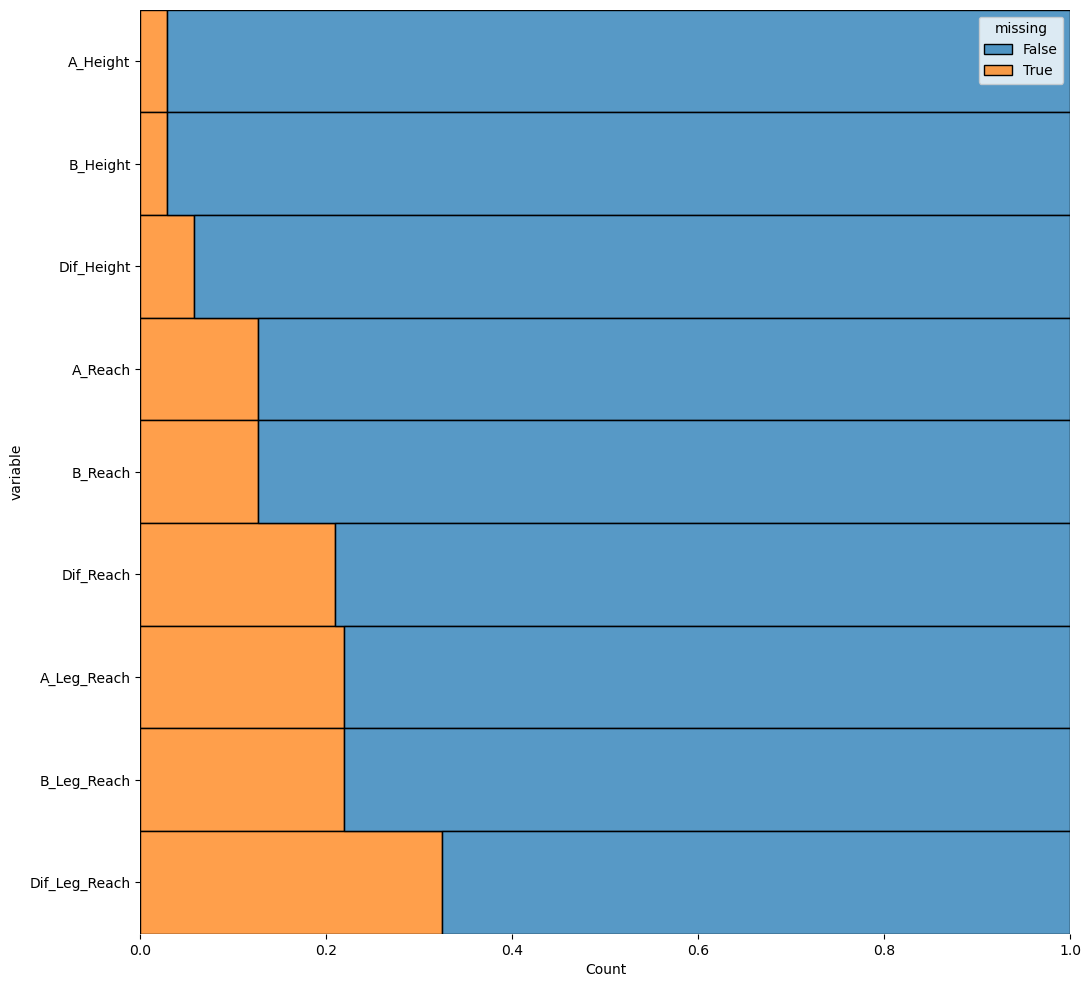

In [305]:
#Identify columns with missing values
nothere = fights.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
cols = nothere.index

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fights[cols].isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

In [306]:
# drop rows missing height data
fights.dropna(subset=['A_Height', 'B_Height'], inplace=True)
len(fights)

8440

In [307]:
# New column indicating if we have the reach data for fighter A
fights['A_Reach_NA'] = fights['A_Reach'].isna()

# New column indicating if we have the reach data for fighter B
fights['B_Reach_NA'] = fights['B_Reach'].isna()

# New column indicating if we have the reach data for either fighter
fights['Reach_NA'] = fights['A_Reach_NA'] | fights['B_Reach_NA']

# New column indicating if we have leg reach data for fighter A
fights['A_Leg_Reach_NA'] = fights['A_Leg_Reach'].isna()

# New column indicating if we have leg reach data for fighter B
fights['B_Leg_Reach_NA'] = fights['B_Leg_Reach'].isna()

# New column indicating if we have leg reach data for either fighter
fights['Leg_Reach_NA'] = fights['A_Leg_Reach_NA'] | fights['B_Leg_Reach_NA']

### Add Weightclass

Then you can break down height, reach, etc... by weightclass, which is in the All_Events_Fights_and_FightUrls file

In [308]:
all_events = pd.read_csv('data/final/events/All_Events_Fights_and_FightUrls.csv')

In [309]:
def find_typical_weightclass(fighter):
    try:
        data = all_events[all_events['Fighter1'] == fighter]
        data2 = all_events[all_events['Fighter2'] == fighter]
        data = pd.concat([data, data2])
        d = data['Weight class'].value_counts().index[0]
        return d
    except:
        return nan


In [310]:
# test
weight = find_typical_weightclass('Khabib Nurmagomedov')
weight

'Lightweight'

In [311]:
fights['A_Typical_Weightclass'] = fights.apply(lambda row: find_typical_weightclass(row['Fighter_A']), axis=1)
fights['B_Typical_Weightclass'] = fights.apply(lambda row: find_typical_weightclass(row['Fighter_B']), axis=1)

In [312]:
fights.head(3)

Unnamed: 0      Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0     Holly Holm   Irene Aldana     0     0                154   
1           1     Greg Hardy     Ben Sosoli     0     0                 54   
2           2  Jared Rosholt  Josh Copeland     0     0                 22   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   
2                45                  9                36   

   A_Sig_strike_percent  ...  B_Leg_Reach  Dif_Leg_Reach  A_Reach_NA  \
0                  0.51  ...         38.5           -0.5       False   
1                  0.51  ...         40.0            4.0       False   
2                  0.48  ...          NaN            NaN       False   

   B_Reach_NA  Reach_NA  A_Leg_Reach_NA  B_Leg_Reach_NA  Leg_Reach_NA  \
0       False     False           False           False         False   
1       False     False           False           False         False   
2       False     False           False            True          True   

   A_Typical_Weightclass  B_Typical_Weightclass  
0   Women's Bantamweight   Women's Bantamweight  
1            Heavyweight            Heavyweight  
2            Heavyweight            Heavyweight  

[3 rows x 593 columns]

In [313]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V6.csv', index=False)

In [314]:
# use fight_id to find weightclass of fight
def find_weightclass(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Weight class'].values[0]
        return d
    except:
        return nan

In [315]:
# test
weight = find_weightclass('ff6c8dab41efcc09')
weight

'Heavyweight'

In [316]:
fights['fight_weightclass'] = fights.apply(lambda row: find_weightclass(row['fight_id']), axis=1)

In [317]:
fights.head(3)

Unnamed: 0      Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0     Holly Holm   Irene Aldana     0     0                154   
1           1     Greg Hardy     Ben Sosoli     0     0                 54   
2           2  Jared Rosholt  Josh Copeland     0     0                 22   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   
2                45                  9                36   

   A_Sig_strike_percent  ...  Dif_Leg_Reach  A_Reach_NA  B_Reach_NA  Reach_NA  \
0                  0.51  ...           -0.5       False       False     False   
1                  0.51  ...            4.0       False       False     False   
2                  0.48  ...            NaN       False       False     False   

   A_Leg_Reach_NA  B_Leg_Reach_NA  Leg_Reach_NA  A_Typical_Weightclass  \
0           False           False         False   Women's Bantamweight   
1           False           False         False            Heavyweight   
2           False            True          True            Heavyweight   

   B_Typical_Weightclass     fight_weightclass  
0   Women's Bantamweight  Women's Bantamweight  
1            Heavyweight           Heavyweight  
2            Heavyweight           Heavyweight  

[3 rows x 594 columns]

In [318]:
fights['A_Fight_in_Typical_Weightclass'] = fights.apply(lambda row: row['A_Typical_Weightclass'] == row['fight_weightclass'], axis=1)
fights['B_Fight_in_Typical_Weightclass'] = fights.apply(lambda row: row['B_Typical_Weightclass'] == row['fight_weightclass'], axis=1)

In [319]:
fights.head(3)

Unnamed: 0      Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0     Holly Holm   Irene Aldana     0     0                154   
1           1     Greg Hardy     Ben Sosoli     0     0                 54   
2           2  Jared Rosholt  Josh Copeland     0     0                 22   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   
2                45                  9                36   

   A_Sig_strike_percent  ...  B_Reach_NA  Reach_NA  A_Leg_Reach_NA  \
0                  0.51  ...       False     False           False   
1                  0.51  ...       False     False           False   
2                  0.48  ...       False     False           False   

   B_Leg_Reach_NA  Leg_Reach_NA  A_Typical_Weightclass  B_Typical_Weightclass  \
0           False         False   Women's Bantamweight   Women's Bantamweight   
1           False         False            Heavyweight            Heavyweight   
2            True          True            Heavyweight            Heavyweight   

      fight_weightclass  A_Fight_in_Typical_Weightclass  \
0  Women's Bantamweight                            True   
1           Heavyweight                            True   
2           Heavyweight                            True   

   B_Fight_in_Typical_Weightclass  
0                            True  
1                            True  
2                            True  

[3 rows x 596 columns]

In [320]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V7.csv', index=False)

### Feature: Method

The main methods of fight finishing are:
- Decision (DEC)
- KO/TKO
- Submission (SUB)


In [321]:
all_events.head(2)

Unnamed: 0.1  Unnamed: 0  W/L  Weight class           Method  Round  Time  \
0             0           0  win   Heavyweight  KO/TKO  Punches      3  4:23   
1             1           1  win  Middleweight            U-DEC      3  5:00   

           Fighter1        Fighter2  F1_Kd  F2_Kd  F1_Str  F2_Str  F1_Td  \
0        Ciryl Gane     Tai Tuivasa      1      1     110      29      0   
1  Robert Whittaker  Marvin Vettori      0      0      74      33      1   

   F2_Td  F1_Sub  F2_Sub  fight_num          event_id  \
0      0       0       0          1  00a905a4a4a2b071   
1      0       0       0          2  00a905a4a4a2b071   

                                          fight_link  
0  http://www.ufcstats.com/fight-details/810c9da0...  
1  http://www.ufcstats.com/fight-details/b8ca1acd...

In [322]:
# split Method into Method and Method Detail
all_events['Method_Primary'] = all_events['Method'].str.split('  ', expand=True)[0]
all_events['Method_Detail'] = all_events['Method'].str.split('  ', expand=True)[1]
all_events.head(3)

Unnamed: 0.1  Unnamed: 0  W/L  Weight class           Method  Round  Time  \
0             0           0  win   Heavyweight  KO/TKO  Punches      3  4:23   
1             1           1  win  Middleweight            U-DEC      3  5:00   
2             2           2  win  Middleweight            U-DEC      3  5:00   

             Fighter1         Fighter2  F1_Kd  ...  F2_Str  F1_Td  F2_Td  \
0          Ciryl Gane      Tai Tuivasa      1  ...      29      0      0   
1    Robert Whittaker   Marvin Vettori      0  ...      33      1      0   
2  Nassourdine Imavov  Joaquin Buckley      0  ...      46      2      0   

   F1_Sub  F2_Sub  fight_num          event_id  \
0       0       0          1  00a905a4a4a2b071   
1       0       0          2  00a905a4a4a2b071   
2       2       0          3  00a905a4a4a2b071   

                                          fight_link Method_Primary  \
0  http://www.ufcstats.com/fight-details/810c9da0...         KO/TKO   
1  http://www.ufcstats.com/fight-details/b8ca1acd...          U-DEC   
2  http://www.ufcstats.com/fight-details/20f316f9...          U-DEC   

  Method_Detail  
0       Punches  
1          None  
2          None  

[3 rows x 22 columns]

In [323]:
def get_method(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Method_Primary'].values[0]
        return d
    except:
        return nan

In [324]:
def get_details(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Method_Detail'].values[0]
        return d
    except:
        return nan

In [325]:
# test
method = get_method('ff6c8dab41efcc09')
method

'U-DEC'

In [326]:
fights['InFightData__Method_Primary'] = fights.apply(lambda row: get_method(row['fight_id']), axis=1)
fights['InFightData__Method_Detail'] = fights.apply(lambda row: get_details(row['fight_id']), axis=1)

### Feature: Round & Time

In [327]:
def get_round_time(fight_id, round_or_time):
    try: 
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        if round_or_time == 'round':
            d = data['Round'].values[0]
        elif round_or_time == 'time':
            d = data['Time'].values[0]
        return d
    except:
        return nan

In [328]:
# test
round = get_round_time('ff6c8dab41efcc09', 'round')
round

3

In [329]:
fights['InFightData__Round'] = fights.apply(lambda row: get_round_time(row['fight_id'], 'round'), axis=1)
fights['InFightData__Time'] = fights.apply(lambda row: get_round_time(row['fight_id'], 'time'), axis=1)

In [330]:
fights.head(3)

Unnamed: 0      Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0     Holly Holm   Irene Aldana     0     0                154   
1           1     Greg Hardy     Ben Sosoli     0     0                 54   
2           2  Jared Rosholt  Josh Copeland     0     0                 22   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   
2                45                  9                36   

   A_Sig_strike_percent  ...  Leg_Reach_NA  A_Typical_Weightclass  \
0                  0.51  ...         False   Women's Bantamweight   
1                  0.51  ...         False            Heavyweight   
2                  0.48  ...          True            Heavyweight   

   B_Typical_Weightclass     fight_weightclass  \
0   Women's Bantamweight  Women's Bantamweight   
1            Heavyweight           Heavyweight   
2            Heavyweight           Heavyweight   

   A_Fight_in_Typical_Weightclass  B_Fight_in_Typical_Weightclass  \
0                            True                            True   
1                            True                            True   
2                            True                            True   

   InFightData__Method_Primary  InFightData__Method_Detail  \
0                        U-DEC                        None   
1                   Overturned                        None   
2                       KO/TKO                     Punches   

   InFightData__Round  InFightData__Time  
0                   5               5:00  
1                   3               5:00  
2                   3               3:12  

[3 rows x 600 columns]

In [331]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V8.csv', index=False)

: 

: 

### Dealing with Remaining Missing Values

In [ ]:
# get missing values, sorted by column
missing_values = fights.isnull().sum().sort_values(ascending=False)
# get rid of 0 values
missing_values = missing_values[missing_values > 0]
# get percentage of missing values
missing_values = missing_values / len(fights) * 100
missing_values

InFightData__Method_Detail    51.309524
Dif_Leg_Reach                 28.428571
A_Leg_Reach                   19.750000
B_Leg_Reach                   19.750000
Dif_Reach                     16.214286
A_Reach                       10.119048
B_Reach                       10.119048
B_Typical_Weightclass          0.095238
A_Typical_Weightclass          0.095238
dtype: float64

In [ ]:
# replace nan values in "InFightData__Method_Detail" with "None"
fights['InFightData__Method_Detail'] = fights['InFightData__Method_Detail'].fillna('None')

In [ ]:
# replace nan values in Typical Weightclass with current weightclass
fights['A_Typical_Weightclass'] = fights.apply(lambda row: row['fight_weightclass'] if pd.isnull(row['A_Typical_Weightclass']) else row['A_Typical_Weightclass'], axis=1)
fights['B_Typical_Weightclass'] = fights.apply(lambda row: row['fight_weightclass'] if pd.isnull(row['B_Typical_Weightclass']) else row['B_Typical_Weightclass'], axis=1)

In [ ]:
# get median reach per height
reach_by_height = fights.groupby('A_Height')['A_Reach'].median()
reach_by_height

A_Height
0.0      NaN
60.0    60.0
61.0    62.0
61.5    62.0
62.0    64.0
62.5    62.5
63.0    64.5
63.5    65.5
64.0    65.0
64.5    68.0
65.0    66.0
66.0    67.0
66.5    66.0
67.0    69.0
67.5    69.0
68.0    70.0
68.5    71.0
69.0    71.0
70.0    72.0
70.5    76.0
71.0    73.0
71.5    73.0
72.0    74.0
72.5    78.0
73.0    75.0
73.5    77.0
74.0    75.5
74.5    78.0
75.0    77.0
75.5    76.0
76.0    80.0
77.0    79.0
78.0    81.0
78.5    79.0
79.0    80.0
80.0    80.0
84.0    84.5
Name: A_Reach, dtype: float64

In [ ]:
# replace nan values in reach with median reach per height
fights['A_Reach'] = fights.apply(lambda row: reach_by_height[row['A_Height']] if pd.isnull(row['A_Reach']) else row['A_Reach'], axis=1)
fights['B_Reach'] = fights.apply(lambda row: reach_by_height[row['B_Height']] if pd.isnull(row['B_Reach']) else row['B_Reach'], axis=1)

In [ ]:
# get median leg reach per height
leg_reach_by_height = fights.groupby('A_Height')['A_Leg_Reach'].median()
leg_reach_by_height

A_Height
0.0      NaN
60.0    34.0
61.0    35.0
61.5    35.0
62.0    36.0
62.5    38.0
63.0    36.0
63.5    38.0
64.0    37.0
64.5    38.0
65.0    37.5
66.0    38.0
66.5    38.0
67.0    38.0
67.5    38.0
68.0    39.0
68.5    38.5
69.0    39.5
70.0    40.0
70.5    42.0
71.0    40.5
71.5    43.0
72.0    41.0
72.5    40.0
73.0    41.5
73.5    41.0
74.0    42.0
74.5    44.0
75.0    43.5
75.5    43.0
76.0    44.0
77.0    46.0
78.0    44.5
78.5    45.5
79.0    47.5
80.0     NaN
84.0    44.0
Name: A_Leg_Reach, dtype: float64

In [ ]:
# replace nan values in leg reach with median leg reach per height
fights['A_Leg_Reach'] = fights.apply(lambda row: leg_reach_by_height[row['A_Height']] if pd.isnull(row['A_Leg_Reach']) else row['A_Leg_Reach'], axis=1)
fights['B_Leg_Reach'] = fights.apply(lambda row: leg_reach_by_height[row['B_Height']] if pd.isnull(row['B_Leg_Reach']) else row['B_Leg_Reach'], axis=1)

In [ ]:
# recalculate leg reach dif and reach dif
fights['A_Leg_Reach_Dif'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']
fights['A_Reach_Dif'] = fights['A_Reach'] - fights['B_Reach']

In [ ]:
fights.dtypes[-40:]

Dif_Rolling_Body_Strikes_att_std            float64
Dif_Rolling_Body_Strikes_percent_std        float64
Dif_Rolling_Leg_Strikes_land_std            float64
Dif_Rolling_Leg_Strikes_att_std             float64
Dif_Rolling_Leg_Strikes_percent_std         float64
Dif_Rolling_Distance_Strikes_land_std       float64
Dif_Rolling_Distance_Strikes_att_std        float64
Dif_Rolling_Distance_Strikes_percent_std    float64
Dif_Rolling_Clinch_Strikes_land_std         float64
Dif_Rolling_Clinch_Strikes_att_std          float64
Dif_Rolling_Clinch_Strikes_percent_std      float64
Dif_Rolling_Ground_Strikes_land_std         float64
Dif_Rolling_Ground_Strikes_att_std          float64
Dif_Rolling_Ground_Strikes_percent_std      float64
A_Height                                    float64
B_Height                                    float64
Dif_Height                                  float64
A_Reach                                     float64
B_Reach                                     float64
Dif_Reach   

In [ ]:
# get missing values, sorted by column
missing_values = fights.isnull().sum().sort_values(ascending=False)
# get rid of 0 values
missing_values = missing_values[missing_values > 0]
# get percentage of missing values
missing_values = missing_values / len(fights) * 100
missing_values

Dif_Leg_Reach      28.428571
Dif_Reach          16.214286
A_Leg_Reach_Dif     0.690476
A_Reach_Dif         0.619048
A_Leg_Reach         0.357143
B_Leg_Reach         0.357143
A_Reach             0.321429
B_Reach             0.321429
dtype: float64

In [ ]:
# get median reach per weightclass
reach_by_weightclass = fights.groupby('fight_weightclass')['A_Reach'].median()
reach_by_weightclass

fight_weightclass
Bantamweight             69.00
Catch Weight             71.00
Featherweight            71.00
Flyweight                66.00
Heavyweight              78.00
Light Heavyweight        76.00
Lightweight              71.00
Middleweight             75.00
Welterweight             74.00
Women's Bantamweight     67.50
Women's Featherweight    68.50
Women's Flyweight        66.25
Women's Strawweight      64.00
Name: A_Reach, dtype: float64

In [ ]:
# get median height per weightclass
height_by_weightclass = fights.groupby('fight_weightclass')['A_Height'].median()
height_by_weightclass

fight_weightclass
Bantamweight             67.00
Catch Weight             70.00
Featherweight            69.00
Flyweight                65.00
Heavyweight              75.00
Light Heavyweight        74.00
Lightweight              70.00
Middleweight             73.00
Welterweight             71.25
Women's Bantamweight     66.00
Women's Featherweight    67.00
Women's Flyweight        66.00
Women's Strawweight      64.00
Name: A_Height, dtype: float64

In [ ]:
# replace nan values in "A_Reach" with median for weight class
fights['A_Reach'] = fights.apply(lambda row: reach_by_weightclass[row['fight_weightclass']] if pd.isnull(row['A_Reach']) else row['A_Reach'], axis=1)
fights['B_Reach'] = fights.apply(lambda row: reach_by_weightclass[row['fight_weightclass']] if pd.isnull(row['B_Reach']) else row['B_Reach'], axis=1)

# replace nan values in "A_Height" with median for weight class
fights['A_Height'] = fights.apply(lambda row: height_by_weightclass[row['fight_weightclass']] if pd.isnull(row['A_Height']) else row['A_Height'], axis=1)
fights['B_Height'] = fights.apply(lambda row: height_by_weightclass[row['fight_weightclass']] if pd.isnull(row['B_Height']) else row['B_Height'], axis=1)


In [ ]:
# Once again, re-run the Difs
fights['Dif_Leg_Reach'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']
fights['Dif_Reach'] = fights['A_Reach'] - fights['B_Reach']

In [ ]:
# get missing
missing_values = fights.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(fights) * 100
missing_values

Dif_Leg_Reach      0.690476
A_Leg_Reach_Dif    0.690476
A_Reach_Dif        0.619048
B_Leg_Reach        0.357143
A_Leg_Reach        0.357143
dtype: float64

In [ ]:
# drop nan values
fights = fights.dropna()


In [ ]:
# drop A_Reach_Dif and A_Leg_Reach_Dif
fights = fights.drop(['A_Reach_Dif', 'A_Leg_Reach_Dif'], axis=1)

### Feature: Size Ratios

In [ ]:
fights['A_Ape_Index'] = fights['A_Reach'] / fights['A_Height']
fights['B_Ape_Index'] = fights['B_Reach'] / fights['B_Height']

# Leg_Index = Leg_Reach / Height
fights['A_Leg_Index'] = fights['A_Leg_Reach'] / fights['A_Height']
fights['B_Leg_Index'] = fights['B_Leg_Reach'] / fights['B_Height']

# Leg_to_Wing_Index = Leg_Reach / Reach
fights['A_Leg_to_Wing_Index'] = fights['A_Leg_Reach'] / fights['A_Reach']
fights['B_Leg_to_Wing_Index'] = fights['B_Leg_Reach'] / fights['B_Reach']

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V9.csv', index=False)

### Feature: Winner

In [ ]:
# split Winner columns by " 
fights['Winner'] = fights['Winner'].str.split('"').str[0].str.strip()
fights.head(2)

Unnamed: 0   Fighter_A     Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0  Holly Holm  Irene Aldana     0     0                154   
1           1  Greg Hardy    Ben Sosoli     0     0                 54   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   

   A_Sig_strike_percent  ...  InFightData__Method_Primary  \
0                  0.51  ...                        U-DEC   
1                  0.51  ...                   Overturned   

   InFightData__Method_Detail  InFightData__Round  InFightData__Time  \
0                        None                   5               5:00   
1                        None                   3               5:00   

   A_Ape_Index  B_Ape_Index  A_Leg_Index  B_Leg_Index  A_Leg_to_Wing_Index  \
0     1.014706     0.992754     0.558824     0.557971             0.550725   
1     1.038961     1.006944     0.571429     0.555556             0.550000   

   B_Leg_to_Wing_Index  
0             0.562044  
1             0.551724  

[2 rows x 606 columns]

In [ ]:
# add column "win?", if column winner is equal to fighter_A
fights['win?'] = fights.apply(lambda row: 1 if row['Winner'] == row['Fighter_A'] else 0, axis=1)
fights.head(30)

Unnamed: 0          Fighter_A         Fighter_B  A_Kd  B_Kd  \
0            0         Holly Holm      Irene Aldana     0     0   
1            1         Greg Hardy        Ben Sosoli     0     0   
2            2      Jared Rosholt     Josh Copeland     0     0   
3            3   Alistair Overeem     Stefan Struve     0     0   
4            4      Nordine Taleb     Kyle Prepolec     0     0   
5            5         Matt Brown       Jordan Mein     0     1   
6            6     Beneil Dariush  Rashid Magomedov     0     0   
7            7          Andy Ogle       Cole Miller     0     0   
8            8       Urijah Faber  Michael McDonald     1     0   
10          10       Li Jingliang       Dhiego Lima     1     0   
11          11         Joe Lauzon       Marcin Held     0     0   
12          12       Chad Laprise    Thibault Gouti     2     0   
13          13          Pat Barry     Stefan Struve     0     0   
14          14  Alexandre Pantoja      Eric Shelton     0     0   
15          15         Holly Holm     Bethe Correia     1     0   
18          18  Katlyn Chookagian       Jessica Eye     0     0   
19          19        Chas Skelly     Maximo Blanco     0     0   
20          20      Anthony Smith       Jimmy Crute     0     0   
21          21        Jimi Manuwa    Corey Anderson     1     0   
22          22      John Teixeira        Hugo Viana     0     0   
23          23         Roy Nelson       Dave Herman     1     0   
24          24      Chris Camozzi        Tom Watson     0     0   
25          25       Cheick Kongo     Travis Browne     0     0   
26          26         Phil Hawes      Kyle Daukaus     0     0   
30          30      Thales Leites   Jack Hermansson     0     0   
32          32      Carlos Felipe       Justin Tafa     0     0   
33          33        Tim Elliott    Brandon Royval     0     0   
34          34      Thiago Moises    Kurt Holobaugh     0     0   
35          35  Raquel Pennington      Irene Aldana     0     0   
36          36      Warlley Alves   Colby Covington     0     0   

    A_Sig_strike_land  A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0                 154               301                 69               185   
1                  54               105                 26                97   
2                  22                45                  9                36   
3                  17                25                  2                 5   
4                  90               201                 52               153   
5                  40                84                 24                58   
6                  60               120                 41                78   
7                  27                51                 21                40   
8                  29                46                  9                27   
10                 13                39                  6                16   
11                 20                62                 23                78   
12                 17                35                  4                16   
13                 30                45                 31                82   
14                 37                99                 32                93   
15                 25                53                 15                65   
18                 65               201                 81               190   
19                  1                 1                  0                 1   
20                 26                39                 18                35   
21                  6                13                  6                27   
22                 52               140                 65               141   
23                  2                 4                  3                 8   
24                 87               146                 82               140   
25                 58               109                 22                75   
26    

In [ ]:
# check number of wins vs losses
fights['win?'].value_counts()

1    4171
0    4171
Name: win?, dtype: int64

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V10.csv', index=False)

### Feature: Favorite

In [ ]:
# get columns in fight df with odds in the name
odds_columns = [col for col in fights.columns if 'Odds' in col]
odds_columns

['Fighter_A_Odds',
 'Fighter_B_Odds',
 'Fighter_A_Odds_Change',
 'Fighter_B_Odds_Change',
 'Dif_Odds']

In [ ]:
fights['favorite?'] = np.where(fights['Fighter_A_Odds'] < fights['Fighter_B_Odds'], 1, 0)
fights['favorite?'].value_counts()

0    4244
1    4098
Name: favorite?, dtype: int64

In [ ]:
fight_check_cols = ['Fighter_A', 'Fighter_B', 'Winner', 'win?', 'Fighter_A_Odds', 'Fighter_B_Odds','favorite?']
fights[fight_check_cols].head(30)

Fighter_A         Fighter_B             Winner  win?  \
0          Holly Holm      Irene Aldana         Holly Holm     1   
1          Greg Hardy        Ben Sosoli         Ben Sosoli     0   
2       Jared Rosholt     Josh Copeland      Jared Rosholt     1   
3    Alistair Overeem     Stefan Struve   Alistair Overeem     1   
4       Nordine Taleb     Kyle Prepolec      Nordine Taleb     1   
5          Matt Brown       Jordan Mein         Matt Brown     1   
6      Beneil Dariush  Rashid Magomedov     Beneil Dariush     1   
7           Andy Ogle       Cole Miller        Cole Miller     0   
8        Urijah Faber  Michael McDonald       Urijah Faber     1   
10       Li Jingliang       Dhiego Lima       Li Jingliang     1   
11         Joe Lauzon       Marcin Held         Joe Lauzon     1   
12       Chad Laprise    Thibault Gouti       Chad Laprise     1   
13          Pat Barry     Stefan Struve      Stefan Struve     0   
14  Alexandre Pantoja      Eric Shelton  Alexandre Pantoja     1   
15         Holly Holm     Bethe Correia         Holly Holm     1   
18  Katlyn Chookagian       Jessica Eye        Jessica Eye     0   
19        Chas Skelly     Maximo Blanco        Chas Skelly     1   
20      Anthony Smith       Jimmy Crute      Anthony Smith     1   
21        Jimi Manuwa    Corey Anderson        Jimi Manuwa     1   
22      John Teixeira        Hugo Viana         Hugo Viana     0   
23         Roy Nelson       Dave Herman         Roy Nelson     1   
24      Chris Camozzi        Tom Watson      Chris Camozzi     1   
25       Cheick Kongo     Travis Browne      Travis Browne     0   
26         Phil Hawes      Kyle Daukaus         Phil Hawes     1   
30      Thales Leites   Jack Hermansson    Jack Hermansson     0   
32      Carlos Felipe       Justin Tafa      Carlos Felipe     1   
33        Tim Elliott    Brandon Royval     Brandon Royval     0   
34      Thiago Moises    Kurt Holobaugh      Thiago Moises     1   
35  Raquel Pennington      Irene Aldana  Raquel Pennington     1   
36      Warlley Alves   Colby Covington      Warlley Alves     1   

    Fighter_A_Odds  Fighter_B_Odds  favorite?  
0           -125.0           105.0          1  
1           -400.0           325.0          1  
2           -310.0           280.0          1  
3           -200.0           185.0          1  
4           -420.0           335.0          1  
5            290.0          -320.0          0  
6           -115.0          -105.0          1  
7            185.0          -200.0          0  
8           -150.0           130.0          1  
10           130.0          -140.0          0  
11          -140.0           120.0          1  
12          -320.0           290.0          1  
13          -165.0           155.0          1  
14           100.0          -120.0          0  
15          -570.0           435.0          1  
18          -235.0           195.0          1  
19          -150.0           130.0          1  
20           210.0          -250.0          0  
21          -145.0           125.0          1  
22           185.0          -200.0          0  
23          -162.0           152.0          1  
24          -135.0           115.0          1  
25          -178.0           167.0          1  
26           132.0          -152.0          0  
30           110.0          -130.0          0  
32          -185.0           160.0          1  
33          -138.0           118.0          1  
34          -125.0           105.0          1  
35           115.0          -135.0          0  
36           105.0          -125.0          0

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V11.csv', index=False)

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V11.csv')

In [ ]:
fights.head()

Unnamed: 0         Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0        Holly Holm   Irene Aldana     0     0                154   
1           1        Greg Hardy     Ben Sosoli     0     0                 54   
2           2     Jared Rosholt  Josh Copeland     0     0                 22   
3           3  Alistair Overeem  Stefan Struve     0     0                 17   
4           4     Nordine Taleb  Kyle Prepolec     0     0                 90   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   
2                45                  9                36   
3                25                  2                 5   
4               201                 52               153   

   A_Sig_strike_percent  ...  InFightData__Round  InFightData__Time  \
0                  0.51  ...                   5               5:00   
1                  0.51  ...                   3               5:00   
2                  0.48  ...                   3               3:12   
3                  0.68  ...                   1               4:13   
4                  0.44  ...                   3               5:00   

   A_Ape_Index  B_Ape_Index  A_Leg_Index  B_Leg_Index  A_Leg_to_Wing_Index  \
0     1.014706     0.992754     0.558824     0.557971             0.550725   
1     1.038961     1.006944     0.571429     0.555556             0.550000   
2     1.013514     1.027397     0.554054     0.568493             0.546667   
3     1.052632     1.005952     0.585526     0.523810             0.556250   
4     1.020548     1.000000     0.575342     0.557143             0.563758   

   B_Leg_to_Wing_Index  win?  favorite?  
0             0.562044     1          1  
1             0.551724     0          1  
2             0.553333     1          1  
3             0.520710     1          1  
4             0.557143     1          1  

[5 rows x 608 columns]

### Features: Win/Loss Details

In [ ]:
# get columns with date in the name
date_columns = [col for col in fights.columns if 'date' in col]
date_columns

['date']

In [ ]:
# add a formatted date column
fights['datetime'] = pd.to_datetime(fights['date'])
fights['date_formatted'] = fights['datetime'].dt.date

In [ ]:
fights

Unnamed: 0         Fighter_A            Fighter_B  A_Kd  B_Kd  \
0              0        Holly Holm         Irene Aldana     0     0   
1              1        Greg Hardy           Ben Sosoli     0     0   
2              2     Jared Rosholt        Josh Copeland     0     0   
3              3  Alistair Overeem        Stefan Struve     0     0   
4              4     Nordine Taleb        Kyle Prepolec     0     0   
...          ...               ...                  ...   ...   ...   
8337        8947      Marcus Davis           Mike Swick     0     0   
8338        8948     Lucas Martins        Darren Elkins     0     0   
8339        8949   Krzysztof Jotko      Sean Strickland     0     0   
8340        8950     Gleison Tibau        Tony Ferguson     0     0   
8341        8951   Jailton Almeida  Shamil Abdurakhimov     0     0   

      A_Sig_strike_land  A_Sig_strike_att  B_Sig_strike_land  \
0                   154               301                 69   
1                    54               105                 26   
2                    22                45                  9   
3                    17                25                  2   
4                    90               201                 52   
...                 ...               ...                ...   
8337                 31                55                 32   
8338                 26                82                 47   
8339                 37               196                 84   
8340                  2                20                 11   
8341                 45                57                  1   

      B_Sig_strike_att  A_Sig_strike_percent  ...  A_Ape_Index  B_Ape_Index  \
0                  185                  0.51  ...     1.014706     0.992754   
1                   97                  0.51  ...     1.038961     1.006944   
2                   36                  0.48  ...     1.013514     1.027397   
3                    5                  0.68  ...     1.052632     1.005952   
4                  153                  0.44  ...     1.020548     1.000000   
...                ...                   ...  ...          ...          ...   
8337                86                  0.56  ...     1.000000     1.027397   
8338               154                  0.31  ...     1.000000     1.014286   
8339               182                  0.18  ...     1.054795     1.041096   
8340                38                  0.10  ...     1.028986     1.077465   
8341                 1                  0.78  ...     1.053333     1.013333   

      A_Leg_Index  B_Leg_Index  A_Leg_to_Wing_Index  B_Leg_to_Wing_Index  \
0        0.558824     0.557971             0.550725             0.562044   
1        0.571429     0.555556             0.550000             0.551724   
2        0.554054     0.568493             0.546667             0.553333   
3        0.585526     0.523810             0.556250             0.520710   
4        0.575342     0.557143             0.563758             0.557143   
...           ...          ...                  ...                  ...   
8337     0.571429     0.568493             0.571429             0.553333   
8338     0.569444     0.557143             0.569444             0.549296   
8339     0.561644     0.568493             0.532468             0.546053   
8340     0.565217     0.570423             0.549296             0.529412   
8341     0.580000     0.553333             0.550633             0.546053   

      win?  favorite?   datetime  date_formatted  
0        1          1 2020-10-03      2020-10-03  
1        0          1 2019-10-18      2019-10-18  
2        1          1 2015-03-14      2015-03-14  
3        1          1 2014-12-13      2014-12-13  
4        1          1 2019-05-04      2019-05-04  
...    ...        ...        ...             ...  
8337     0          0 2008-06-07      2008-06-07  
8338     0          0 2014-10-25      2014-10-25  
8339     0          0 2021-05-01      2021-05-01  
8340     0  

In [ ]:
def get_number_UFC_fights(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return len(data)


In [ ]:
get_number_UFC_fights('Conor McGregor', '2020-01-01')

10

In [ ]:
fights['A_Total_UFC_Fights'] = fights.apply(lambda row: get_number_UFC_fights(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Total_UFC_Fights'] = fights.apply(lambda row: get_number_UFC_fights(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_Total_UFC_Fights'] = fights['A_Total_UFC_Fights'] - fights['B_Total_UFC_Fights']

In [ ]:
fights.head(3)

Unnamed: 0      Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0     Holly Holm   Irene Aldana     0     0                154   
1           1     Greg Hardy     Ben Sosoli     0     0                 54   
2           2  Jared Rosholt  Josh Copeland     0     0                 22   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   
2                45                  9                36   

   A_Sig_strike_percent  ...  B_Leg_Index  A_Leg_to_Wing_Index  \
0                  0.51  ...     0.557971             0.550725   
1                  0.51  ...     0.555556             0.550000   
2                  0.48  ...     0.568493             0.546667   

   B_Leg_to_Wing_Index  win?  favorite?   datetime  date_formatted  \
0             0.562044     1          1 2020-10-03      2020-10-03   
1             0.551724     0          1 2019-10-18      2019-10-18   
2             0.553333     1          1 2015-03-14      2015-03-14   

   A_Total_UFC_Fights  B_Total_UFC_Fights  Dif_Total_UFC_Fights  
0                   9                   7                     2  
1                   3                   0                     3  
2                   2                   1                     1  

[3 rows x 613 columns]

#### Wins

In [ ]:
# add number of wins
def get_number_UFC_wins(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return data['win?'].sum()

In [ ]:
fights['A_UFC_Wins'] = fights.apply(lambda row: get_number_UFC_wins(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Wins'] = fights.apply(lambda row: get_number_UFC_wins(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_UFC_Wins'] = fights['A_UFC_Wins'] - fights['B_UFC_Wins']

#### Losses

In [ ]:
def get_number_UFC_losses(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return len(data) - data['win?'].sum()

In [ ]:
fights['A_UFC_Losses'] = fights.apply(lambda row: get_number_UFC_losses(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Losses'] = fights.apply(lambda row: get_number_UFC_losses(row['Fighter_B'], row['datetime']), axis=1)


# add diff
fights['Dif_UFC_Losses'] = fights['A_UFC_Losses'] - fights['B_UFC_Losses']

#### W/L Percentages

In [ ]:
fights['A_UFC_Win_Percentage'] = fights['A_UFC_Wins'] / fights['A_Total_UFC_Fights']
fights['B_UFC_Win_Percentage'] = fights['B_UFC_Wins'] / fights['B_Total_UFC_Fights']

# nans to 0
fights['A_UFC_Win_Percentage'] = fights['A_UFC_Win_Percentage'].fillna(0)
fights['B_UFC_Win_Percentage'] = fights['B_UFC_Win_Percentage'].fillna(0)


# add diff
fights['Dif_UFC_Win_Percentage'] = fights['A_UFC_Win_Percentage'] - fights['B_UFC_Win_Percentage']

### Last 5

#### Last 5 Win Percentage

In [ ]:
def get_last5_win_percentage(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    data = data.sort_values(by='datetime', ascending=False)
    data = data.head(5)
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Last5_Win_Percentage'] = fights.apply(lambda row: get_last5_win_percentage(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Last5_Win_Percentage'] = fights.apply(lambda row: get_last5_win_percentage(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Last5_Win_Percentage'] = fights['A_Last5_Win_Percentage'].fillna(0)
fights['B_Last5_Win_Percentage'] = fights['B_Last5_Win_Percentage'].fillna(0)

# add diff
fights['Dif_Last5_Win_Percentage'] = fights['A_Last5_Win_Percentage'] - fights['B_Last5_Win_Percentage']

#### Last 3 Win Percentage

In [ ]:
def get_last3_win_percentage(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    data = data.sort_values(by='datetime', ascending=False)
    data = data.head(3)
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Last3_Win_Percentage'] = fights.apply(lambda row: get_last3_win_percentage(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Last3_Win_Percentage'] = fights.apply(lambda row: get_last3_win_percentage(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Last3_Win_Percentage'] = fights['A_Last3_Win_Percentage'].fillna(0)
fights['B_Last3_Win_Percentage'] = fights['B_Last3_Win_Percentage'].fillna(0)

# add diff
fights['Dif_Last3_Win_Percentage'] = fights['A_Last3_Win_Percentage'] - fights['B_Last3_Win_Percentage']

### Win_by / Loss_by Features

In [ ]:

fights['InFightData__Method_Primary'].value_counts()

U-DEC         3072
KO/TKO        2654
SUB           1524
S-DEC          896
M-DEC           82
Overturned      64
CNC             30
DQ              18
Other            2
Name: InFightData__Method_Primary, dtype: int64

In [ ]:
def get_general_method(fight_method):
    if 'DEC' in fight_method:
        return 'DEC'
    elif 'SUB' in fight_method:
        return 'SUB'
    elif 'KO' in fight_method:
        return 'KO'
    else:
        return 'OTHER'

In [ ]:
# make general method column
fights['InFightData__General_Method'] = fights['InFightData__Method_Primary'].apply(lambda x: get_general_method(x))

In [ ]:
fights.head(2)

Unnamed: 0   Fighter_A     Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0  Holly Holm  Irene Aldana     0     0                154   
1           1  Greg Hardy    Ben Sosoli     0     0                 54   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   

   A_Sig_strike_percent  ...  A_UFC_Win_Percentage  B_UFC_Win_Percentage  \
0                  0.51  ...              0.666667              0.571429   
1                  0.51  ...              0.666667              0.000000   

   Dif_UFC_Win_Percentage  A_Last5_Win_Percentage  B_Last5_Win_Percentage  \
0                0.095238                0.600000                     0.8   
1                0.666667                0.666667                     0.0   

   Dif_Last5_Win_Percentage  A_Last3_Win_Percentage  B_Last3_Win_Percentage  \
0                 -0.200000                0.666667                0.666667   
1                  0.666667                0.666667                0.000000   

   Dif_Last3_Win_Percentage  InFightData__General_Method  
0                  0.000000                          DEC  
1                  0.666667                        OTHER  

[2 rows x 629 columns]

In [ ]:
def get_win_by_ko_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    wins = data[data['win?'] == 1]
    wins = wins[wins['InFightData__General_Method'] == 'KO']
    return data['win?'].sum() / len(data)

def get_loss_by_ko_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    losses = data[data['win?'] == 0]
    losses = losses[losses['InFightData__General_Method'] == 'KO']
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Win_By_KO_Percentage'] = fights.apply(lambda row: get_win_by_ko_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Win_By_KO_Percentage'] = fights.apply(lambda row: get_win_by_ko_percent(row['Fighter_B'], row['datetime']), axis=1)

# make nans 0
fights['A_Win_By_KO_Percentage'] = fights['A_Win_By_KO_Percentage'].fillna(0)
fights['B_Win_By_KO_Percentage'] = fights['B_Win_By_KO_Percentage'].fillna(0)

# add diff
fights['Dif_Win_By_KO_Percentage'] = fights['A_Win_By_KO_Percentage'] - fights['B_Win_By_KO_Percentage']

In [ ]:
fights['A_Loss_By_KO_Percentage'] = fights.apply(lambda row: get_loss_by_ko_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Loss_By_KO_Percentage'] = fights.apply(lambda row: get_loss_by_ko_percent(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Loss_By_KO_Percentage'] = fights['A_Loss_By_KO_Percentage'].fillna(0)
fights['B_Loss_By_KO_Percentage'] = fights['B_Loss_By_KO_Percentage'].fillna(0)

# add diff
fights['Dif_Loss_By_KO_Percentage'] = fights['A_Loss_By_KO_Percentage'] - fights['B_Loss_By_KO_Percentage']

#### Win/Loss by DEC

In [ ]:
def get_win_by_decision_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    wins = data[data['win?'] == 1]
    wins = wins[wins['InFightData__General_Method'] == 'DEC']
    return data['win?'].sum() / len(data)

def get_loss_by_decision_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    losses = data[data['win?'] == 0]
    losses = losses[losses['InFightData__General_Method'] == 'DEC']
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Win_By_Decision_Percentage'] = fights.apply(lambda row: get_win_by_decision_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Win_By_Decision_Percentage'] = fights.apply(lambda row: get_win_by_decision_percent(row['Fighter_B'], row['datetime']), axis=1)

# make nans 0
fights['A_Win_By_Decision_Percentage'] = fights['A_Win_By_Decision_Percentage'].fillna(0)
fights['B_Win_By_Decision_Percentage'] = fights['B_Win_By_Decision_Percentage'].fillna(0)

# add diff
fights['Dif_Win_By_Decision_Percentage'] = fights['A_Win_By_Decision_Percentage'] - fights['B_Win_By_Decision_Percentage']

In [ ]:
fights['A_Loss_By_Decision_Percentage'] = fights.apply(lambda row: get_loss_by_decision_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Loss_By_Decision_Percentage'] = fights.apply(lambda row: get_loss_by_decision_percent(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Loss_By_Decision_Percentage'] = fights['A_Loss_By_Decision_Percentage'].fillna(0)
fights['B_Loss_By_Decision_Percentage'] = fights['B_Loss_By_Decision_Percentage'].fillna(0)

# add diff
fights['Dif_Loss_By_Decision_Percentage'] = fights['A_Loss_By_Decision_Percentage'] - fights['B_Loss_By_Decision_Percentage']

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V12.csv', index=False)

### Round & Time Statistics

In [ ]:
# find round columns
round_cols = [col for col in fights.columns if 'Round' in col]
round_cols

['InFightData__Round']

In [ ]:
time_cols = [col for col in fights.columns if 'Time' in col]
time_cols

['InFightData__Time']

In [ ]:
fights.InFightData__Round.dtypes

dtype('int64')

In [ ]:
fights.InFightData__Time

0       5:00
1       5:00
2       3:12
3       4:13
4       5:00
        ... 
8337    5:00
8338    5:00
8339    5:00
8340    2:37
8341    2:56
Name: InFightData__Time, Length: 8342, dtype: object

In [ ]:
# convert time to seconds
fights['final_round_seconds'] = fights.InFightData__Time.apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

In [ ]:
fights['InFightData__Total_Fight_Time_Seconds'] = (fights['InFightData__Round'] - 1) * 5 * 60 + fights['final_round_seconds']

#### Career Fight Time

In [ ]:
def get_career_fight_time_seconds(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return data['InFightData__Total_Fight_Time_Seconds'].sum()

In [ ]:
fights['A_UFC_Fight_Time_Seconds'] = fights.apply(lambda row: get_career_fight_time_seconds(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Fight_Time_Seconds'] = fights.apply(lambda row: get_career_fight_time_seconds(row['Fighter_B'], row['datetime']), axis=1)


# add diff
fights['Dif_UFC_Fight_Time_Seconds'] = fights['A_UFC_Fight_Time_Seconds'] - fights['B_UFC_Fight_Time_Seconds']

### Fix NANs

In [ ]:
missing = fights.isna().sum()
missing[missing > 0]
missing = missing[missing > 0]
missing

Series([], dtype: int64)

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V13.csv', index=False)

### Stats / Round Features

For these, use 1) Top down, and 2) Opponent averages

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V13.csv')

In [ ]:
topdown_cols = [n for n in fights.columns.to_list() if 'topdown' in n]
# A TOPDOWN
a_topdown_cols = [n for n in topdown_cols if n.startswith('A_')]
# get rid of any percent columns
a_topdown_cols = [n for n in a_topdown_cols if 'percent' not in n]

# B TOPDOWN
b_topdown_cols = [n for n in topdown_cols if n.startswith('B_')]
# get rid of any percent columns
b_topdown_cols = [n for n in b_topdown_cols if 'percent' not in n]


In [ ]:
fights.head(2)

Unnamed: 0   Fighter_A     Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0  Holly Holm  Irene Aldana     0     0                154   
1           1  Greg Hardy    Ben Sosoli     0     0                 54   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   

   A_Sig_strike_percent  ...  B_Win_By_Decision_Percentage  \
0                  0.51  ...                      0.571429   
1                  0.51  ...                      0.000000   

   Dif_Win_By_Decision_Percentage  A_Loss_By_Decision_Percentage  \
0                        0.095238                       0.666667   
1                        0.666667                       0.666667   

   B_Loss_By_Decision_Percentage  Dif_Loss_By_Decision_Percentage  \
0                       0.571429                         0.095238   
1                       0.000000                         0.666667   

   final_round_seconds  InFightData__Total_Fight_Time_Seconds  \
0                  300                                   1500   
1                  300                                    900   

   A_UFC_Fight_Time_Seconds  B_UFC_Fight_Time_Seconds  \
0                      7788                      5595   
1                       628                         0   

   Dif_UFC_Fight_Time_Seconds  
0                        2193  
1                         628  

[2 rows x 646 columns]

In [ ]:
# use A_UFC_Fight_Time_Seconds to deduce total number of rounds
# 5 minutes per round
# get total number of rounds in ufc
fights['A_UFC_Fight_Rounds'] = fights['A_UFC_Fight_Time_Seconds'] / 300
fights['B_UFC_Fight_Rounds'] = fights['B_UFC_Fight_Time_Seconds'] / 300

In [ ]:
# add per-round averages using topdown columns
for col in a_topdown_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['A_UFC_Fight_Rounds']

for col in b_topdown_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['B_UFC_Fight_Rounds']

In [ ]:
fights.head(2)

Unnamed: 0   Fighter_A     Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0  Holly Holm  Irene Aldana     0     0                154   
1           1  Greg Hardy    Ben Sosoli     0     0                 54   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   

   A_Sig_strike_percent  ...  B_topdown_Avg_Body_Strikes_land_per_round  \
0                  0.51  ...                                   0.596515   
1                  0.51  ...                                        inf   

   B_topdown_Avg_Body_Strikes_att_per_round  \
0                                  1.065684   
1                                       inf   

   B_topdown_Avg_Leg_Strikes_land_per_round  \
0                                  0.743968   
1                                       inf   

   B_topdown_Avg_Leg_Strikes_att_per_round  \
0                                 1.005362   
1                                      inf   

   B_topdown_Avg_Distance_Strikes_land_per_round  \
0                                       3.733244   
1                                            inf   

   B_topdown_Avg_Distance_Strikes_att_per_round  \
0                                     10.636729   
1                                           inf   

   B_topdown_Avg_Clinch_Strikes_land_per_round  \
0                                     0.241287   
1                                          NaN   

   B_topdown_Avg_Clinch_Strikes_att_per_round  \
0                                    0.341823   
1                                         inf   

   B_topdown_Avg_Ground_Strikes_land_per_round  \
0                                     0.160858   
1                                          NaN   

   B_topdown_Avg_Ground_Strikes_att_per_round  
0                                    0.214477  
1                                         NaN  

[2 rows x 700 columns]

In [ ]:
fights.columns.to_list()

['Unnamed: 0',
 'Fighter_A',
 'Fighter_B',
 'A_Kd',
 'B_Kd',
 'A_Sig_strike_land',
 'A_Sig_strike_att',
 'B_Sig_strike_land',
 'B_Sig_strike_att',
 'A_Sig_strike_percent',
 'B_Sig_strike_percent',
 'A_Total_Strikes_land',
 'A_Total_Strikes_att',
 'B_Total_Strikes_land',
 'B_Total_Strikes_att',
 'A_Total_Strikes_percent',
 'B_Total_Strikes_percent',
 'A_Takedowns_land',
 'A_Takedowns_att',
 'B_Takedowns_land',
 'B_Takedowns_att',
 'A_Takedown_percent',
 'B_Takedown_percent',
 'A_Sub_Attempts_land',
 'A_Sub_Attempts_att',
 'B_Sub_Attempts_land',
 'B_Sub_Attempts_att',
 'A_Sub_Success_Percent',
 'B_Sub_Success_Percent',
 'A_Rev',
 'B_Rev',
 'A_Ctrl_time_min',
 'A_Ctrl_time_sec',
 'B_Ctrl_time_min',
 'B_Ctrl_time_sec',
 'A_Ctrl_time_tot',
 'B_Ctrl_time_tot',
 'details',
 'event_title',
 'event_url',
 'date',
 'Winner',
 'fight_id',
 'A_Head_Strikes_land',
 'A_Head_Strikes_att',
 'B_Head_Strikes_land',
 'B_Head_Strikes_att',
 'A_Head_Strikes_percent',
 'B_Head_Strikes_percent',
 'A_Body_Str

In [ ]:
# get opponent average columns
opp_avg_cols = [n for n in fights.columns.to_list() if 'Opp_Avg' in n]
# A OPP AVG
a_opp_avg_cols = [n for n in opp_avg_cols if n.startswith('A_')]
# get rid of any percent columns
a_opp_avg_cols = [n for n in a_opp_avg_cols if 'percent' not in n]

# B OPP AVG
b_opp_avg_cols = [n for n in opp_avg_cols if n.startswith('B_')]
# get rid of any percent columns
b_opp_avg_cols = [n for n in b_opp_avg_cols if 'percent' not in n]

b_opp_avg_cols

['B_Opp_Avg_Kd',
 'B_Opp_Avg_Sig_strike_land',
 'B_Opp_Avg_Sig_strike_att',
 'B_Opp_Avg_Total_Strikes_land',
 'B_Opp_Avg_Total_Strikes_att',
 'B_Opp_Avg_Takedowns_land',
 'B_Opp_Avg_Takedowns_att',
 'B_Opp_Avg_Sub_Attempts_land',
 'B_Opp_Avg_Sub_Attempts_att',
 'B_Opp_Avg_Sub_Success_Percent',
 'B_Opp_Avg_Rev',
 'B_Opp_Avg_Ctrl_time_min',
 'B_Opp_Avg_Ctrl_time_sec',
 'B_Opp_Avg_Ctrl_time_tot',
 'B_Opp_Avg_Head_Strikes_land',
 'B_Opp_Avg_Head_Strikes_att',
 'B_Opp_Avg_Body_Strikes_land',
 'B_Opp_Avg_Body_Strikes_att',
 'B_Opp_Avg_Leg_Strikes_land',
 'B_Opp_Avg_Leg_Strikes_att',
 'B_Opp_Avg_Distance_Strikes_land',
 'B_Opp_Avg_Distance_Strikes_att',
 'B_Opp_Avg_Clinch_Strikes_land',
 'B_Opp_Avg_Clinch_Strikes_att',
 'B_Opp_Avg_Ground_Strikes_land',
 'B_Opp_Avg_Ground_Strikes_att']

In [ ]:
# add per-round averages using opponent averages
for col in a_opp_avg_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['A_UFC_Fight_Rounds']

for col in b_opp_avg_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['B_UFC_Fight_Rounds']


#### Add Per-Round Difs

In [ ]:
# add difference in per-round averages

# get per-round topdown columns
topdown_per_round_cols = [n for n in fights.columns.to_list() if 'topdown' and 'per_round' in n]

topdown_per_round_cols = pd.DataFrame(topdown_per_round_cols)
topdown_per_round_cols.columns = ['col']
topdown_per_round_cols['non-specific'] = topdown_per_round_cols['col'].str[2:]
# get unique values
topdown_per_round_cols = topdown_per_round_cols['non-specific'].unique().tolist()

In [ ]:
topdown_per_round_cols

['topdown_Avg_Kd_per_round',
 'topdown_Avg_Sig_strike_land_per_round',
 'topdown_Avg_Sig_strike_att_per_round',
 'topdown_Avg_Total_Strikes_land_per_round',
 'topdown_Avg_Total_Strikes_att_per_round',
 'topdown_Avg_Takedowns_land_per_round',
 'topdown_Avg_Takedowns_att_per_round',
 'topdown_Avg_Sub_Attempts_land_per_round',
 'topdown_Avg_Sub_Attempts_att_per_round',
 'topdown_Avg_Sub_Success_Percent_per_round',
 'topdown_Avg_Rev_per_round',
 'topdown_Avg_Ctrl_time_min_per_round',
 'topdown_Avg_Ctrl_time_sec_per_round',
 'topdown_Avg_Ctrl_time_tot_per_round',
 'topdown_Avg_Head_Strikes_land_per_round',
 'topdown_Avg_Head_Strikes_att_per_round',
 'topdown_Avg_Body_Strikes_land_per_round',
 'topdown_Avg_Body_Strikes_att_per_round',
 'topdown_Avg_Leg_Strikes_land_per_round',
 'topdown_Avg_Leg_Strikes_att_per_round',
 'topdown_Avg_Distance_Strikes_land_per_round',
 'topdown_Avg_Distance_Strikes_att_per_round',
 'topdown_Avg_Clinch_Strikes_land_per_round',
 'topdown_Avg_Clinch_Strikes_att_pe

In [ ]:
for col in topdown_per_round_cols:
    fights[f'Dif_{col}'] = fights[f'A_{col}'] - fights[f'B_{col}']

In [ ]:
fights.head(2)

Unnamed: 0   Fighter_A     Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0  Holly Holm  Irene Aldana     0     0                154   
1           1  Greg Hardy    Ben Sosoli     0     0                 54   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   

   A_Sig_strike_percent  ...  Dif_Opp_Avg_Body_Strikes_land_per_round  \
0                  0.51  ...                                -0.508189   
1                  0.51  ...                                     -inf   

   Dif_Opp_Avg_Body_Strikes_att_per_round  \
0                               -0.916898   
1                                    -inf   

   Dif_Opp_Avg_Leg_Strikes_land_per_round  \
0                               -0.421269   
1                                    -inf   

   Dif_Opp_Avg_Leg_Strikes_att_per_round  \
0                              -0.402786   
1                                   -inf   

   Dif_Opp_Avg_Distance_Strikes_land_per_round  \
0                                    -2.884099   
1                                         -inf   

   Dif_Opp_Avg_Distance_Strikes_att_per_round  \
0                                   -7.162099   
1                                        -inf   

   Dif_Opp_Avg_Clinch_Strikes_land_per_round  \
0                                   0.179903   
1                                       -inf   

   Dif_Opp_Avg_Clinch_Strikes_att_per_round  \
0                                  0.123673   
1                                      -inf   

   Dif_Opp_Avg_Ground_Strikes_land_per_round  \
0                                  -0.145549   
1                                        NaN   

   Dif_Opp_Avg_Ground_Strikes_att_per_round  
0                                 -0.321364  
1                                       NaN  

[2 rows x 804 columns]

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V14.csv', index=False)

4/5/23 -- Adding Fighter Training History

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V14.csv')

In [ ]:
all_fighter_training_history = pd.read_csv('data/final/aggregates/All_Fighter_Training_History_Fixed_V2.csv')
all_fighter_training_history.head(2)

Fighter_Name Martial_Arts_1        MA_2                  MA_3  \
0   Aalon Cruz      Krav Maga   Muay Thai   Brazilian Jiu-Jitsu   
1  Aaron Brink            NaN   Krav Maga             Muay Thai   

                   MA_4   MA_5    MA_6        MA_7                 MA_8 MA_9  \
0                  Judo    NaN     NaN         NaN                  NaN  NaN   
1   Brazilian Jiu-Jitsu   Judo   Sambo   Wrestling   Mixed Martial Arts  NaN   

   ... Instructor_14 Year_Started_15 Gym_15 Instructor_15 Year_Started_16  \
0  ...           NaN             NaN    NaN           NaN             NaN   
1  ...           NaN             NaN    NaN           NaN             NaN   

  Gym_16 Instructor_16 Year_Started_17  Gym_17 Instructor_17  
0    NaN           NaN             NaN     NaN           NaN  
1    NaN           NaN             NaN     NaN           NaN  

[2 rows x 69 columns]

In [ ]:
# rename Martial_Arts_1 to MA_1
all_fighter_training_history = all_fighter_training_history.rename(columns={'Martial_Arts_1': 'MA_1'})

In [ ]:
# strip all values
all_fighter_training_history = all_fighter_training_history.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [ ]:

# Function to shift martial arts columns when Martial_Arts_1 is NaN
def shift_martial_arts_columns(row):
    ma_columns = [f'MA_{i}' for i in range(1, 17)]  # Adjust the range according to the number of martial arts columns
    ma_values = row[ma_columns]
    instructor_columns = [f'Instructor_{i}' for i in range(1, 17)]  # Adjust the range according to the number of instructor columns
    instructor_values = row[instructor_columns]
    year_started_columns = [f'Year_Started_{i}' for i in range(1, 17)]  # Adjust the range according to the number of year started columns
    year_started_values = row[year_started_columns]


    # Shift the values if Martial_Arts_1 is NaN
    if pd.isna(row['MA_1']):
        ma_values = ma_values.shift(-1)
        instructor_values = instructor_values.shift(-1)
        year_started_values = year_started_values.shift(-1)

    row[ma_columns] = ma_values
    row[instructor_columns] = instructor_values
    row[year_started_columns] = year_started_values
    return row

# Apply the function to the dataframe
df = all_fighter_training_history.apply(shift_martial_arts_columns, axis=1)
print(df)

            Fighter_Name       MA_1       MA_2                 MA_3  \
0             Aalon Cruz  Krav Maga  Muay Thai  Brazilian Jiu-Jitsu   
1            Aaron Brink  Krav Maga  Muay Thai  Brazilian Jiu-Jitsu   
2         Aaron Phillips     Karate  Muay Thai  Brazilian Jiu-Jitsu   
3            Aaron Riley     Karate  Muay Thai  Brazilian Jiu-Jitsu   
4             Aaron Rosa  Krav Maga  Muay Thai  Brazilian Jiu-Jitsu   
...                  ...        ...        ...                  ...   
2152  Zhalgas Zhumagulov    Kung Fu  Muay Thai  Brazilian Jiu-Jitsu   
2153        Zhang Lipeng    Kung Fu      Sanda            Taekwondo   
2154         Zhang Weili    Kung Fu      Sanda            Muay Thai   
2155    Zubaira Tukhugov  Muay Thai      Sambo                  MMA   
2156    Zviad Lazishvili     Karate       Judo               Aikido   

                     MA_4                 MA_5                 MA_6  \
0                    Judo                  NaN                  NaN   
1    

In [ ]:
def get_martial_art_history(fighter, ma_number, ret='martial_art'):
    try:
        data = df[df['Fighter_Name'] == fighter]
        
        # Get martial art, instructor, and year started for the specified martial art number
        ma = data[f'MA_{ma_number}'].values[0]
        instructor = data[f'Instructor_{ma_number}'].values[0]
        year_started = data[f'Year_Started_{ma_number}'].values[0]
        
        if ret == 'martial_art':
            return ma
        elif ret == 'instructor':
            return instructor
        elif ret == 'year_started':
            return year_started
        elif ret == 'all':
            return ma, instructor, year_started
        else: 
            return None
    except:
        print(f"Error with {str(fighter)} and {str(ma_number)})")
        return np.nan, np.nan, np.nan

In [ ]:
get_martial_art_history('Amanda Nunes', 1, 'martial_art')


'Brazilian Jiu-Jitsu'

In [ ]:
# add initial martial art to each fighter
fights['A_Martial_Art_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'martial_art'), axis=1)
fights['B_Martial_Art_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'year_started'), axis=1)

# add initial martial art to each fighter
fights['A_Martial_Art_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'martial_art'), axis=1)
fights['B_Martial_Art_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'year_started'), axis=1)

# add initial martial art to each fighter
fights['A_Martial_Art_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'martial_art'), axis=1)
fights['B_Martial_Art_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'year_started'), axis=1)


Error with Ashlee Evans-Smith and 1)
Error with Kai Kara-France and 1)
Error with Cameron Saaiman and 1)
Error with Gabriel Bonfim and 1)
Error with Ismael Bonfim and 1)
Error with Ashlee Evans-Smith and 1)
Error with Kai Kara-France and 1)
Error with Alexander Yakovlev and 1)
Error with Tamires Vidal and 1)
Error with Ashlee Evans-Smith and 1)
Error with Kai Kara-France and 1)
Error with Francis Marshall and 1)
Error with Kai Kara-France and 1)
Error with Alexander Yakovlev and 1)
Error with Daniel Marcos and 1)
Error with Ashlee Evans-Smith and 1)
Error with Tereza Bleda and 1)
Error with Kai Kara-France and 1)
Error with Rhys McKee and 1)
Error with Brunno Ferreira and 1)
Error with Steven Koslow and 1)
Error with Ashlee Evans-Smith and 1)
Error with Ashlee Evans-Smith and 1)
Error with Alexander Yakovlev and 1)
Error with Melquizael Costa and 1)
Error with Ashlee Evans-Smith and 1)
Error with Lucas Alexander and 1)
Error with Rhys McKee and 1)
Error with Alessandro Costa and 1)
Err

In [ ]:
fights

Unnamed: 0         Fighter_A            Fighter_B  A_Kd  B_Kd  \
0              0        Holly Holm         Irene Aldana     0     0   
1              1        Greg Hardy           Ben Sosoli     0     0   
2              2     Jared Rosholt        Josh Copeland     0     0   
3              3  Alistair Overeem        Stefan Struve     0     0   
4              4     Nordine Taleb        Kyle Prepolec     0     0   
...          ...               ...                  ...   ...   ...   
8337        8947      Marcus Davis           Mike Swick     0     0   
8338        8948     Lucas Martins        Darren Elkins     0     0   
8339        8949   Krzysztof Jotko      Sean Strickland     0     0   
8340        8950     Gleison Tibau        Tony Ferguson     0     0   
8341        8951   Jailton Almeida  Shamil Abdurakhimov     0     0   

      A_Sig_strike_land  A_Sig_strike_att  B_Sig_strike_land  \
0                   154               301                 69   
1                    54               105                 26   
2                    22                45                  9   
3                    17                25                  2   
4                    90               201                 52   
...                 ...               ...                ...   
8337                 31                55                 32   
8338                 26                82                 47   
8339                 37               196                 84   
8340                  2                20                 11   
8341                 45                57                  1   

      B_Sig_strike_att  A_Sig_strike_percent  ...  A_Martial_Art_Instructor_2  \
0                  185                  0.51  ...             Mike Winkeljohn   
1                   97                  0.51  ...                  Din Thomas   
2                   36                  0.48  ...         Coach Bobby Douglas   
3                    5                  0.68  ...                Thom Harinck   
4                  153                  0.44  ...                Firas Zahabi   
...                ...                   ...  ...                         ...   
8337                86                  0.56  ...                 Kru Yodtong   
8338               154                  0.31  ...                   Joe Smith   
8339               182                  0.18  ...                 Pawel Jotko   
8340                38                  0.10  ...             Ricardo Liborio   
8341                 1                  0.78  ...             Wanderlei Silva   

      B_Martial_Art_Instructor_2  A_Martial_Art_Year_Started_2  \
0        Instructor: Juan Carlos                          1993   
1                John Wayne Parr                          2011   
2                     John Smith                          2003   
3                  Ramon Dekkers                          1999   
4            Kru Yodtong Senanan                          2003   
...                          ...                           ...   
8337                 Kru Yodtong                          2004   
8338               Matt Lindland                          2014   
8339                    Kru Mark                          2009   
8340                Master Thong                          2000   
8341         Shamil Abdurakhimov                          1997   

      B_Martial_Art_Year_Started_2      A_Martial_Art_3      B_Martial_Art_3  \
0                             2009            Muay Thai  Brazilian Jiu-Jitsu   
1                             2012               Boxing               Boxing   
2                             2013  Brazilian Jiu-Jitsu  Brazilian Jiu-Jitsu   
3                             2006  Brazilian Jiu-Jitsu  Brazilian Jiu-Jitsu   
4                             2011            Wrestling  Brazilian Jiu Jitsu   
...                            ...                  ...                  ...   
8337                          2001  Brazilian Jiu-Jitsu  B

In [ ]:
# make sure 'Year_Started' is an integer, if it cant be converted to an integer, set it to NaN
fights['A_Martial_Art_Year_Started_1'] = fights['A_Martial_Art_Year_Started_1'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_1'] = fights['B_Martial_Art_Year_Started_1'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['A_Martial_Art_Year_Started_2'] = fights['A_Martial_Art_Year_Started_2'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_2'] = fights['B_Martial_Art_Year_Started_2'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['A_Martial_Art_Year_Started_3'] = fights['A_Martial_Art_Year_Started_3'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_3'] = fights['B_Martial_Art_Year_Started_3'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)


In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V15.csv', index=False)

# Add Primary Martial Art Fighting Style
Options should be:
- Boxing
- Muay Thai
- Wrestling
- Jiu Jitsu
- Kickboxing
- Karate
- Sambo
- Other


In [ ]:
# load in data
all_fighter_styles = pd.read_csv('data/final/aggregates/All_Fighter_Styles.csv')

In [ ]:
all_fighter_styles.head(2)

Fighter_Name Fighter_Style
0   Aalon Cruz     Taekwondo
1  Aaron Brink     Wrestling

In [ ]:
# add fighter style to fights dataframe
def get_style(fighter):
    try:
        return all_fighter_styles[all_fighter_styles['Fighter_Name'] == fighter]['Fighter_Style'].values[0]
    except:
        return np.nan

In [ ]:
# ADD TO FIGHTS DF
fights['A_Style'] = fights['Fighter_A'].apply(lambda x: get_style(x))
fights['B_Style'] = fights['Fighter_B'].apply(lambda x: get_style(x))

In [ ]:
# check styles -- check connor
fights[fights['Fighter_A'] == 'Conor McGregor']

Unnamed: 0       Fighter_A            Fighter_B  A_Kd  B_Kd  \
531          579  Conor McGregor        Diego Brandao     1     0   
1043        1144  Conor McGregor         Dennis Siver     1     0   
1279        1398  Conor McGregor            Nate Diaz     0     0   
1588        1727  Conor McGregor         Max Holloway     0     0   
3898        4190  Conor McGregor       Donald Cerrone     1     0   
4689        5040  Conor McGregor        Eddie Alvarez     3     0   
4806        5170  Conor McGregor       Marcus Brimage     1     0   
5213        5619  Conor McGregor       Dustin Poirier     0     1   
5244        5652  Conor McGregor  Khabib Nurmagomedov     0     0   
5864        6315  Conor McGregor            Nate Diaz     3     0   
5986        6442  Conor McGregor       Dustin Poirier     1     0   
6048        6507  Conor McGregor          Chad Mendes     1     0   
6256        6730  Conor McGregor       Dustin Poirier     0     0   

      A_Sig_strike_land  A_Sig_strike_att  B_Sig_strike_land  \
531                  18                49                  9   
1043                 64               119                 32   
1279                 61               140                 77   
1588                 53               153                 23   
3898                 19                26                  0   
4689                 32                84                  9   
4806                 21                35                 12   
5213                 29                66                 48   
5244                 51                81                 70   
5864                164               286                166   
5986                  9                29                 10   
6048                 46                92                 31   
6256                 27                38                 36   

      B_Sig_strike_att  A_Sig_strike_percent  ...  \
531                 22                  0.36  ...   
1043               104                  0.53  ...   
1279               152                  0.43  ...   
1588                93                  0.34  ...   
3898                 1                  0.73  ...   
4689                41                  0.38  ...   
4806                41                  0.60  ...   
5213                91                  0.43  ...   
5244               119                  0.62  ...   
5864               343                  0.57  ...   
5986                19                  0.31  ...   
6048                48                  0.50  ...   
6256                66                  0.71  ...   

      A_Martial_Art_Year_Started_2  B_Martial_Art_Year_Started_2  \
531                         2008.0                        2008.0   
1043                        2008.0                        1996.0   
1279                        2008.0                        2003.0   
1588                        2008.0                        2009.0   
3898                        2008.0                        2006.0   
4689                        2008.0                        2003.0   
4806                        2008.0                        2007.0   
5213                        2008.0                        2009.0   
5244                        2008.0                        2001.0   
5864                        2008.0                        2003.0   
5986                        2008.0                        2009.0   
6048                        2008.0                        2006.0   
6256                        2008.0                        2009.0   

      A_Martial_Art_3      B_Martial_Art_3  A_Martial_Art_Instructor_3  \
531          Capoeira               Boxing               John Kavanagh   
1043         Capoeira               Boxing               John Kavanagh   
1279         Capoeira               Boxing               John Kavanagh   
1588         Capoeira               Boxing               John Kavanagh   
3898         Capoeira               Boxing               John Kavanagh   
46

In [ ]:
# add style matchup column
fights['Style_Matchup'] = fights['A_Style'] + ' vs ' + fights['B_Style']

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V16.csv', index=False)

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V16.csv')

## <a id='toc1_1_'></a>[Set Model Version](#toc0_)

If you want to run BRAND NEW Models, set a new model version, which will create a new folder and save the models to. 

In [ ]:
modeling_version = 'v4'

home_folder = 'C:/Users/travis/OneDrive/Data Science/Personal_Projects/Sports/UFC_Prediction_V2/'

model_folder = home_folder + '/models/' + modeling_version + '/'
print(model_folder)

C:/Users/travis/OneDrive/Data Science/Personal_Projects/Sports/UFC_Prediction_V2//models/v4/


In [ ]:
if not os.path.exists(model_folder):
    print('Creating Folder')
    os.makedirs(model_folder)

Creating Folder


In [ ]:
# load data 
df  = pd.read_csv('data/final/aggregates/Double_Fights_DF_V16.csv') 
df.head(3)

Unnamed: 0      Fighter_A      Fighter_B  A_Kd  B_Kd  A_Sig_strike_land  \
0           0     Holly Holm   Irene Aldana     0     0                154   
1           1     Greg Hardy     Ben Sosoli     0     0                 54   
2           2  Jared Rosholt  Josh Copeland     0     0                 22   

   A_Sig_strike_att  B_Sig_strike_land  B_Sig_strike_att  \
0               301                 69               185   
1               105                 26                97   
2                45                  9                36   

   A_Sig_strike_percent  ...  B_Martial_Art_Year_Started_2  \
0                  0.51  ...                        2009.0   
1                  0.51  ...                        2012.0   
2                  0.48  ...                        2013.0   

       A_Martial_Art_3      B_Martial_Art_3  A_Martial_Art_Instructor_3  \
0            Muay Thai  Brazilian Jiu-Jitsu             Mike Winkeljohn   
1               Boxing               Boxing                  Din Thomas   
2  Brazilian Jiu-Jitsu  Brazilian Jiu-Jitsu       Professor Jason Tooke   

   B_Martial_Art_Instructor_3  A_Martial_Art_Year_Started_3  \
0  Instructor: Gustavo Dantas                        2001.0   
1             John Wayne Parr                        2012.0   
2           Carlos Gracie Jr.                        2007.0   

   B_Martial_Art_Year_Started_3    A_Style              B_Style  \
0                        2012.0     Boxing               Boxing   
1                        2013.0  Wrestling               Boxing   
2                        2016.0  Wrestling  Brazilian Jiu-Jitsu   

                      Style_Matchup  
0                  Boxing vs Boxing  
1               Wrestling vs Boxing  
2  Wrestling vs Brazilian Jiu-Jitsu  

[3 rows x 825 columns]

In [ ]:
unnamed = [n for n in df.columns if 'Unnamed' in n]
df.drop(columns=unnamed, inplace=True)
#Identify columns with missing values
nothere = df.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
nothere

0
A_topdown_Avg_Kd_per_round                  883
A_topdown_Avg_Sig_strike_land_per_round      14
A_topdown_Avg_Sig_strike_att_per_round        2
A_topdown_Avg_Total_Strikes_land_per_round    8
A_topdown_Avg_Total_Strikes_att_per_round     2
...                                         ...
A_Martial_Art_Year_Started_3                 50
B_Martial_Art_Year_Started_3                 50
A_Style                                      30
B_Style                                      30
Style_Matchup                                58

[165 rows x 1 columns]

In [ ]:
# get cols with InFightData in the name
InFightData = [n for n in df.columns if 'InFightData' in n]
InFightData


['InFightData__Method_Primary',
 'InFightData__Method_Detail',
 'InFightData__Round',
 'InFightData__Time',
 'InFightData__General_Method',
 'InFightData__Total_Fight_Time_Seconds']

In [ ]:
# drop them from df
df.drop(columns=InFightData, inplace=True)

In [ ]:
to_drop= ['A_Kd', 'B_Kd', 'A_Sig_strike_land',
       'A_Sig_strike_att', 'B_Sig_strike_land', 'B_Sig_strike_att',
       'A_Sig_strike_percent', 'B_Sig_strike_percent', 'A_Total_Strikes_land',
       'A_Total_Strikes_att', 'B_Total_Strikes_land', 'B_Total_Strikes_att',
       'A_Total_Strikes_percent', 'B_Total_Strikes_percent',
       'A_Takedowns_land', 'A_Takedowns_att', 'B_Takedowns_land',
       'B_Takedowns_att', 'A_Takedown_percent', 'B_Takedown_percent',
       'A_Sub_Attempts_land', 'A_Sub_Attempts_att', 'B_Sub_Attempts_land',
       'B_Sub_Attempts_att', 'A_Rev', 'B_Rev', 'A_Ctrl_time_min',
       'A_Ctrl_time_sec', 'B_Ctrl_time_min', 'B_Ctrl_time_sec',
       'A_Ctrl_time_tot', 'B_Ctrl_time_tot', 'details','A_Head_Strikes_land',
       'A_Head_Strikes_att', 'B_Head_Strikes_land', 'B_Head_Strikes_att',
       'A_Head_Strikes_percent', 'B_Head_Strikes_percent',
       'A_Body_Strikes_land', 'A_Body_Strikes_att', 'B_Body_Strikes_land',
       'B_Body_Strikes_att', 'B_Body_Strikes_percent', 'A_Leg_Strikes_land', 'A_Leg_Strikes_att',
       'B_Leg_Strikes_land', 'B_Leg_Strikes_att', 'A_Leg_Strikes_percent',
       'B_Leg_Strikes_percent', 'A_Distance_Strikes_land',
       'A_Distance_Strikes_att', 'B_Distance_Strikes_land',
       'B_Distance_Strikes_att', 'A_Distance_Strikes_percent',
       'B_Distance_Strikes_percent', 'A_Clinch_Strikes_land',
       'A_Clinch_Strikes_att', 'B_Clinch_Strikes_land', 'B_Clinch_Strikes_att',
       'A_Clinch_Strikes_percent', 'B_Clinch_Strikes_percent',
       'A_Ground_Strikes_land', 'A_Ground_Strikes_att',
       'B_Ground_Strikes_land', 'B_Ground_Strikes_att',
       'A_Ground_Strikes_percent', 'B_Ground_Strikes_percent',  'A_Body_Strikes_percent']

df.drop(columns=to_drop, inplace=True)

In [ ]:
# drop all Dif Rows
dif_rows = ['Dif_Kd', 'Dif_Sig_strike_land', 'Dif_Sig_strike_att', 'Dif_Sig_strike_percent',
 'Dif_Total_Strikes_land', 'Dif_Total_Strikes_att', 'Dif_Total_Strikes_percent', 'Dif_Takedowns_land',
 'Dif_Takedowns_att', 'Dif_Takedown_percent', 'Dif_Sub_Attempts_land', 'Dif_Sub_Attempts_att',
 'Dif_Rev', 'Dif_Ctrl_time_min', 'Dif_Ctrl_time_sec', 'Dif_Ctrl_time_tot', 'Dif_Head_Strikes_land',
 'Dif_Head_Strikes_att', 'Dif_Head_Strikes_percent', 'Dif_Body_Strikes_land', 'Dif_Body_Strikes_att',
 'Dif_Body_Strikes_percent', 'Dif_Leg_Strikes_land', 'Dif_Leg_Strikes_att', 'Dif_Leg_Strikes_percent',
 'Dif_Distance_Strikes_land', 'Dif_Distance_Strikes_att', 'Dif_Distance_Strikes_percent', 'Dif_Clinch_Strikes_land',
 'Dif_Clinch_Strikes_att', 'Dif_Clinch_Strikes_percent', 'Dif_Ground_Strikes_land','Dif_Ground_Strikes_att',
 'Dif_Ground_Strikes_percent']

df.drop(columns=dif_rows, inplace=True)

In [ ]:
# drop instructor columns
instructor_cols = [col for col in  df.columns if 'Instructor' in col]

df.drop(columns=instructor_cols, inplace=True)

#### <a id='toc1_1_1_1_'></a>[Check NAN](#toc0_)

In [ ]:
# Check NAN
missing = df.isna().sum()
missing = pd.DataFrame(missing)
missing = missing.loc[missing[0] > 0]
missing

0
A_topdown_Avg_Kd_per_round                  883
A_topdown_Avg_Sig_strike_land_per_round      14
A_topdown_Avg_Sig_strike_att_per_round        2
A_topdown_Avg_Total_Strikes_land_per_round    8
A_topdown_Avg_Total_Strikes_att_per_round     2
...                                         ...
A_Martial_Art_Year_Started_3                 50
B_Martial_Art_Year_Started_3                 50
A_Style                                      30
B_Style                                      30
Style_Matchup                                58

[165 rows x 1 columns]

In [ ]:
# replace NAN with 0
df.fillna(0, inplace=True)

In [ ]:
# replace and INF with 0
df.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
all_cols = df.columns.to_list()

In [ ]:
# find weightclass columns
weightclass = [n for n in all_cols if 'Weightclass' in n]
weightclass

['A_Typical_Weightclass',
 'B_Typical_Weightclass',
 'A_Fight_in_Typical_Weightclass',
 'B_Fight_in_Typical_Weightclass']

In [ ]:
# check Winner column
df['Winner'].value_counts()

Jim Miller          46
Charles Oliveira    38
Donald Cerrone      38
Jon Jones           36
Dustin Poirier      34
                    ..
Jimmy Flick          2
Dustin Kimura        2
Kevin Aguilar        2
Marcin Held          2
Royston Wee          2
Name: Winner, Length: 1159, dtype: int64

In [ ]:
#df.drop(columns=in_fight_cols, inplace=True)
#df.drop(columns=in_fight_difs, inplace=True)
colz = list(df.columns)
# get favorite
#df['favorite?'] = np.where(df['Fighter_A_Odds_obf'] < 0, 1, 0)

In [ ]:
# check value counts
df['win?'].value_counts()

1    4171
0    4171
Name: win?, dtype: int64

In [ ]:
fav_check = df.groupby('favorite?')['win?'].value_counts()
fav_check

favorite?  win?
0          0       2766
           1       1478
1          1       2693
           0       1405
Name: win?, dtype: int64

In [ ]:
# Check how often winner is favorite
fav = df.loc[df['favorite?'] == 1]
fav['win?'].value_counts()

1    2693
0    1405
Name: win?, dtype: int64

#### <a id='toc1_1_1_2_'></a>[Assign Target and Split](#toc0_)

In [ ]:
target_name = "win?"
y = df[target_name]
X = df.drop(columns=[target_name])

# drop columns you dont want to use
to_drop = ['event_title','event_url','date', 'fight_id', 'Fighter_A', 'Fighter_B', 'datetime', 'date_formatted',
            'Winner', 'event_code', 'A_Typical_Weightclass', 'B_Typical_Weightclass', 'final_round_seconds' ]  # sometimes 'event_id' needed
X = X.drop(columns=to_drop)

# Scoring Metric
class_metric = 'accuracy'

In [ ]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_columns

['fight_weightclass',
 'A_Martial_Art_1',
 'B_Martial_Art_1',
 'A_Martial_Art_2',
 'B_Martial_Art_2',
 'A_Martial_Art_3',
 'B_Martial_Art_3',
 'A_Style',
 'B_Style',
 'Style_Matchup']

In [ ]:
# make sure categorical_columns are all strings
for col in categorical_columns:
    X[col] = X[col].astype(str)


In [ ]:
numerical_columns.remove('favorite?')
categorical_columns.append('favorite?')

In [ ]:
col_list = X.columns.to_list()

#### <a id='toc1_1_1_3_'></a>[Split](#toc0_)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
catcols = []

for col in categorical_columns:
    ind = col_list.index(col)
    catcols.append(ind)

catcols

[478, 679, 680, 683, 684, 687, 688, 691, 692, 693, 487]

In [ ]:
cont_cols_index = [n for n in range(len(X_train.columns)) if n not in catcols]

In [ ]:
# To get the column names from onehotencoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', max_categories=None)
checker = ohe.fit_transform(X_train[categorical_columns])

# Use get_feature_names_out instead of get_feature_names
feature_names_categorical = ohe.get_feature_names_out(input_features=categorical_columns)

### <a id='toc1_1_2_'></a>[Preprocessing](#toc0_)

In [ ]:
# pipeline for categorical data
cat_preprocessing = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)
# pipeline for numerical data
num_preprocessing = make_pipeline(StandardScaler())

# combine both pipeline using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, cont_cols_index), ("cat", cat_preprocessing, catcols)]
)

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                  25, 26, 27, 28, 29, ...]),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 [478, 679, 680, 683, 684, 687, 688, 691, 692,
                                  693, 487])])

### <a id='toc1_1_3_'></a>[Function Additions](#toc0_)

In [ ]:
def save_result(cv_mean_accuracy, cv_std_accuracy, model_name):
    # Define function to save training result

    # Access global variable model_summary2
    global model_summary2 

    # Create a new row with model name, mean accuracy and standard deviation accuracy
    row = [(model_name, cv_mean_accuracy, cv_std_accuracy)]

    # Create a new dataframe with the row data and column names
    dfcols2 = ['Model_Name', 'Cv_Mean_Accuracy', 'Cv_Std_Accuracy']
    res = pd.DataFrame(columns = dfcols2, data = row)

    # Concatenate the existing model summary dataframe and the new result dataframe
    yeep = [model_summary2, res]
    model_summary2 = pd.concat(yeep)

    # Sort the dataframe by mean accuracy in descending order and drop any duplicates
    model_summary2 = model_summary2.sort_values('Cv_Mean_Accuracy', ascending = False)
    model_summary2 = model_summary2.drop_duplicates()

    # Return the updated model summary dataframe rounded to 3 decimal places
    return model_summary2.round(3)

In [ ]:
def run_model(model, model_name):
    """
    # This function runs a machine learning model, produces a confusion matrix, and saves the result
    # It takes two parameters: the machine learning model and its name

    """

    # Fits the model with the training data
    model.fit(X_train, y_train)

    # Obtains the model's predictions using the test data
    model_prediction = model.predict(X_test)

    # Generates a confusion matrix to evaluate the model's performance
    cf_matrix = confusion_matrix(y_test, model_prediction)

    # Saves the confusion matrix with the model's name
    save_result(cf_matrix, model_name)

    # Creates a visualization of the confusion matrix for easy interpretation
    cf = make_confusion_matrix(cf_matrix)

    # Returns a summary of the model's performance
    return model_summary

In [ ]:
dfcols2 = ['Model_Name', 'Cv_Mean_Accuracy', 'Cv_Std_Accuracy']
# Create a dataframe to store the model summary
model_summary2 = pd.DataFrame(columns=dfcols2)

In [ ]:
def create_fullpipe(preprocessing, model, model_name):
    fullpipe = Pipeline(steps=[('preprocess', preprocessing), ('model', model)])
    fullpipe.fit(X_train, y_train)
    # cross validation
    cv = cross_val_score(fullpipe, X_test, y_test, cv=3, scoring='accuracy')
    cv_mean = cv.mean()
    cv_std = cv.std()
    res = save_result(cv_mean, cv_std, model_name)
    # pickle model
    pickle.dump(fullpipe, open(model_folder + f'{model_name}.pkl', 'wb'))
    return res

In [ ]:
# Function cross validates a model and saves the result and a pickle file
def score_and_save(model, model_name):
    # Cross validate model scores
    cv = cross_val_score(model, X_test, y_test, cv=3, scoring='accuracy')
    cv_mean = cv.mean()
    cv_std = cv.std()
    # save result
    res = save_result(cv_mean, cv_std, model_name)
    # pickle model
    pickle.dump(model, open(model_folder + model_name +'.pkl', 'wb'))
    # make confusion matrix
    return res

In [ ]:
def gridsearch_results(grid_clf, param_name,
                          num_results=5,
                          graph=True,
                          display_all_params=False,
                          ):
    """
    Visualizes the results of a grid search performed using scikit-learn's GridSearchCV.
    Used to perform sensitivity analysis of hyperparameters.

    Parameters:
    - grid_clf: GridSearchCV object (fitted)
    - param_name: str, the name of the hyperparameter to be plotted
    - num_results: int, number of top results to display in tabular form (default: 15)
    - graph: bool, whether to display a plot (default: True)
    - display_all_params: bool, whether to display all hyperparameters of the best estimator (default: True)
    """
    
    if not isinstance(grid_clf, GridSearchCV):
        raise ValueError("grid_clf must be an instance of GridSearchCV.")
    
    if not hasattr(grid_clf, 'cv_results_'):
        raise ValueError("GridSearchCV object must be fitted with data.")
    
    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    if param_name not in grid_clf.param_grid:
        raise ValueError(f"{param_name} not found in hyperparameters used in the grid search.")

    print(f"best parameters: {clf_params}")
    print(f"best score:      {clf_score:0.5f} (+/-{clf_stdev:0.5f})")
    
    if display_all_params:
        pprint.pprint(clf.get_params())

    # pick out the best results
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    new_param = 'param_' + param_name
    cv_results[new_param] = pd.Series(cv_results[new_param]).replace({np.log2(np.e): 'log2', np.sqrt(np.e): 'sqrt'})

    best_row = scores_df.iloc[0, :]
    best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row[new_param]

    # display the top 'num_results' results
    top_results =pd.DataFrame(cv_results).sort_values(by='rank_test_score').head(num_results)

    # PLOT
    # Convert the hyperparameter values to strings
    scores_df[new_param] = scores_df[new_param].astype(str)
    scores_df = scores_df.sort_values(by=new_param)

    means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df[new_param]

    # Get the index of the best hyperparameter value
    best_param = str(best_param)  # Ensure best_param is a string for comparison
    best_param_index = scores_df[new_param].eq(best_param).idxmax()


    # plot
    if graph:
        fig, ax = plt.subplots(figsize=(8, 4))
        try:
            ax.errorbar(range(len(params)), means, yerr=stds)  # Use index instead of actual values
            ax.set_xticks(range(len(params)))  # Set x-axis labels to the hyperparameter values
            ax.set_xticklabels(params, rotation=45, ha='right')  # every other x-tick
            
            ax.axhline(y=best_mean + best_stdev, color='red')
            ax.axhline(y=best_mean - best_stdev, color='red')
            ax.plot(best_param_index, best_mean, 'or')  # Use the index of the best_param
            ax.set_title(f"{param_name} vs Score\nBest Score {clf_score:0.5f}")
            ax.set_xlabel(param_name)
            ax.set_ylabel('Score')
            # make y-axis ticks every 5 ticks
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
            plt.show()
        except TypeError:
            ax.plot(best_param_index, best_mean, 'or')  # Use the index of the best_param
            ax.set_title(f"{param_name} vs Score\nBest Score {clf_score:0.5f}")
            ax.set_xlabel(param_name)
            ax.set_ylabel('Score')
            plt.show()

    return top_results, fig

# <a id='toc2_'></a>[Run Vanilla Decision Tree](#toc0_)
Decion trees are good places to start when building a simple model to improve on. We might be able to learn something from it. 

### <a id='toc2_1_1_'></a>[Run Vanilla Models](#toc0_)

In [ ]:
create_fullpipe(preprocessing, LogisticRegression(), 'Logistic_Regression')
create_fullpipe(preprocessing, RandomForestClassifier(), 'Random_Forest')
create_fullpipe(preprocessing, DecisionTreeClassifier(), 'Decision_Tree')
create_fullpipe(preprocessing, BaggingClassifier(), 'Bagged_Trees')
create_fullpipe(preprocessing, ExtraTreesClassifier(), 'Extra_Trees')
create_fullpipe(preprocessing, KNeighborsClassifier(), 'K_Neighbors')
create_fullpipe(preprocessing, XGBClassifier(eval_metric = 'logloss'), 'XGBoost')

Model_Name  Cv_Mean_Accuracy  Cv_Std_Accuracy
0        Random_Forest             0.698            0.010
0              XGBoost             0.690            0.002
0          Extra_Trees             0.686            0.006
0  Logistic_Regression             0.672            0.006
0         Bagged_Trees             0.647            0.012
0        Decision_Tree             0.595            0.015
0          K_Neighbors             0.589            0.011

Simple Decision Tree

First I want to see a simple decision tree, optimized with GridSearchCV.

In [ ]:
# load decision tree classifier from pickle
decision_tree = pickle.load(open(model_folder+'Decision_Tree.pkl', 'rb'))

# check if Decision Tree Grid Search already exists
if os.path.exists(model_folder + 'Decision_Tree_Gridsearched.pkl'):
    # print the path + exists
    print(model_folder + 'Decision_Tree_Gridsearched.pkl exists')
    # load decision tree grid search from pickle
    decision_tree = pickle.load(open(model_folder + 'Decision_Tree_Gridsearched.pkl', 'rb'))
    # run through test and save
    final_decision_tree =score_and_save(decision_tree, 'Decision_Tree_Gridsearched')
    best_pipeline = decision_tree
    print(final_decision_tree)


else:
    # print the path + does not exist
    print(model_folder + 'Decision_Tree_Gridsearched.pkl does not exist')
    # Create a dictionary of hyperparameters to search
    param_grid = {
        "model__max_depth": [ 1, 2, 3, 4],
        "model__min_samples_split": [.01, .05, .1,],
        "model__min_samples_leaf": [.01, .05, .1],
        "model__criterion": ["gini" ],
        "model__max_features": [None, "auto", "sqrt", "log2"],
    }

    # Create a gridsearch of the decision tree, using 3-fold cross validation,
    # search across the specified hyperparameters
    # Use all available cores
    grid_search = GridSearchCV(
        decision_tree, param_grid, cv=3, scoring="accuracy", verbose=3
    )

    # Fit the gridsearch to the training data
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score found by the gridsearch
    print(grid_search.best_params_)

    # get the whole gridsearch results
    gs_results = grid_search.cv_results_
    gs_results_df = pd.DataFrame(grid_search.cv_results_)
    gs_results_df.head()
    best_estimator = grid_search.best_estimator_
    best_pipeline = best_estimator

    final_decision_tree = score_and_save(best_estimator, 'Decision_Tree_Gridsearched')
    print(final_decision_tree)


C:/Users/travis/OneDrive/Data Science/Personal_Projects/Sports/UFC_Prediction_V2//models/v4/Decision_Tree_Gridsearched.pkl does not exist
Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV 1/3] END model__criterion=gini, model__max_depth=1, model__max_features=None, model__min_samples_leaf=0.01, model__min_samples_split=0.01;, score=0.670 total time=   0.2s
[CV 2/3] END model__criterion=gini, model__max_depth=1, model__max_features=None, model__min_samples_leaf=0.01, model__min_samples_split=0.01;, score=0.659 total time=   0.2s
[CV 3/3] END model__criterion=gini, model__max_depth=1, model__max_features=None, model__min_samples_leaf=0.01, model__min_samples_split=0.01;, score=0.662 total time=   0.2s
[CV 1/3] END model__criterion=gini, model__max_depth=1, model__max_features=None, model__min_samples_leaf=0.01, model__min_samples_split=0.05;, score=0.670 total time=   0.2s
[CV 2/3] END model__criterion=gini, model__max_depth=1, model__max_features=None, model__min_sample

In [ ]:

# Access the decision tree model from the pipeline
decision_tree_model = best_pipeline.named_steps['model']

# Get the numerical column names
numerical_feature_names = numerical_columns

# Get the one-hot-encoded categorical column names
categorical_feature_names = feature_names_categorical

# Combine numerical and one-hot-encoded categorical column names
feature_names = numerical_feature_names + list(categorical_feature_names)

# Get the unique class names (sorted) and convert them to strings
class_names = sorted(y.unique().astype(str))  # Convert class names to strings

# Visualize the decision tree with proper labels
plt.figure(figsize=(15, 10), dpi=1000)
plot_tree(decision_tree_model, feature_names=feature_names, class_names=class_names, filled=True)
plt.show()

Visualize with Graphviz

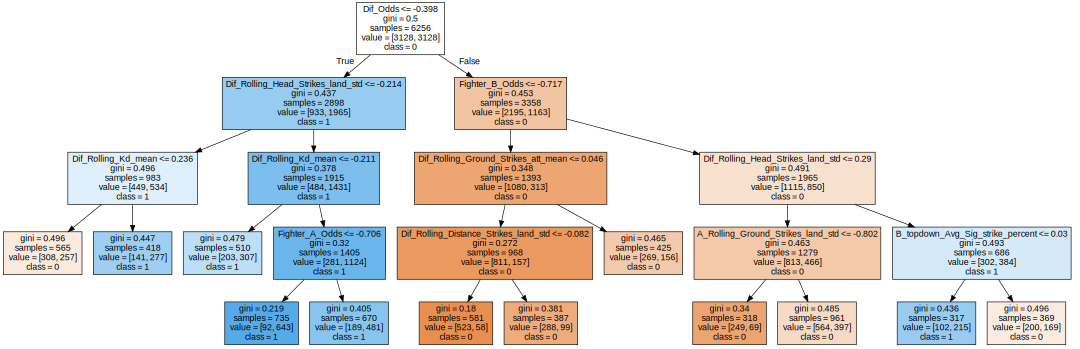

In [ ]:

# Access the decision tree model from the pipeline
decision_tree_model = best_pipeline.named_steps['model']

# Get the numerical column names
numerical_feature_names = numerical_columns

# Get the one-hot-encoded categorical column names
categorical_feature_names = feature_names_categorical

# Combine numerical and one-hot-encoded categorical column names
feature_names = numerical_feature_names + list(categorical_feature_names)

# Get the unique class names (sorted) and convert them to strings
class_names = sorted(y.unique().astype(str))

# Export the decision tree to Graphviz format
dot_data = export_graphviz(decision_tree_model, feature_names=feature_names,
                           class_names=class_names, filled=True)

# Add size attribute to the dot_data string (width, height) in inches
dot_data = dot_data.replace("digraph Tree {", 'digraph Tree { size="15,10";')

graph = graphviz.Source(dot_data)
graph

In [ ]:

# Access the decision tree model from the pipeline
decision_tree_model = best_pipeline.named_steps['model']

# Get the numerical column names
numerical_feature_names = numerical_columns

# Get the one-hot-encoded categorical column names
categorical_feature_names = feature_names_categorical

# Combine numerical and one-hot-encoded categorical column names
feature_names = numerical_feature_names + list(categorical_feature_names)

# Get the unique class names (sorted) and convert them to strings
class_names = sorted(y.unique().astype(str))

def explain_tree(decision_tree, feature_names, class_names, node=0, depth=0, explanation=[]):
    if decision_tree.tree_.children_left[node] == _tree.TREE_LEAF:
        # This is a leaf node, get the predicted class
        class_index = decision_tree.tree_.value[node].argmax()
        class_name = class_names[class_index]
        # Construct the explanation for the leaf node
        explanation.append(f'Then this observation is classified as "{class_name}".')
        return '\n'.join(explanation)
    else:
        # This is an internal node, get the feature and threshold for the decision rule
        feature = feature_names[decision_tree.tree_.feature[node]]
        threshold = decision_tree.tree_.threshold[node]
        # Construct the explanation for the decision rule
        if depth == 0:
            explanation.append(f'If the {feature} <= {threshold:.2f},')
        else:
            explanation.append(f'and if the {feature} <= {threshold:.2f},')
        # Recur on the left subtree (True branch)
        left_explanation = explain_tree(decision_tree, feature_names, class_names, decision_tree.tree_.children_left[node], depth+1, explanation.copy())
        # Update the explanation for the right branch
        explanation[-1] = explanation[-1].replace('<=', '>')
        # Recur on the right subtree (False branch)
        right_explanation = explain_tree(decision_tree, feature_names, class_names, decision_tree.tree_.children_right[node], depth+1, explanation.copy())
        return f'{left_explanation}\n\nOtherwise, {right_explanation}'
    

# Use the recursive function to generate the explanation
explanation = explain_tree(decision_tree_model, feature_names, class_names)
print(explanation)

If the Dif_Odds <= -0.40,
and if the Dif_Rolling_Head_Strikes_land_std <= -0.21,
and if the Dif_Rolling_Kd_mean <= 0.24,
Then this observation is classified as "0".

Otherwise, If the Dif_Odds <= -0.40,
and if the Dif_Rolling_Head_Strikes_land_std <= -0.21,
and if the Dif_Rolling_Kd_mean > 0.24,
Then this observation is classified as "1".

Otherwise, If the Dif_Odds <= -0.40,
and if the Dif_Rolling_Head_Strikes_land_std > -0.21,
and if the Dif_Rolling_Kd_mean <= -0.21,
Then this observation is classified as "1".

Otherwise, If the Dif_Odds <= -0.40,
and if the Dif_Rolling_Head_Strikes_land_std > -0.21,
and if the Dif_Rolling_Kd_mean > -0.21,
and if the Fighter_A_Odds <= -0.71,
Then this observation is classified as "1".

Otherwise, If the Dif_Odds <= -0.40,
and if the Dif_Rolling_Head_Strikes_land_std > -0.21,
and if the Dif_Rolling_Kd_mean > -0.21,
and if the Fighter_A_Odds > -0.71,
Then this observation is classified as "1".

Otherwise, If the Dif_Odds > -0.40,
and if the Fighter_B_O

In [ ]:
def explain_tree(decision_tree, feature_names, class_names, node=0, depth=0, explanation=[]):
    samples = decision_tree.tree_.n_node_samples[node]
    values = decision_tree.tree_.value[node][0]
    value_proportions = values / sum(values)
    gini_impurity = decision_tree.tree_.impurity[node]

    if decision_tree.tree_.children_left[node] == _tree.TREE_LEAF:
        class_index = decision_tree.tree_.value[node].argmax()
        class_name = class_names[class_index]
        explanation.append(f'Then this observation is classified as "{class_name}".')
        return '\n'.join(explanation)
    else:
        feature = feature_names[decision_tree.tree_.feature[node]]
        threshold = decision_tree.tree_.threshold[node]

        if depth == 0:
            explanation.append(f'If the {feature} <= {threshold:.2f},')
        else:
            explanation.append(f'and if the {feature} <= {threshold:.2f},')

        explanation.append(f'This node has {samples} samples, with class proportions: {", ".join([f"{class_names[i]}: {value_proportions[i]:.2f}" for i in range(len(values))])}.')
        explanation.append(f'The Gini impurity for this node is {gini_impurity:.2f}.')

        left_explanation = explain_tree(decision_tree, feature_names, class_names, decision_tree.tree_.children_left[node], depth+1, explanation.copy())

        explanation[-3] = explanation[-3].replace('<=', '>')
        right_explanation = explain_tree(decision_tree, feature_names, class_names, decision_tree.tree_.children_right[node], depth+1, explanation.copy())

        return f'{left_explanation}\n\nOtherwise, {right_explanation}'

explanation = explain_tree(decision_tree_model, feature_names, class_names)
print(explanation)


If the Dif_Odds <= -0.40,
This node has 6256 samples, with class proportions: 0: 0.50, 1: 0.50.
The Gini impurity for this node is 0.50.
and if the Dif_Rolling_Head_Strikes_land_std <= -0.21,
This node has 2898 samples, with class proportions: 0: 0.32, 1: 0.68.
The Gini impurity for this node is 0.44.
and if the Dif_Rolling_Kd_mean <= 0.24,
This node has 983 samples, with class proportions: 0: 0.46, 1: 0.54.
The Gini impurity for this node is 0.50.
Then this observation is classified as "0".

Otherwise, If the Dif_Odds <= -0.40,
This node has 6256 samples, with class proportions: 0: 0.50, 1: 0.50.
The Gini impurity for this node is 0.50.
and if the Dif_Rolling_Head_Strikes_land_std <= -0.21,
This node has 2898 samples, with class proportions: 0: 0.32, 1: 0.68.
The Gini impurity for this node is 0.44.
and if the Dif_Rolling_Kd_mean > 0.24,
This node has 983 samples, with class proportions: 0: 0.46, 1: 0.54.
The Gini impurity for this node is 0.50.
Then this observation is classified as 

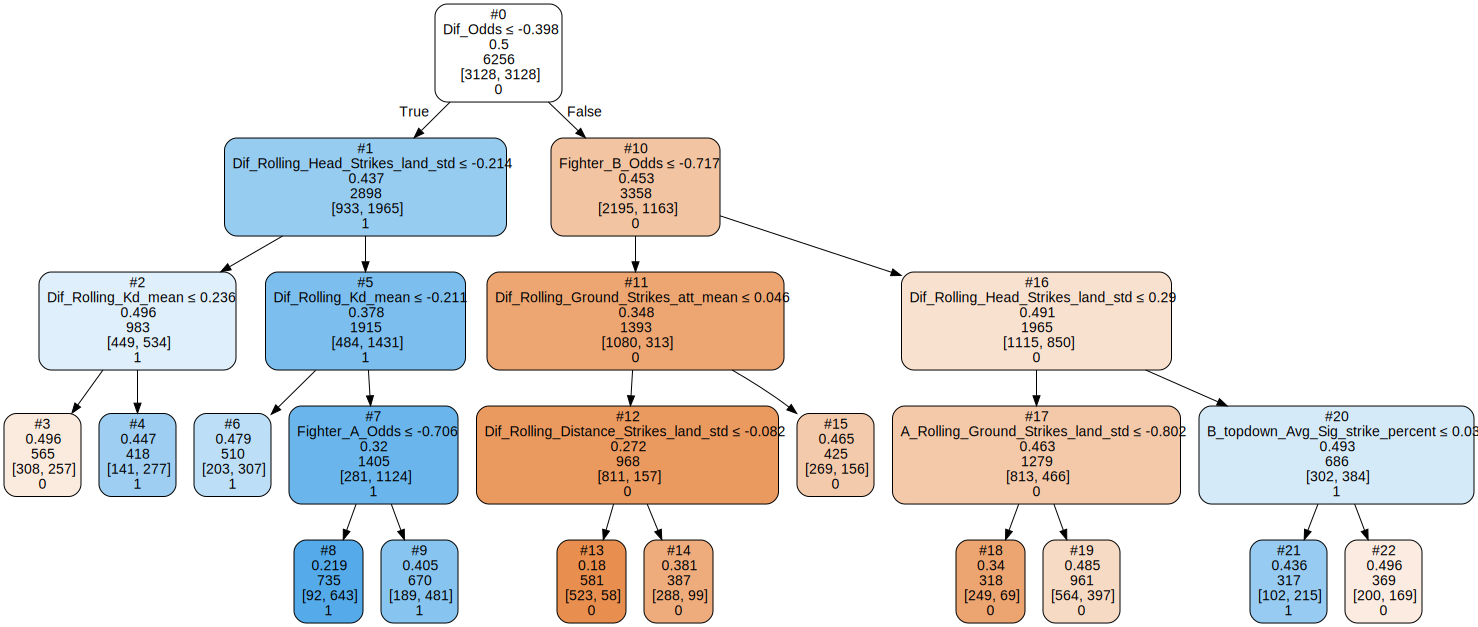

In [ ]:
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import display

def explain_tree(decision_tree, feature_names, class_names, node=0, depth=0, explanation=[]):
    if decision_tree.tree_.children_left[node] == _tree.TREE_LEAF:
        class_index = decision_tree.tree_.value[node].argmax()
        class_name = class_names[class_index]
        explanation.append(f'Then this observation is classified as "{class_name}".')
        return explanation
    else:
        feature = feature_names[decision_tree.tree_.feature[node]]
        threshold = decision_tree.tree_.threshold[node]
        if depth == 0:
            explanation.append(f'If the {feature} <= {threshold:.2f},')
        else:
            explanation.append(f'and if the {feature} <= {threshold:.2f},')
        left_explanation = explain_tree(decision_tree, feature_names, class_names, decision_tree.tree_.children_left[node], depth+1, explanation.copy())
        explanation[-1] = explanation[-1].replace('<=', '>')
        right_explanation = explain_tree(decision_tree, feature_names, class_names, decision_tree.tree_.children_right[node], depth+1, explanation.copy())
        return left_explanation + right_explanation

node_explanations = explain_tree(decision_tree_model, feature_names, class_names)

def my_node_label(node):
    return node_explanations[node]

dot_data = export_graphviz(decision_tree_model, out_file=None, feature_names=feature_names, class_names=class_names, filled=True, rounded=True, special_characters=True, node_ids=True, label=my_node_label)
graph = graphviz.Source(dot_data)
display(graph)



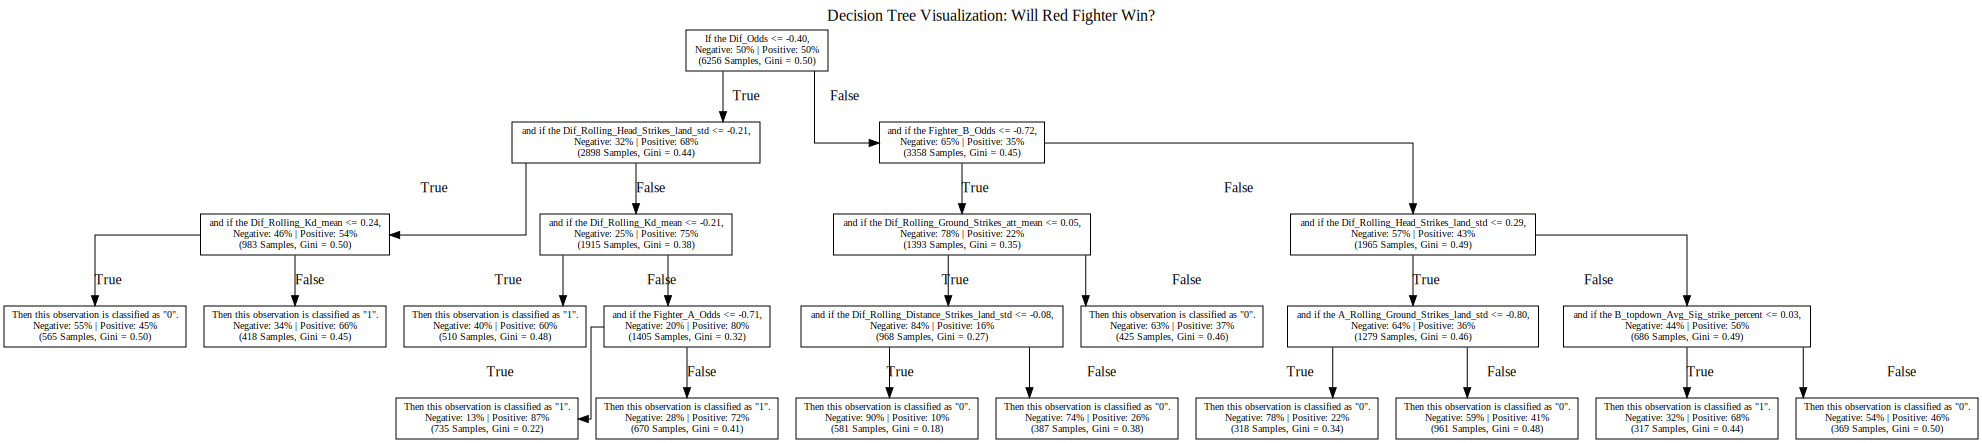

In [ ]:
import graphviz
from sklearn.tree import _tree

def build_graph(decision_tree, feature_names, class_names, title, label_0='No', label_1='Yes', node=0, depth=0, parent=None, branch=None):
    samples = decision_tree.tree_.n_node_samples[node]
    values = decision_tree.tree_.value[node][0]
    value_proportions = values / sum(values)
    gini_impurity = decision_tree.tree_.impurity[node]

    if decision_tree.tree_.children_left[node] == _tree.TREE_LEAF:
        class_index = decision_tree.tree_.value[node].argmax()
        class_name = class_names[class_index]
        explanation = f'Then this observation is classified as "{class_name}".'
    else:
        feature = feature_names[decision_tree.tree_.feature[node]]
        threshold = decision_tree.tree_.threshold[node]
        explanation = f'If the {feature} <= {threshold:.2f},' if depth == 0 else f'and if the {feature} <= {threshold:.2f},'

    explanation += (f'\n{label_0}: {value_proportions[0]*100:.0f}% | {label_1}: {value_proportions[1]*100:.0f}%'
                    f'\n({samples} Samples, Gini = {gini_impurity:.2f})')
    graph.node(str(node), label=explanation, shape='rectangle', fontsize='10')

    if parent is not None:
        graph.edge(str(parent), str(node), label=branch)

    if decision_tree.tree_.children_left[node] != _tree.TREE_LEAF:
        build_graph(decision_tree, feature_names, class_names, title, label_0, label_1, decision_tree.tree_.children_left[node], depth+1, node, "True")
        build_graph(decision_tree, feature_names, class_names, title, label_0, label_1, decision_tree.tree_.children_right[node], depth+1, node, "False")

# Create a new Graphviz graph
graph = graphviz.Digraph(format='png', graph_attr={'splines': 'ortho', 'ranksep': '0.5'})

# Specify custom labels for class 0 and class 1
custom_label_0 = 'Negative'
custom_label_1 = 'Positive'

# Specify the title for the graph
graph_title = 'Decision Tree Visualization: Will Red Fighter Win?'

# Set the title for the graph
graph.attr(label=graph_title, labelloc='t', fontsize='16')

# Call the build_graph function to construct the graph recursively
build_graph(decision_tree_model, feature_names, class_names, graph_title, custom_label_0, custom_label_1)

# Display the graph once it has been fully constructed
display(graph)

In [ ]:
# load random forest model from pickle

with open(model_folder + 'Random_Forest.pkl', 'rb') as f:
    rf_model = pickle.load(f)

Random Forest Sequential GridSearch

In [ ]:

def random_forest_sequential_gridsearch(model, X, y):

    # Define the grid of hyperparameters
    param_grids = [
        {'n_estimators': [100],
         'max_depth': [None] + list(range(2, 101, 7)),
         'max_features': ['auto', 'sqrt'],
         'criterion': ['gini'],
         'min_samples_split': list(range(2, 8)),
         'min_samples_leaf': list(range(1, 8)),
         'bootstrap': [True],
         'max_leaf_nodes': [None] + list(range(2, 6)),
         'min_impurity_decrease': [x / 10 for x in range(4)],
         'n_jobs':[16]}
    ]

    best_params = {}

    counter = 0

    # Perform a sequential grid search, updating the best parameters found for each hyperparameter
    for param_name, param_values in param_grids[0].items():
        # if the file exists, load it and skip the gridsearch, and test it
        if os.path.isfile(model_folder + 'Random_Forest_Sequential_Gridsearch_part_{counter}.pkl'):
            with open(model_folder + 'Random_Forest_Sequential_Gridsearch_part_{counter}.pkl', 'rb') as f:
                best_estimator = pickle.load(f)
            score_and_save(best_estimator, f'Random_Forest_Sequential_Gridsearch_part_{counter}')
            counter += 1
            continue

        else:

            # Use the list of values for the current hyperparameter
            current_grid = {param_name: param_values}
            # Update the best parameters found so far
            for k, v in best_params.items():
                if k != param_name:
                    current_grid[k] = [v]  # Wrap individual values in a list
            current_grid = {'model__' + k: v for k, v in current_grid.items()}

            # Use GridSearchCV with the current hyperparameter grid
            gridsearch = GridSearchCV(model, current_grid, cv=4, scoring='accuracy', verbose=3)
            gridsearch.fit(X_train, y_train)
            best_estimator = gridsearch.best_estimator_
            score_and_save(best_estimator, f'Random_Forest_Sequential_Gridsearch_part_{counter}')

            best_param_value = gridsearch.best_params_['model__' + param_name]

            # Update the best parameters dictionary with the best value found for the current hyperparameter
            best_params[param_name] = best_param_value
            print(f'Best {param_name}: {best_param_value}')
            counter += 1
        

    return best_estimator, best_params


In [ ]:
# run the gridsearch
best_estimator, best_params = random_forest_sequential_gridsearch(rf_model, X_train, y_train)

final_gridsearched_model = score_and_save(best_estimator, 'Random_Forest_Sequential_Gridsearch')
final_gridsearched_model

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END ...........model__n_estimators=100;, score=0.729 total time=   4.7s
[CV 2/4] END ...........model__n_estimators=100;, score=0.715 total time=   4.7s
[CV 3/4] END ...........model__n_estimators=100;, score=0.718 total time=   4.6s
[CV 4/4] END ...........model__n_estimators=100;, score=0.706 total time=   4.7s
Best n_estimators: 100
Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV 1/4] END model__max_depth=None, model__n_estimators=100;, score=0.713 total time=   4.8s
[CV 2/4] END model__max_depth=None, model__n_estimators=100;, score=0.706 total time=   4.7s
[CV 3/4] END model__max_depth=None, model__n_estimators=100;, score=0.715 total time=   4.7s
[CV 4/4] END model__max_depth=None, model__n_estimators=100;, score=0.698 total time=   4.8s
[CV 1/4] END model__max_depth=2, model__n_estimators=100;, score=0.707 total time=   0.9s
[CV 2/4] END model__max_depth=2, model__n_estimators=100;, score=0.700 

Model_Name  Cv_Mean_Accuracy  \
0  Random_Forest_Sequential_Gridsearch_part_5             0.706   
0  Random_Forest_Sequential_Gridsearch_part_6             0.703   
0  Random_Forest_Sequential_Gridsearch_part_7             0.698   
0  Random_Forest_Sequential_Gridsearch_part_8             0.698   
0                               Random_Forest             0.698   
0  Random_Forest_Sequential_Gridsearch_part_2             0.697   
0  Random_Forest_Sequential_Gridsearch_part_3             0.696   
0  Random_Forest_Sequential_Gridsearch_part_9             0.695   
0  Random_Forest_Sequential_Gridsearch_part_0             0.694   
0                                     XGBoost             0.690   
0         Random_Forest_Sequential_Gridsearch             0.687   
0  Random_Forest_Sequential_Gridsearch_part_4             0.686   
0                                 Extra_Trees             0.686   
0  Random_Forest_Sequential_Gridsearch_part_1             0.684   
0                         Logistic_Regression             0.672   
0                  Decision_Tree_Gridsearched             0.652   
0                                Bagged_Trees             0.647   
0                               Decision_Tree             0.595   
0                                 K_Neighbors             0.589   

   Cv_Std_Accuracy  
0            0.006  
0            0.008  
0            0.007  
0            0.006  
0            0.010  
0            0.008  
0            0.009  
0            0.010  
0            0.004  
0            0.002  
0            0.003  
0            0.008  
0            0.006  
0            0.009  
0            0.006  
0            0.014  
0            0.012  
0            0.015  
0            0.011

In [ ]:
# check if the model exists already in models folder
def check_model(model_name):
    if os.path.isfile(model_folder + model_name +'.pkl'):
        print('Model already exists')
        return True
    else:
        return False


if check_model('Random_Forest_1000') == False:
    create_fullpipe(preprocessing, RandomForestClassifier(n_estimators=1000), 'Random_Forest_1000')
else:
    # load model from pickle
    with open(model_folder + 'Random_Forest_1000.pkl', 'rb') as f:
        rf_1000_model = pickle.load(f)
    # test it
    score_and_save(rf_1000_model, 'Random_Forest_1000')

if check_model('Random_Forest_500') == False:
    create_fullpipe(preprocessing, RandomForestClassifier(n_estimators=500), 'Random_Forest_500')
    # load model from pickle
    with open(model_folder + 'Random_Forest_500.pkl', 'rb') as f:
        rf_500_model = pickle.load(f)
    # test it
    score_and_save(rf_500_model, 'Random_Forest_500')



In [ ]:
# load random forest model from pickle

with open(model_folder + 'Random_Forest.pkl', 'rb') as f:
    rf_model = pickle.load(f)


### <a id='toc2_1_2_'></a>[Model 1: XGBoost](#toc0_)

In [ ]:
xg_boost = pickle.load(open(model_folder + 'XGBoost.pkl', 'rb'))
keys = xg_boost.get_params().keys()
model_keys = [key for key in keys if 'model' in key]
xg_boost[1].get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)>

In [ ]:

def xgboost_sequential_gridsearch(model, X, y):

    # Define the grid of hyperparameters
    param_grids = [
        {'model__n_estimators': [100],
         'model__max_depth': list(range(2, 50, 4)),
         'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
         'model__min_child_weight': list(range(1, 8)),
         'model__gamma': [0, 0.1, 0.2, 0.3],
         'model__subsample': [0.6, 0.8, 1.0],
         'model__colsample_bytree': [0.6, 0.8, 1.0]}
    ]

    best_params = {}

    counter = 0

    # Perform a sequential grid search, updating the best parameters found for each hyperparameter
    for param_name, param_values in param_grids[0].items():

        # If the file exists, load it and skip the gridsearch, and test it
        if os.path.isfile(model_folder + 'XGBoost_Sequential_Gridsearch_part_{counter}.pkl'):
            with open(model_folder + 'XGBoost_Sequential_Gridsearch_part_{counter}.pkl', 'rb') as f:
                best_estimator = pickle.load(f)
            score_and_save(best_estimator, 'XGBoost_Sequential_Gridsearch_part_{counter}')
            counter += 1
            continue

        else:
            # Use the list of values for the current hyperparameter
            current_grid = {param_name: param_values}
            # Update the best parameters found so far
            for k, v in best_params.items():
                if k != param_name:
                    current_grid[k] = [v]  # Wrap individual values in a list
            current_grid = {k: v for k, v in current_grid.items()}

            # Use GridSearchCV with the current hyperparameter grid
            gridsearch = GridSearchCV(model, current_grid, cv=4, scoring='accuracy', verbose=3)
            gridsearch.fit(X, y)
            best_estimator = gridsearch.best_estimator_
            score_and_save(best_estimator, f'XGBoost_Sequential_Gridsearch_part_{counter}')

            best_param_value = gridsearch.best_params_[param_name]

            # Update the best parameters dictionary with the best value found for the current hyperparameter
            best_params[param_name] = best_param_value
            print(f'Best {param_name}: {best_param_value}')
            counter += 1

    return best_estimator, best_params


In [ ]:
# run the gridsearch
best_estimator, best_params = xgboost_sequential_gridsearch(xg_boost, X_train, y_train)

final_gridsearched_model = score_and_save(best_estimator, 'XGBoost_Sequential_Gridsearch')
final_gridsearched_model

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END ...........model__n_estimators=100;, score=0.731 total time=   1.4s
[CV 2/4] END ...........model__n_estimators=100;, score=0.712 total time=   1.4s
[CV 3/4] END ...........model__n_estimators=100;, score=0.712 total time=   1.4s
[CV 4/4] END ...........model__n_estimators=100;, score=0.716 total time=   1.4s
Best model__n_estimators: 100
Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV 1/4] END model__max_depth=2, model__n_estimators=100;, score=0.733 total time=   0.6s
[CV 2/4] END model__max_depth=2, model__n_estimators=100;, score=0.719 total time=   0.7s
[CV 3/4] END model__max_depth=2, model__n_estimators=100;, score=0.733 total time=   0.6s
[CV 4/4] END model__max_depth=2, model__n_estimators=100;, score=0.722 total time=   0.6s
[CV 1/4] END model__max_depth=6, model__n_estimators=100;, score=0.731 total time=   1.4s
[CV 2/4] END model__max_depth=6, model__n_estimators=100;, score=0.712 total

Model_Name  Cv_Mean_Accuracy  \
0        XGBoost_Sequential_Gridsearch_part_3             0.709   
0        XGBoost_Sequential_Gridsearch_part_5             0.709   
0        XGBoost_Sequential_Gridsearch_part_4             0.709   
0               XGBoost_Sequential_Gridsearch             0.709   
0        XGBoost_Sequential_Gridsearch_part_6             0.709   
0                          Random_Forest_1000             0.708   
0  Random_Forest_Sequential_Gridsearch_part_5             0.706   
0        XGBoost_Sequential_Gridsearch_part_2             0.705   
0  Random_Forest_Sequential_Gridsearch_part_6             0.703   
0                           Random_Forest_500             0.703   
0                           Random_Forest_500             0.700   
0  Random_Forest_Sequential_Gridsearch_part_7             0.698   
0  Random_Forest_Sequential_Gridsearch_part_8             0.698   
0                               Random_Forest             0.698   
0  Random_Forest_Sequential_Gridsearch_part_2             0.697   
0  Random_Forest_Sequential_Gridsearch_part_3             0.696   
0  Random_Forest_Sequential_Gridsearch_part_9             0.695   
0  Random_Forest_Sequential_Gridsearch_part_0             0.694   
0        XGBoost_Sequential_Gridsearch_part_1             0.690   
0                                     XGBoost             0.690   
0        XGBoost_Sequential_Gridsearch_part_0             0.690   
0         Random_Forest_Sequential_Gridsearch             0.687   
0  Random_Forest_Sequential_Gridsearch_part_4             0.686   
0                                 Extra_Trees             0.686   
0  Random_Forest_Sequential_Gridsearch_part_1             0.684   
0                         Logistic_Regression             0.672   
0                  Decision_Tree_Gridsearched             0.652   
0                                Bagged_Trees             0.647   
0                               Decision_Tree             0.595   
0                                 K_Neighbors             0.589   

   Cv_Std_Accuracy  
0            0.008  
0            0.008  
0            0.008  
0            0.008  
0            0.008  
0            0.013  
0            0.006  
0            0.002  
0            0.008  
0            0.009  
0            0.014  
0            0.007  
0            0.006  
0            0.010  
0            0.008  
0            0.009  
0            0.010  
0            0.004  
0            0.005  
0            0.002  
0            0.002  
0            0.003  
0            0.008  
0            0.006  
0            0.009  
0            0.006  
0            0.014  
0            0.012  
0            0.015  
0            0.011

### <a id='toc2_1_3_'></a>[Extra Trees](#toc0_)

In [ ]:
extra_trees = pickle.load(open(model_folder + 'Extra_Trees.pkl', 'rb'))

In [ ]:
keys = extra_trees.get_params().keys()
model_keys = [key for key in keys if 'model' in key]
model_keys

['model',
 'model__bootstrap',
 'model__ccp_alpha',
 'model__class_weight',
 'model__criterion',
 'model__max_depth',
 'model__max_features',
 'model__max_leaf_nodes',
 'model__max_samples',
 'model__min_impurity_decrease',
 'model__min_samples_leaf',
 'model__min_samples_split',
 'model__min_weight_fraction_leaf',
 'model__n_estimators',
 'model__n_jobs',
 'model__oob_score',
 'model__random_state',
 'model__verbose',
 'model__warm_start']

In [ ]:

def extra_trees_sequential_gridsearch(model, X, y):
    # Define the grid of hyperparameters
    param_grids = [
        {'model__n_estimators': [100],
         'model__max_depth': [None] + list(range(2, 101, 7)),
         'model__max_features': ['auto', 'sqrt'],
         'model__criterion': ['gini', 'entropy'],
         'model__min_samples_split': list(range(2, 8)),
         'model__min_samples_leaf': list(range(1, 8)),
         'model__bootstrap': [True, False],
         'model__max_leaf_nodes': [None] + list(range(2, 6)),
         'model__min_impurity_decrease': [x / 10 for x in range(4)],
         'model__n_jobs': [16]}
    ]

    best_params = {}
    counter = 0

    # Perform a sequential grid search, updating the best parameters found for each hyperparameter
    for param_name, param_values in param_grids[0].items():
        # if the file exists, load it and skip the gridsearch, and test it
        if os.path.isfile(model_folder + 'Extra_Trees_Sequential_Gridsearch_part_{counter}.pkl'):
            with open(model_folder + 'Extra_Trees_Sequential_Gridsearch_part_{counter}.pkl', 'rb') as f:
                best_estimator = pickle.load(f)
            score_and_save(best_estimator, f'Extra_Trees_Sequential_Gridsearch_part_{counter}')
            counter += 1
            continue

        else:

            # Use the list of values for the current hyperparameter
            current_grid = {param_name: param_values}
            # Update the best parameters found so far
            for k, v in best_params.items():
                if k != param_name:
                    current_grid[k] = [v]  # Wrap individual values in a list
            current_grid = {k: v for k, v in current_grid.items()}

            # Use GridSearchCV with the current hyperparameter grid
            gridsearch = GridSearchCV(model, current_grid, cv=4, scoring='accuracy', verbose=3)
            gridsearch.fit(X_train, y_train)
            best_estimator = gridsearch.best_estimator_
            score_and_save(best_estimator, f'Extra_Trees_Sequential_Gridsearch_part_{counter}')

            best_param_value = gridsearch.best_params_[param_name]

            # Update the best parameters dictionary with the best value found for the current hyperparameter
            best_params[param_name] = best_param_value
            print(f'Best {param_name}: {best_param_value}')
            counter += 1

    return best_estimator, best_params


In [ ]:
# Run the grid search
best_estimator, best_params = extra_trees_sequential_gridsearch(extra_trees, X_train, y_train)

final_gridsearched_model = score_and_save(best_estimator, 'Extra_Trees_Sequential_Gridsearch')
final_gridsearched_model

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END ...........model__n_estimators=100;, score=0.710 total time=   1.7s
[CV 2/4] END ...........model__n_estimators=100;, score=0.707 total time=   1.5s
[CV 3/4] END ...........model__n_estimators=100;, score=0.717 total time=   1.5s
[CV 4/4] END ...........model__n_estimators=100;, score=0.695 total time=   1.6s
Best model__n_estimators: 100
Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV 1/4] END model__max_depth=None, model__n_estimators=100;, score=0.717 total time=   1.6s
[CV 2/4] END model__max_depth=None, model__n_estimators=100;, score=0.705 total time=   1.6s
[CV 3/4] END model__max_depth=None, model__n_estimators=100;, score=0.712 total time=   1.5s
[CV 4/4] END model__max_depth=None, model__n_estimators=100;, score=0.700 total time=   1.5s
[CV 1/4] END model__max_depth=2, model__n_estimators=100;, score=0.710 total time=   0.3s
[CV 2/4] END model__max_depth=2, model__n_estimators=100;, score

Model_Name  Cv_Mean_Accuracy  \
0        XGBoost_Sequential_Gridsearch_part_3             0.709   
0        XGBoost_Sequential_Gridsearch_part_5             0.709   
0        XGBoost_Sequential_Gridsearch_part_4             0.709   
0               XGBoost_Sequential_Gridsearch             0.709   
0        XGBoost_Sequential_Gridsearch_part_6             0.709   
0                          Random_Forest_1000             0.708   
0  Random_Forest_Sequential_Gridsearch_part_5             0.706   
0        XGBoost_Sequential_Gridsearch_part_2             0.705   
0    Extra_Trees_Sequential_Gridsearch_part_6             0.704   
0  Random_Forest_Sequential_Gridsearch_part_6             0.703   
0                           Random_Forest_500             0.703   
0           Extra_Trees_Sequential_Gridsearch             0.701   
0                           Random_Forest_500             0.700   
0  Random_Forest_Sequential_Gridsearch_part_7             0.698   
0    Extra_Trees_Sequential_Gridsearch_part_8             0.698   
0  Random_Forest_Sequential_Gridsearch_part_8             0.698   
0                               Random_Forest             0.698   
0  Random_Forest_Sequential_Gridsearch_part_2             0.697   
0  Random_Forest_Sequential_Gridsearch_part_3             0.696   
0  Random_Forest_Sequential_Gridsearch_part_9             0.695   
0    Extra_Trees_Sequential_Gridsearch_part_7             0.695   
0    Extra_Trees_Sequential_Gridsearch_part_3             0.694   
0    Extra_Trees_Sequential_Gridsearch_part_9             0.694   
0  Random_Forest_Sequential_Gridsearch_part_0             0.694   
0    Extra_Trees_Sequential_Gridsearch_part_0             0.694   
0    Extra_Trees_Sequential_Gridsearch_part_1             0.694   
0    Extra_Trees_Sequential_Gridsearch_part_2             0.691   
0        XGBoost_Sequential_Gridsearch_part_1             0.690   
0                                     XGBoost             0.690   
0        XGBoost_Sequential_Gridsearch_part_0             0.690   
0    Extra_Trees_Sequential_Gridsearch_part_5             0.689   
0    Extra_Trees_Sequential_Gridsearch_part_4             0.688   
0         Random_Forest_Sequential_Gridsearch             0.687   
0  Random_Forest_Sequential_Gridsearch_part_4             0.686   
0                                 Extra_Trees             0.686   
0  Random_Forest_Sequential_Gridsearch_part_1             0.684   
0                         Logistic_Regression             0.672   
0                  Decision_Tree_Gridsearched             0.652   
0                                Bagged_Trees             0.647   
0                               Decision_Tree             0.595   
0                                 K_Neighbors             0.589   

   Cv_Std_Accuracy  
0            0.008  
0            0.008  
0            0.008  
0            0.008  
0            0.008  
0            0.013  
0            0.006  
0            0.002  
0            0.005  
0            0.008  
0            0.009  
0            0.004  
0            0.014  
0            0.007  
0            0.001  
0            0.006  
0            0.010  
0            0.008  
0            0.009  
0            0.010  
0            0.010  
0            0.009  
0            0.004  
0            0.004  
0            0.006  
0            0.002  
0            0.006  
0            0.005  
0            0.002  
0            0.002  
0            0.011  
0            0.006  
0            0.003  
0            0.008  
0            0.006  
0            0.009  
0            0.006  
0            0.014  
0            0.012  
0            0.015  
0            0.011

#### <a id='toc2_1_3_1_'></a>[Best Model](#toc0_)


In [ ]:
# pick the top model in saved models
top_model = model_summary2.iloc[0, 0]
top_model

'XGBoost_Sequential_Gridsearch_part_3'

In [ ]:
best_model = pickle.load(open(model_folder + ''+top_model+'.pkl', 'rb'))

In [ ]:
best_model['model'].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': 4,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
cat_list= list(feature_names_categorical)

In [ ]:
all_cats = cat_list + numerical_columns

In [ ]:
f_imp = best_model.steps[1][1].feature_importances_
f_imp_df = pd.DataFrame(f_imp, index = all_cats, columns = ['Importance'])
f_imp_df = f_imp_df.sort_values('Importance', ascending = False)
f_imp_df = f_imp_df.round(3)
f_imp_df

Importance
fight_weightclass_Middleweight             0.079
fight_weightclass_Flyweight                0.046
fight_weightclass_Featherweight            0.033
A_Rolling_Head_Strikes_att_mean            0.032
A_Rolling_Sub_Success_Percent_median       0.029
...                                          ...
B_Rolling_Total_Strikes_land_mean          0.000
B_Rolling_Total_Strikes_percent_mean       0.000
B_Rolling_Takedowns_land_mean              0.000
B_Rolling_Takedowns_att_mean               0.000
B_Martial_Art_Year_Started_3               0.000

[1047 rows x 1 columns]

In [ ]:
f_imp_df[:50]

Importance
fight_weightclass_Middleweight                           0.079
fight_weightclass_Flyweight                              0.046
fight_weightclass_Featherweight                          0.033
A_Rolling_Head_Strikes_att_mean                          0.032
A_Rolling_Sub_Success_Percent_median                     0.029
B_Rolling_Body_Strikes_percent_mean                      0.029
B_Rolling_Total_Strikes_att_mean                         0.027
A_Rolling_Kd_median                                      0.027
B_Rolling_Body_Strikes_att_mean                          0.025
A_Rolling_Sig_strike_percent_median                      0.021
A_Rolling_Head_Strikes_percent_mean                      0.019
A_Rolling_Sig_strike_percent_mean                        0.016
B_Martial_Art_3_Boxing                                   0.016
A_Style_Karate                                           0.015
B_Martial_Art_3_Iaijutsu                                 0.014
B_Rolling_Clinch_Strikes_percent_mean                    0.013
Style_Matchup_Wrestling vs Muay Thai                     0.011
A_Rolling_Leg_Strikes_percent_mean                       0.011
A_Rolling_Total_Strikes_att_mean                         0.010
B_Martial_Art_3_Judo 2005                                0.010
A_Rolling_Body_Strikes_land_mean                         0.010
A_Rolling_Ground_Strikes_att_median                      0.010
A_Style_Kickboxing                                       0.009
A_Martial_Art_3_Iaido                                    0.009
B_Martial_Art_1_'Muay Thai                               0.009
A_Rolling_Ground_Strikes_percent_median                  0.008
Style_Matchup_Muay Thai vs Brazilian Jiu-Jitsu           0.008
Style_Matchup_MMA vs Taekwondo                           0.007
Style_Matchup_Wrestling vs Sambo                         0.006
Style_Matchup_Taekwondo vs Sambo                         0.006
Style_Matchup_Kung-Fu vs Judo                            0.006
Fighter_B_Odds                                           0.006
B_Sub_Success_Percent                                    0.006
A_Rolling_Ctrl_time_min_median                           0.005
B_Martial_Art_3_Judo 2001                                0.005
Style_Matchup_Wrestling vs MMA (Mixed Martial A...       0.005
Style_Matchup_Muay Thai vs Wrestling                     0.005
Style_Matchup_Wrestling vs Mixed Martial Arts            0.005
B_Martial_Art_3_Iaido                                    0.005
Style_Matchup_Kung-Fu vs Taekwondo                       0.005
Style_Matchup_Mixed Martial Arts vs Boxing               0.005
A_Martial_Art_3_Muay Thai                                0.005
B_Opp_Avg_Total_Strikes_att                              0.005
A_Rolling_Total_Strikes_att_std                          0.005
Style_Matchup_Karate vs Wrestling                        0.005
Style_Matchup_Kickboxing vs Wrestling                    0.005
Style_Matchup_Wrestling vs Wrestling                     0.004
B_Rolling_Distance_Strikes_percent_mean                  0.004
Style_Matchup_Kickboxing vs Boxing                       0.004
Style_Matchup_Mixed Martial Arts vs Judo                 0.004

In [ ]:
f_imp_df[50:100]

Importance
A_Martial_Art_1_'Brazilian Jiu-Jitsu                     0.004
B_Rolling_Clinch_Strikes_land_mean                       0.004
B_Martial_Art_1_Kodokan Judo                             0.004
Style_Matchup_Mixed Martial Arts vs Brazilian J...       0.004
Style_Matchup_Wrestling vs Boxing                        0.004
Style_Matchup_Muay Thai vs MMA (Mixed Martial A...       0.004
B_Rolling_Sig_strike_att_mean                            0.004
favorite?_0                                              0.004
A_Martial_Art_2_Hapkido                                  0.004
A_Rolling_Total_Strikes_percent_median                   0.004
favorite?_1                                              0.004
B_Martial_Art_1_'Judo                                    0.004
A_Rolling_Body_Strikes_land_std                          0.004
A_Martial_Art_3_Muay Boran                               0.004
A_Rolling_Head_Strikes_land_median                       0.004
fight_weightclass_Welterweight                           0.004
A_Rolling_Ground_Strikes_land_std                        0.004
B_Rolling_Ground_Strikes_percent_mean                    0.004
Style_Matchup_Sambo vs Muay Thai                         0.004
B_Rolling_Sub_Success_Percent_median                     0.004
Fighter_A_Odds_Change                                    0.004
A_Martial_Art_1_Wrestling                                0.004
A_Martial_Art_2_Aikido                                   0.004
A_Rolling_Sub_Attempts_att_median                        0.004
Style_Matchup_Muay Thai vs Boxing                        0.004
Style_Matchup_Muay Thai vs Sambo                         0.004
A_Opp_Avg_Takedown_percent                               0.004
B_Rolling_Ctrl_time_min_median                           0.003
B_Martial_Art_1_Boxing                                   0.003
A_Martial_Art_3_Sanda                                    0.003
B_Rolling_Distance_Strikes_land_mean                     0.003
fight_weightclass_Women's Flyweight                      0.003
Dif_Rolling_Sig_strike_land_mean                         0.003
Style_Matchup_Taekwondo vs Boxing                        0.003
Style_Matchup_Kung-Fu vs Wrestling                       0.003
fight_weightclass_Women's Strawweight                    0.003
B_Martial_Art_1_Karate 1984                              0.003
A_Opp_Avg_Sub_Success_Percent                            0.003
Style_Matchup_Wrestling vs Kickboxing                    0.003
A_Martial_Art_1_Taekwondo                                0.003
fight_weightclass_Women's Bantamweight                   0.003
B_Rolling_Kd_std                                         0.003
B_Rolling_Body_Strikes_land_median                       0.003
A_Martial_Art_3_Savate 1991                              0.003
Style_Matchup_Mixed Martial Arts vs Taekwondo            0.003
A_Rolling_Distance_Strikes_percent_mean                  0.003
B_Martial_Art_3_Aikido                                   0.003
A_Martial_Art_3_Iaijutsu                                 0.003
B_Rolling_Ground_Strikes_att_std                         0.003
A_Martial_Art_3_Tae Kwon Do                              0.003

In [ ]:
best_model['model'].get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': 4,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}